# Предсказание оценок вин

Хотим проанализировать данные и научиться предсказывать рейтинги вин с использованием методов коллаборативной фильтрации, обработки текстовых признаков и машинного обучения. Сразу хочется отметить, что несмотря на типовое сведение такой задачи к задаче классификации как к предсказанию, какую точно оценку из ограниченного числа возможных поставит пользователь, данная задача формулируется как задача регрессии. Это сделано из желания получить больше информации из ошибок предсказаний нормализованного рейтинга - количественную меру отклонения от истинных оценок, а не долю верных предсказаний. Кроме того, хоть выставляемые рейтинги и дискретны, ошибки выставления 4.0 или 1.5 вместо 4.5 не равнозначны. В этой ситуации также имеет смысл обращать больше внимания на среднюю абсолютную ошибку как на более интерпретируемую в рамках задачи.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn import model_selection as ms
from sklearn import metrics
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

import xgboost as xgb

from surprise import SVD, Reader, Dataset, SVDpp
from surprise.model_selection import GridSearchCV
from surprise import NormalPredictor, BaselineOnly
from surprise.model_selection import cross_validate

from collections import OrderedDict

В наличии есть два датасета: непосредственно информация об оставленном рейтинге и информация о вине.

In [2]:
reviews = pd.read_csv('reviews.csv')
reviews.describe()

,rating,review_comments,review_likes,user_follower_count,user_following_count,user_id,user_rating_count,user_reviews_count,wine_id,wine_labels_count,wine_ratings_average,wine_ratings_count,wine_reviews_count
count,99087.000000,99087.000000,99087.000000,99087.000000,99087.000000,9.908700e+04,99087.00000,99087.000000,99087.000000,99087.000000,99087.000000,99087.000000,99087.000000
mean,3.821480,2.978665,19.398004,1409.410397,457.899139,7.306021e+06,929.37676,831.081464,10580.605528,8436.998627,3.773564,3016.010677,485.890177
std,0.603595,8.955136,40.147512,4298.706241,2741.966749,7.025727e+06,1205.52568,1147.839191,7066.033073,15954.793938,0.379097,6157.951815,849.444186
min,1.000000,0.000000,0.000000,0.000000,0.000000,9.700000e+01,0.00000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,0.000000,0.000000,7.000000,7.000000,1.941739e+06,157.00000,122.000000,4407.000000,418.000000,3.500000,197.000000,37.000000
50%,4.000000,0.000000,2.000000,75.000000,50.000000,4.773092e+06,490.00000,394.000000,8817.000000,2087.000000,3.800000,857.000000,155.000000
75%,4.000000,1.000000,20.000000,608.000000,227.000000,1.037788e+07,1228.00000,1077.500000,15967.000000,8460.000000,4.000000,3194.000000,543.000000
max,5.000000,403.000000,732.000000,63603.000000,209850.000000,3.060972e+07,11953.00000,11870.000000,27374.000000,107031.000000,5.000000,74687.000000,5893.000000


In [3]:
wines = pd.read_csv('wines.csv')
wines.describe()

,alcohol,country_regions_count,country_users_count,country_wineries_count,country_wines_count,rank,region_id,sweetness_id,type_id,wine_id,wine_labels_count,wine_ratings_average,wine_ratings_count,wine_vintages_count,winery_id,winery_labels_count,winery_ratings_average,winery_ratings_count,winery_vintages_count
count,15179.000000,15179.000000,1.517900e+04,15179.000000,15179.00000,0.0,15179.000000,640.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,15179.000000,1.517900e+04,15179.000000,15179.000000,15179.000000
mean,9.127182,405.525199,3.410878e+06,24436.713617,177488.28770,NaN,791.762369,5.178125,1.824297,12135.792015,4131.941498,3.453844,765.491205,19.847091,13793.612952,1.102531e+05,3.680980,19182.229857,62.514131
std,6.487692,356.943871,2.609798e+06,17400.268082,109953.91636,NaN,876.530764,0.684839,2.131907,7069.437460,15842.723877,1.057943,2761.674079,14.780259,40097.048743,2.303390e+05,0.622204,37518.257677,201.957474
min,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.00000,NaN,-1.000000,2.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000e+00,-1.000000,-1.000000,-1.000000
25%,0.000000,119.000000,8.095880e+05,10774.000000,76229.00000,NaN,201.000000,5.000000,1.000000,6059.500000,33.000000,3.400000,8.000000,10.000000,1395.500000,3.134500e+03,3.600000,721.000000,20.000000
50%,13.000000,353.000000,2.433650e+06,23021.000000,181142.00000,NaN,533.000000,5.000000,1.000000,11975.000000,267.000000,3.700000,62.000000,17.000000,3464.000000,1.996100e+04,3.800000,4212.000000,37.000000
75%,13.950000,552.000000,6.372124e+06,36219.000000,268975.00000,NaN,856.000000,5.000000,2.000000,18039.000000,1856.500000,4.000000,393.000000,26.000000,7603.000000,9.219300e+04,3.900000,17360.000000,65.000000
max,85.000000,1278.000000,6.391594e+06,62800.000000,390160.00000,NaN,4639.000000,7.000000,25.000000,27474.000000,484969.000000,5.000000,74687.000000,223.000000,252912.000000,1.695043e+06,5.000000,341472.000000,5795.000000


## Анализ целевой переменной

Прежде чем заводить xgboost-ы, важно посмотреть на целевую переменную - её среднее значение и распределение. Кроме того, стоит учитывать смещение оценки внутри пользовательской аудитории, для этого нормализуем рейтинг и посмотрим на распределение его и некольких важных числовых признаков в датасете.

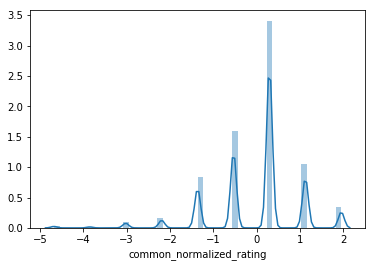

In [4]:
reviews.rating[reviews.rating.isna()]
reviews.loc[42080, 'rating'] = reviews.rating.mean()

ratings = reviews.rating
reviews['common_normalized_rating'] = (ratings - ratings.mean())/(ratings.std())

sns.distplot(reviews['common_normalized_rating'])

/home/maria/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/maria/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/maria/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/maria/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


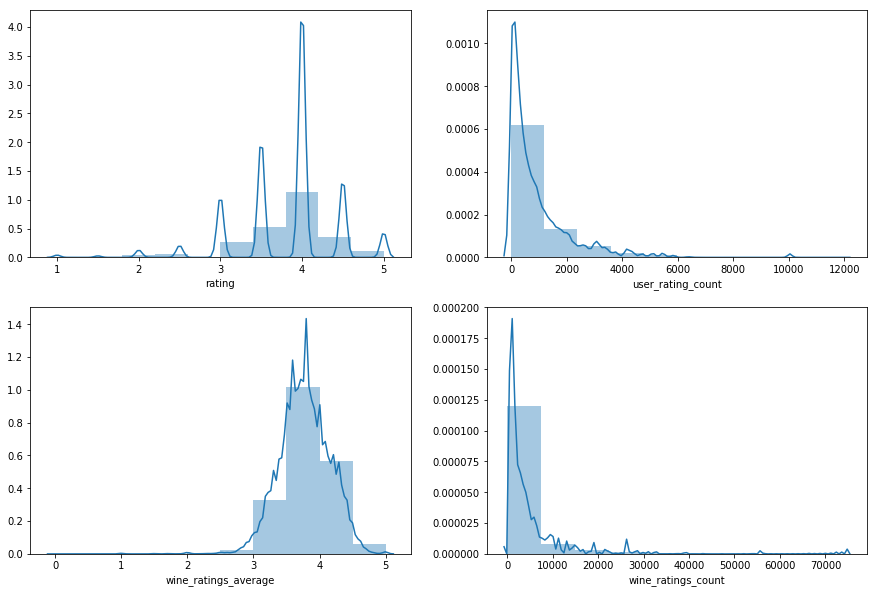

In [5]:
features = ['rating', 'user_rating_count', 'wine_ratings_average', 'wine_ratings_count']

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i in range(len(features)):
    sns.distplot(reviews[features[i]],
             label=features[i],
             bins=10,
             ax=ax[i//2][i%2])

Видно, что имеющиеся данные очень несбалансированы. Наблюдаем высокий пик в положительную сторону от нормализованной оценки, очень много оценок 4.0, средняя оценка вина также лежит в пределах 3.5-4.0. И что самое неприятное, большая часть пользователей в датасете оставила, судя по всему, очнь мало оценок. Если взглянуть подробнее, сгруппировав пользователей по числу оставленных оценок:

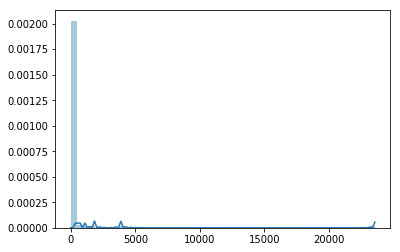

In [6]:
byUserNumRatings = reviews[['user_id', 'rating']].groupby(['user_id']).count()
    
byUserNumRatings.reset_index(level=0, inplace=True)

numUsersByNumRatings = byUserNumRatings.groupby(['rating']).count()

sns.distplot(numUsersByNumRatings)

Большая часть пользователей оставила только 1 оценку, что очень непрезентативно для построения рабочей рекомендательной системы. Такое распределение нужно учесть при разбиении датасета на обучение и выборку.

А вообще, сам вид распределения количества оценок весьма типичен, в датасетах поисковых данных очень часто большинство объектов бывает оценено малым числом пользователей. Вот тут статья про знакомство с датасетами и правильное представление распределений (учебных) данных, которую я слишком поздно нашла: https://towardsdatascience.com/recommender-system-in-python-part-1-preparation-and-analysis-d6bb7939091e

## Предобработка данных

Объединим имеющиеся таблицы данных и посмотрим на признаки.

In [7]:
df_joined = reviews.join(wines, on='wine_id', lsuffix='_rev', rsuffix='_wine')
df_joined.dtypes

non_numeric_columns = df_joined.select_dtypes(exclude=['number']).columns.tolist()
df_joined[non_numeric_columns].describe()

,coment,lang,time,wine_name,year,country,country_code,name,region_name,style,wine_description,winery_name
count,99085,99086,99087,99087,99087,69762,69762,69762,69762,52129,49947,69762
unique,98303,30,99042,20096,90,26,26,3640,705,440,3418,1738
top,Muito bom,en,2016-02-25T00:13:52.000Z,Cabernet Sauvignon,U.V.,United States,us,Pinot Noir,Columbia Valley,"{'id': 157, 'seo_name': 'californian-pinot-noi...","Silky black cherry, cranberry and orange zest ...",Buccia
freq,15,95877,2,1488,18069,28499,28499,2268,2566,1721,880,1014


In [8]:
non_numeric_columns = df_joined.select_dtypes(exclude=['number']).columns.tolist()
numeric_columns = df_joined.select_dtypes(include=['number']).columns.tolist()

unique_values_num = df_joined.apply(pd.Series.nunique)
unique_values_non_num = df_joined[non_numeric_columns].apply(pd.Series.nunique)
print("Unique values of non numeric data:\n", unique_values_non_num)
print("Unique values of numeric data:\n", unique_values_num)

Unique values of non numeric data:
 coment              98303
lang                   30
time                99042
wine_name           20096
year                   90
country                26
country_code           26
name                 3640
region_name           705
style                 440
wine_description     3418
winery_name          1738
dtype: int64
Unique values of numeric data:
 coment                       98303
lang                            30
rating                          10
review_comments                142
review_likes                   437
time                         99042
user_follower_count           1809
user_following_count          1242
user_id                      34223
user_rating_count             2250
user_reviews_count            1967
wine_id_rev                   7628
wine_labels_count_rev         5776
wine_name                    20096
wine_ratings_average_rev        39
wine_ratings_count_rev        3238
wine_reviews_count            1125
year        

Видим, что признаков очень много, есть количественные, категориальные и текстовые столбцы, каждый из которых требует предварительной обработки. Для начала удалим дублирующие друг друга и неинформативные признаки. Отберём текстовые признаки; те числовые признаки, которые имеют мало уникальных значений и которые удобнее представить как категориальные; остальные оставим количественными.

In [9]:
df_joined.drop(['style', 'time', 'rank', 'winery_name', 'wine_name', 'country', 'name', 'region_name'], 
               axis=1, inplace=True)

text_columns = ['coment', 'wine_description']
categorical_columns = ['sweetness_id', 'type_id', 'country_code', 'lang']
numeric_columns = df_joined.select_dtypes(include=['number']).columns.tolist()
numeric_columns.remove('sweetness_id')
numeric_columns.remove('type_id')

Данные довольно грязные: нам точно не пригодится строка с отсутствующим user_id (она одна), все рейтинги без wine_id переобозначим как оценки, оставленные некоторому вину с новым id = -1. Такой OutOfVocabulary подход позволит не потерять ного данных при чистке, но и получить некоторую усредненную информацию для отсутствующих вин.

Также в реализованной функции очистки данных преобразуем в категориальный признак country_code, оставив только 6 значений (5 наиболее часто встречающихся и один "другое"). Переведём признак года вина в количественный.

In [10]:
def clean_data(data):
    data = data.drop(data[data.user_id.isna()].index)
    null_wines_idx = data[data.wine_id_wine.isna()].index
    data['wine_id_wine'].loc[null_wines_idx] = -1
    
    country_code_treshold = sorted(list(data['country_code'].value_counts()))[-5:][0]
    lang_treshold = sorted(list(data['lang'].value_counts()))[-5:][0]

    counts_country_code = data['country_code'].value_counts()
    data['country_code'].replace(counts_country_code[counts_country_code < country_code_treshold].index,
                                 'uncommon', inplace=True)
    counts_lang = data['lang'].value_counts()
    data['lang'].replace(counts_lang[counts_lang < lang_treshold].index, 'uncommon', inplace=True)

    data.year.replace('U.V.', np.NaN, inplace=True)
    data.year.replace('N.V.', np.NaN, inplace=True)
    data.year = data.year.astype(float)
    
    return data

In [11]:
df_joined = clean_data(df_joined)

/home/maria/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Далее необходимо правильно разделить датасет на обучение и выборку: хотим, чтобы в тест у нас отправились только те пользователи, оценки которых уже присутствуют в обучении. Так как один из используемых методов - это SVD-разложение матрицы Пользователи х Вина, такой сплит не позволит SVD сойти с ума при обнаружении не встреченного ранее пользователя в тесте.

In [12]:
def split(data, train_s=0.8):
    print("data shape:", data.shape[0])
    byUserNumRatings = reviews[['user_id', 'rating']].groupby(['user_id']).count()

    # сначала положим в обучение всех пользователей в датасете, которые поставили только одну оценку
    print("Всего пользователей: ", byUserNumRatings.shape[0])
    one_rating_users = byUserNumRatings[byUserNumRatings.rating==1].index.tolist()
    print("Пользователей с 1 оценкой: ", len(one_rating_users))
    train_data = data.loc[data['user_id'].isin(one_rating_users)]

    # для остальных поль-лей случайно выберем 1 оценку и добавим в обучение
    more_rating_users = byUserNumRatings[byUserNumRatings.rating>1].index.tolist()
    print("Пользователей с >1 оценками: ", len(more_rating_users))
    test_data = pd.DataFrame()
    
    for user in more_rating_users:
        sh = data[data.user_id==user].shape[0]
        if sh<=3:
            train_data = train_data.append(data[data.user_id==user].iloc[0])
            test_data = test_data.append(data[data.user_id==user].iloc[1:])
        elif sh<=10:
            train_data = train_data.append(data[data.user_id==user].iloc[:8])
            test_data = test_data.append(data[data.user_id==user].iloc[9:])
        else:
            prop = int(0.8*sh)
            train_data = train_data.append(data[data.user_id==user].iloc[:prop])
            test_data = test_data.append(data[data.user_id==user].iloc[prop+1:])
    # По-хорошему, конечно, необходимо перемешивать данные и разбивать случайно в каждом отдельном случае, но в 
    # данном случае для простоты пренебрежем влиянием порядка данных в датасете из предположения, что записи в 
    # нем случайны.

    print("Итоговая доля обучения: ", train_data.shape[0]/data.shape[0])
    
    return (train_data, test_data)

In [287]:
data_train, data_test = split(df_joined)

data shape: 99087
Всего пользователей:  34223
Пользователей с 1 оценкой:  23538
Пользователей с >1 оценками:  10685
Итоговая доля обучения:  0.8268188561567108


## SVD

Обратимся к методам коллабортиавной фильтрации, которые работают с матрицей взаимодействия, в нашем случае,  матрицей рейтинга. Матрица эта, как правило, огромная, очень разреженная, и большинство значений отсутствует, тем более на таком несбалансированном по rating per user датасете. Посмотрим, что нам даст сырая матричная факторизация.

SVD - один из методов матричной факторизации, включающий оценку параметров с помощью стохастичекого градиентного спуска. В реализации используется библиотека surprise с множеством моделей для построения предсказаний. Для сравнения работы построенных алгоритмов будем отталкиваться от базовых оценок (BaselineOnly) и случайного нормального распределения обучающей выборки (NormalPredictor).

In [33]:
data_train_svd = data_train[['user_id', 'wine_id_wine', 'common_normalized_rating']]
data_train_svd = data_train_svd.astype({'user_id':int, 'wine_id_wine':int, 'common_normalized_rating':float})

max_rate = data_train_svd['common_normalized_rating'].values.max()
min_rate = data_train_svd['common_normalized_rating'].values.min()

reader = Reader(rating_scale=(min_rate, max_rate))
data = Dataset.load_from_df(data_train_svd, reader)
normal_est = cross_validate(NormalPredictor(), data, cv=5, n_jobs=4)
baseline_est = cross_validate(BaselineOnly(), data, cv=5, n_jobs=4)
print('Normal MAE: ', np.mean(normal_est['test_mae']), '  RMSE: ', np.mean(normal_est['test_rmse']))
print('Baseline MAE: ', np.mean(baseline_est['test_mae']), '  RMSE: ', np.mean(baseline_est['test_rmse']))

Normal MAE:  1.10786780972465   RMSE:  1.411300656151196
Baseline MAE:  0.6360893457625785   RMSE:  0.8860096567903929


SVD является одной из самой популярных методологий в построении рекомендательнх систем. Вместе с тем, качество её работы остается очень чувствительным к гиперпараметрам. Вот статья о том, как "отполированная" по лучшим гиперпараметрам SVD даёт заметно худшее качество в результате работы: https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919

In [34]:
param_grid = {'n_factors': [10,30,100], 
              'n_epochs': range(10, 105, 5),
              'lr_all': [0.008, 0.009],
              'reg_all': [0.1, 0.08], 
              'init_mean': [0.0, data_train.common_normalized_rating.mean()], 
              'init_std_dev':[0.1, data_train.common_normalized_rating.std()]}
# прикинем жадным поиски оптимальные параметры для SVD на обучающей выборке
gs_svd = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=4)    

gs_svd.fit(data)
bestSVD = gs_svd.best_estimator['mae']

В реализации surprise есть свои особенности применения, в частности, ограниченная система формирования test-сета. Чтобы сохранить реализованный ранее сплит и получить предсказания на обучающих и тестовых данных, просто соберем покомпонентно эти предсказания самостоятельно.

In [35]:
trainset_svd = data.build_full_trainset()
bestSVD.fit(trainset_svd)       # снова обучим лучшую по параметрам SVD, чтобы получить доступ к атрибутам 
                                # матричной факторизации: user_bias, item_bias, user_factors и item_factors

In [36]:
# запомним отображение исходных user_id в их идентификаторы в рамках SVD-разложения
mapping_bu = trainset_svd.__dict__['_raw2inner_id_users']
mapping_bi = trainset_svd.__dict__['_raw2inner_id_items']

In [46]:
mu = data_train['common_normalized_rating'].values.mean()

def svd_predict(x):             # cложим вычисленные на обучающей выборке компоненты в стандартный прогноз SVD
    y = bestSVD.pu[mapping_bu.get(x['user_id'])]
    if mapping_bi.get(x['wine_id_wine']):
        z = bestSVD.qi[mapping_bi.get(x['wine_id_wine'])]
        bi = bestSVD.bi[mapping_bi.get(x['wine_id_wine'])]
    else:
        z = bestSVD.qi[mapping_bi.get(-1)]
        bi = bestSVD.bi[mapping_bi.get(-1)]
    bu = bestSVD.bu[mapping_bu.get(x['user_id'])]
    
    return mu + bu + bi + np.dot(y,z)

res_train = data_train.apply(svd_predict, axis=1).as_matrix()
res_train

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  from ipykernel import kernelapp as app


array([ 0.2851757 , -0.38555418, -0.40498627, ...,  0.15770036,
        0.35459132,  0.00419311])

In [43]:
data_train['common_normalized_rating'].values

array([1.12413729, 0.29576268, 0.29576268, ..., 0.29576268, 0.29576268,
       0.29576268])

Мде, ясно, что ничего не ясно. Проделаем то же самое с тестовым датасетом и посмотрим на ошибки.

In [47]:
svd_test = data_test[['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_test = svd_test.astype({'user_id':int, 'wine_id_wine':int, 'common_normalized_rating':float})

In [48]:
res_test = data_test.apply(svd_predict, axis=1).as_matrix()
res_test

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


array([-1.55746233, -0.56233669,  0.29127084, ...,  0.18905728,
        0.13098551,  0.18878465])

In [49]:
svd_test['common_normalized_rating'].values

array([-4.67448497,  0.29576268,  1.12413729, ...,  0.29576268,
        1.12413729,  0.29576268])

In [51]:
print('Train MAE: ', metrics.mean_absolute_error(res_train, data_train_svd['common_normalized_rating']), '  Train RMSE: ', 
      metrics.mean_squared_error(res_train, data_train_svd['common_normalized_rating']))
print('Test MAE: ', metrics.mean_absolute_error(res_test, svd_test['common_normalized_rating']), '  Test RMSE: ', 
      metrics.mean_squared_error(res_test, svd_test['common_normalized_rating']))

Train MAE:  0.4950477339738902   Train RMSE:  0.479047842654367
Test MAE:  0.5859603175972965   Test RMSE:  0.6772881283006332


Что ж, SVD предсказывает лучше, чем базовые алгоритмы, но ошибка в 0.5-0.6 от нормализованного рейтинга непростительно велика. Запомним полученный результат и добавим его для сравнения в набор признаков при обучении xgboost-а.

## Простейший xgboost с числовыми признаками

Наряду с SVD посмотрим на примитивное решение xgboost-а на основе только числовых признаков. Разделим выборки на признаки и таргет. Так как xgboost прихотлив к формату входных данных, проведем все необходимые для градиентного бустинга преобразования: заполнение пропусков и one-hot-encoding категориальных данных.

In [289]:
def make_X_y(nltk=0):
    X_train = data_train.drop(['rating', 'common_normalized_rating', 'coment', 'wine_description'], axis=1)
    X_test = data_test.drop(['rating', 'common_normalized_rating', 'coment', 'wine_description'], axis=1)
    if nltk:
        X_train = X_train.drop(['preprocessed'], axis=1)
        X_test = X_test.drop(['preprocessed'], axis=1)

    y_train = data_train['common_normalized_rating']
    y_test = data_test['common_normalized_rating']
    
    return X_train, X_test, y_train, y_test

In [290]:
X_train, X_test, y_train, y_test = make_X_y()

In [291]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    [
        ('cat', categorical_transformer, categorical_columns),
    ], remainder='passthrough'
)

In [292]:
%%time
X_train = preprocessor.fit_transform(X_train)

CPU times: user 826 ms, sys: 21.5 ms, total: 848 ms
Wall time: 794 ms


In [293]:
X_test = preprocessor.transform(X_test)

In [298]:
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 52) 		Тест:  (15300, 52)


Ещё часто проводится нормализация количественных признаков, но так как поставлена задача регрессии и для её решения мы будем пользоваться xgboost-ом над решающими деревьями, то масштабирование данных не будет иметь значения.

Поварьируем число деревьев и посмотрим на ошибки.

In [296]:
def xgb_reg(X_train, y_train, X_test, y_test, imp_columns=df_joined.drop(['rating', 'common_normalized_rating', 
                                                                          'coment', 'wine_description'], 
                                                                         axis=1).columns):
    evals = []  
    n_trees = list(range(5, 105, 5))
    for tree in n_trees:
        est = xgb.XGBRegressor(max_depth=15, learning_rate=0.1, n_estimators=tree, n_jobs=4, random_state=42)
        est.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric=['rmse', 'mae'])    
        importances = OrderedDict(sorted(list(zip(imp_columns, est.feature_importances_)), key=lambda st: st[1]))
        evals.append(est.evals_result())
    return evals, importances

In [297]:
evals_resilt, importances = xgb_reg(X_train, y_train, X_test, y_test)

/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[13:54:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05052	validation_0-mae:0.743753	validation_1-rmse:1.01474	validation_1-mae:0.724982
[1]	validation_0-rmse:0.982564	validation_0-mae:0.686015	validation_1-rmse:0.960468	validation_1-mae:0.674892
[2]	validation_0-rmse:0.921266	validation_0-mae:0.636765	validation_1-rmse:0.914961	validation_1-mae:0.635774
[3]	validation_0-rmse:0.866267	validation_0-mae:0.593835	validation_1-rmse:0.87585	validation_1-mae:0.603563
[4]	validation_0-rmse:0.81789	validation_0-mae:0.556252	validation_1-rmse:0.842926	validation_1-mae:0.576611
[13:54:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05052	validation_0-mae:0.743753	validation_1-rmse:1.01474	validation_1-mae:0.724982
[1]	validation_0-rmse:0.982564	validation_0-mae:0.686015	validation_1-rmse:0.960468	validati

[19]	validation_0-rmse:0.452412	validation_0-mae:0.28832	validation_1-rmse:0.687945	validation_1-mae:0.448674
[20]	validation_0-rmse:0.441265	validation_0-mae:0.280554	validation_1-rmse:0.686711	validation_1-mae:0.447996
[21]	validation_0-rmse:0.431759	validation_0-mae:0.273982	validation_1-rmse:0.685632	validation_1-mae:0.447408
[22]	validation_0-rmse:0.421914	validation_0-mae:0.267294	validation_1-rmse:0.684837	validation_1-mae:0.447044
[23]	validation_0-rmse:0.413764	validation_0-mae:0.26163	validation_1-rmse:0.684202	validation_1-mae:0.446845
[24]	validation_0-rmse:0.405427	validation_0-mae:0.256102	validation_1-rmse:0.68354	validation_1-mae:0.44667
[13:54:55] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05052	validation_0-mae:0.743753	validation_1-rmse:1.01474	validation_1-mae:0.724982
[1]	validation_0-rmse:0.982564	validation_0-mae:0.686015	validation_1-rmse:0.960468	validation_1-mae:0.

[0]	validation_0-rmse:1.05052	validation_0-mae:0.743753	validation_1-rmse:1.01474	validation_1-mae:0.724982
[1]	validation_0-rmse:0.982564	validation_0-mae:0.686015	validation_1-rmse:0.960468	validation_1-mae:0.674892
[2]	validation_0-rmse:0.921266	validation_0-mae:0.636765	validation_1-rmse:0.914961	validation_1-mae:0.635774
[3]	validation_0-rmse:0.866267	validation_0-mae:0.593835	validation_1-rmse:0.87585	validation_1-mae:0.603563
[4]	validation_0-rmse:0.81789	validation_0-mae:0.556252	validation_1-rmse:0.842926	validation_1-mae:0.576611
[5]	validation_0-rmse:0.773366	validation_0-mae:0.522491	validation_1-rmse:0.814899	validation_1-mae:0.554029
[6]	validation_0-rmse:0.732727	validation_0-mae:0.492141	validation_1-rmse:0.79104	validation_1-mae:0.534451
[7]	validation_0-rmse:0.696359	validation_0-mae:0.465319	validation_1-rmse:0.771718	validation_1-mae:0.518845
[8]	validation_0-rmse:0.663787	validation_0-mae:0.441286	validation_1-rmse:0.755673	validation_1-mae:0.505331
[9]	validation_

[34]	validation_0-rmse:0.344302	validation_0-mae:0.215539	validation_1-rmse:0.682164	validation_1-mae:0.448247
[35]	validation_0-rmse:0.340534	validation_0-mae:0.213049	validation_1-rmse:0.682209	validation_1-mae:0.448548
[36]	validation_0-rmse:0.335595	validation_0-mae:0.210142	validation_1-rmse:0.682168	validation_1-mae:0.448767
[37]	validation_0-rmse:0.332598	validation_0-mae:0.207978	validation_1-rmse:0.682161	validation_1-mae:0.448799
[38]	validation_0-rmse:0.329092	validation_0-mae:0.205635	validation_1-rmse:0.682201	validation_1-mae:0.449038
[39]	validation_0-rmse:0.324675	validation_0-mae:0.202996	validation_1-rmse:0.68221	validation_1-mae:0.449267
[40]	validation_0-rmse:0.321085	validation_0-mae:0.200798	validation_1-rmse:0.682228	validation_1-mae:0.449471
[41]	validation_0-rmse:0.317928	validation_0-mae:0.198697	validation_1-rmse:0.682119	validation_1-mae:0.449505
[42]	validation_0-rmse:0.315261	validation_0-mae:0.196914	validation_1-rmse:0.682056	validation_1-mae:0.449641
[4

[11]	validation_0-rmse:0.5831	validation_0-mae:0.38186	validation_1-rmse:0.721196	validation_1-mae:0.475784
[12]	validation_0-rmse:0.561199	validation_0-mae:0.365842	validation_1-rmse:0.713138	validation_1-mae:0.46875
[13]	validation_0-rmse:0.541482	validation_0-mae:0.351572	validation_1-rmse:0.707021	validation_1-mae:0.463521
[14]	validation_0-rmse:0.522887	validation_0-mae:0.338369	validation_1-rmse:0.702373	validation_1-mae:0.459713
[15]	validation_0-rmse:0.506785	validation_0-mae:0.326478	validation_1-rmse:0.697753	validation_1-mae:0.456147
[16]	validation_0-rmse:0.490788	validation_0-mae:0.315436	validation_1-rmse:0.694705	validation_1-mae:0.453689
[17]	validation_0-rmse:0.477427	validation_0-mae:0.305955	validation_1-rmse:0.691792	validation_1-mae:0.451379
[18]	validation_0-rmse:0.464632	validation_0-mae:0.296884	validation_1-rmse:0.689782	validation_1-mae:0.449763
[19]	validation_0-rmse:0.452412	validation_0-mae:0.28832	validation_1-rmse:0.687945	validation_1-mae:0.448674
[20]	v

[30]	validation_0-rmse:0.36519	validation_0-mae:0.228968	validation_1-rmse:0.682336	validation_1-mae:0.447602
[31]	validation_0-rmse:0.359678	validation_0-mae:0.225407	validation_1-rmse:0.682414	validation_1-mae:0.447863
[32]	validation_0-rmse:0.353761	validation_0-mae:0.221957	validation_1-rmse:0.682452	validation_1-mae:0.44818
[33]	validation_0-rmse:0.348929	validation_0-mae:0.218735	validation_1-rmse:0.682268	validation_1-mae:0.448351
[34]	validation_0-rmse:0.344302	validation_0-mae:0.215539	validation_1-rmse:0.682164	validation_1-mae:0.448247
[35]	validation_0-rmse:0.340534	validation_0-mae:0.213049	validation_1-rmse:0.682209	validation_1-mae:0.448548
[36]	validation_0-rmse:0.335595	validation_0-mae:0.210142	validation_1-rmse:0.682168	validation_1-mae:0.448767
[37]	validation_0-rmse:0.332598	validation_0-mae:0.207978	validation_1-rmse:0.682161	validation_1-mae:0.448799
[38]	validation_0-rmse:0.329092	validation_0-mae:0.205635	validation_1-rmse:0.682201	validation_1-mae:0.449038
[39

[43]	validation_0-rmse:0.313325	validation_0-mae:0.195497	validation_1-rmse:0.682137	validation_1-mae:0.449814
[44]	validation_0-rmse:0.309806	validation_0-mae:0.193312	validation_1-rmse:0.681969	validation_1-mae:0.449806
[45]	validation_0-rmse:0.306636	validation_0-mae:0.191135	validation_1-rmse:0.681997	validation_1-mae:0.449932
[46]	validation_0-rmse:0.302966	validation_0-mae:0.188846	validation_1-rmse:0.681997	validation_1-mae:0.44997
[47]	validation_0-rmse:0.299771	validation_0-mae:0.186734	validation_1-rmse:0.681966	validation_1-mae:0.449998
[48]	validation_0-rmse:0.296437	validation_0-mae:0.184674	validation_1-rmse:0.682106	validation_1-mae:0.450161
[49]	validation_0-rmse:0.294413	validation_0-mae:0.183117	validation_1-rmse:0.682078	validation_1-mae:0.450215
[50]	validation_0-rmse:0.292032	validation_0-mae:0.181699	validation_1-rmse:0.682176	validation_1-mae:0.450348
[51]	validation_0-rmse:0.290683	validation_0-mae:0.180693	validation_1-rmse:0.682209	validation_1-mae:0.450384
[5

[51]	validation_0-rmse:0.290683	validation_0-mae:0.180693	validation_1-rmse:0.682209	validation_1-mae:0.450384
[52]	validation_0-rmse:0.287335	validation_0-mae:0.178675	validation_1-rmse:0.682281	validation_1-mae:0.450455
[53]	validation_0-rmse:0.286164	validation_0-mae:0.177896	validation_1-rmse:0.682358	validation_1-mae:0.450533
[54]	validation_0-rmse:0.284903	validation_0-mae:0.176871	validation_1-rmse:0.68226	validation_1-mae:0.450487
[55]	validation_0-rmse:0.282162	validation_0-mae:0.175065	validation_1-rmse:0.682071	validation_1-mae:0.450469
[56]	validation_0-rmse:0.278005	validation_0-mae:0.172382	validation_1-rmse:0.682084	validation_1-mae:0.450572
[57]	validation_0-rmse:0.274378	validation_0-mae:0.170155	validation_1-rmse:0.682148	validation_1-mae:0.450675
[58]	validation_0-rmse:0.273288	validation_0-mae:0.169504	validation_1-rmse:0.682166	validation_1-mae:0.450745
[59]	validation_0-rmse:0.271027	validation_0-mae:0.167987	validation_1-rmse:0.682157	validation_1-mae:0.450716
[6

[54]	validation_0-rmse:0.284903	validation_0-mae:0.176871	validation_1-rmse:0.68226	validation_1-mae:0.450487
[55]	validation_0-rmse:0.282162	validation_0-mae:0.175065	validation_1-rmse:0.682071	validation_1-mae:0.450469
[56]	validation_0-rmse:0.278005	validation_0-mae:0.172382	validation_1-rmse:0.682084	validation_1-mae:0.450572
[57]	validation_0-rmse:0.274378	validation_0-mae:0.170155	validation_1-rmse:0.682148	validation_1-mae:0.450675
[58]	validation_0-rmse:0.273288	validation_0-mae:0.169504	validation_1-rmse:0.682166	validation_1-mae:0.450745
[59]	validation_0-rmse:0.271027	validation_0-mae:0.167987	validation_1-rmse:0.682157	validation_1-mae:0.450716
[60]	validation_0-rmse:0.268075	validation_0-mae:0.166081	validation_1-rmse:0.68229	validation_1-mae:0.450819
[61]	validation_0-rmse:0.266842	validation_0-mae:0.165131	validation_1-rmse:0.682212	validation_1-mae:0.450759
[62]	validation_0-rmse:0.264919	validation_0-mae:0.163809	validation_1-rmse:0.682157	validation_1-mae:0.45081
[63]

[53]	validation_0-rmse:0.286164	validation_0-mae:0.177896	validation_1-rmse:0.682358	validation_1-mae:0.450533
[54]	validation_0-rmse:0.284903	validation_0-mae:0.176871	validation_1-rmse:0.68226	validation_1-mae:0.450487
[55]	validation_0-rmse:0.282162	validation_0-mae:0.175065	validation_1-rmse:0.682071	validation_1-mae:0.450469
[56]	validation_0-rmse:0.278005	validation_0-mae:0.172382	validation_1-rmse:0.682084	validation_1-mae:0.450572
[57]	validation_0-rmse:0.274378	validation_0-mae:0.170155	validation_1-rmse:0.682148	validation_1-mae:0.450675
[58]	validation_0-rmse:0.273288	validation_0-mae:0.169504	validation_1-rmse:0.682166	validation_1-mae:0.450745
[59]	validation_0-rmse:0.271027	validation_0-mae:0.167987	validation_1-rmse:0.682157	validation_1-mae:0.450716
[60]	validation_0-rmse:0.268075	validation_0-mae:0.166081	validation_1-rmse:0.68229	validation_1-mae:0.450819
[61]	validation_0-rmse:0.266842	validation_0-mae:0.165131	validation_1-rmse:0.682212	validation_1-mae:0.450759
[62

[47]	validation_0-rmse:0.299771	validation_0-mae:0.186734	validation_1-rmse:0.681966	validation_1-mae:0.449998
[48]	validation_0-rmse:0.296437	validation_0-mae:0.184674	validation_1-rmse:0.682106	validation_1-mae:0.450161
[49]	validation_0-rmse:0.294413	validation_0-mae:0.183117	validation_1-rmse:0.682078	validation_1-mae:0.450215
[50]	validation_0-rmse:0.292032	validation_0-mae:0.181699	validation_1-rmse:0.682176	validation_1-mae:0.450348
[51]	validation_0-rmse:0.290683	validation_0-mae:0.180693	validation_1-rmse:0.682209	validation_1-mae:0.450384
[52]	validation_0-rmse:0.287335	validation_0-mae:0.178675	validation_1-rmse:0.682281	validation_1-mae:0.450455
[53]	validation_0-rmse:0.286164	validation_0-mae:0.177896	validation_1-rmse:0.682358	validation_1-mae:0.450533
[54]	validation_0-rmse:0.284903	validation_0-mae:0.176871	validation_1-rmse:0.68226	validation_1-mae:0.450487
[55]	validation_0-rmse:0.282162	validation_0-mae:0.175065	validation_1-rmse:0.682071	validation_1-mae:0.450469
[5

[36]	validation_0-rmse:0.335595	validation_0-mae:0.210142	validation_1-rmse:0.682168	validation_1-mae:0.448767
[37]	validation_0-rmse:0.332598	validation_0-mae:0.207978	validation_1-rmse:0.682161	validation_1-mae:0.448799
[38]	validation_0-rmse:0.329092	validation_0-mae:0.205635	validation_1-rmse:0.682201	validation_1-mae:0.449038
[39]	validation_0-rmse:0.324675	validation_0-mae:0.202996	validation_1-rmse:0.68221	validation_1-mae:0.449267
[40]	validation_0-rmse:0.321085	validation_0-mae:0.200798	validation_1-rmse:0.682228	validation_1-mae:0.449471
[41]	validation_0-rmse:0.317928	validation_0-mae:0.198697	validation_1-rmse:0.682119	validation_1-mae:0.449505
[42]	validation_0-rmse:0.315261	validation_0-mae:0.196914	validation_1-rmse:0.682056	validation_1-mae:0.449641
[43]	validation_0-rmse:0.313325	validation_0-mae:0.195497	validation_1-rmse:0.682137	validation_1-mae:0.449814
[44]	validation_0-rmse:0.309806	validation_0-mae:0.193312	validation_1-rmse:0.681969	validation_1-mae:0.449806
[4

[20]	validation_0-rmse:0.441265	validation_0-mae:0.280554	validation_1-rmse:0.686711	validation_1-mae:0.447996
[21]	validation_0-rmse:0.431759	validation_0-mae:0.273982	validation_1-rmse:0.685632	validation_1-mae:0.447408
[22]	validation_0-rmse:0.421914	validation_0-mae:0.267294	validation_1-rmse:0.684837	validation_1-mae:0.447044
[23]	validation_0-rmse:0.413764	validation_0-mae:0.26163	validation_1-rmse:0.684202	validation_1-mae:0.446845
[24]	validation_0-rmse:0.405427	validation_0-mae:0.256102	validation_1-rmse:0.68354	validation_1-mae:0.44667
[25]	validation_0-rmse:0.398319	validation_0-mae:0.251065	validation_1-rmse:0.682967	validation_1-mae:0.446575
[26]	validation_0-rmse:0.390279	validation_0-mae:0.245733	validation_1-rmse:0.682674	validation_1-mae:0.446736
[27]	validation_0-rmse:0.382341	validation_0-mae:0.240582	validation_1-rmse:0.682546	validation_1-mae:0.446948
[28]	validation_0-rmse:0.375611	validation_0-mae:0.236038	validation_1-rmse:0.682543	validation_1-mae:0.447288
[29]

[13:59:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05052	validation_0-mae:0.743753	validation_1-rmse:1.01474	validation_1-mae:0.724982
[1]	validation_0-rmse:0.982564	validation_0-mae:0.686015	validation_1-rmse:0.960468	validation_1-mae:0.674892
[2]	validation_0-rmse:0.921266	validation_0-mae:0.636765	validation_1-rmse:0.914961	validation_1-mae:0.635774
[3]	validation_0-rmse:0.866267	validation_0-mae:0.593835	validation_1-rmse:0.87585	validation_1-mae:0.603563
[4]	validation_0-rmse:0.81789	validation_0-mae:0.556252	validation_1-rmse:0.842926	validation_1-mae:0.576611
[5]	validation_0-rmse:0.773366	validation_0-mae:0.522491	validation_1-rmse:0.814899	validation_1-mae:0.554029
[6]	validation_0-rmse:0.732727	validation_0-mae:0.492141	validation_1-rmse:0.79104	validation_1-mae:0.534451
[7]	validation_0-rmse:0.696359	validation_0-mae:0.465319	validation_1-rmse:0.771718	validation_1-mae:0.51884

[74]	validation_0-rmse:0.247751	validation_0-mae:0.152381	validation_1-rmse:0.682005	validation_1-mae:0.450867
[75]	validation_0-rmse:0.24733	validation_0-mae:0.151923	validation_1-rmse:0.681962	validation_1-mae:0.450836
[76]	validation_0-rmse:0.247009	validation_0-mae:0.151645	validation_1-rmse:0.681866	validation_1-mae:0.450741
[77]	validation_0-rmse:0.245589	validation_0-mae:0.150708	validation_1-rmse:0.681831	validation_1-mae:0.45077
[78]	validation_0-rmse:0.243482	validation_0-mae:0.149143	validation_1-rmse:0.681692	validation_1-mae:0.450717
[79]	validation_0-rmse:0.243313	validation_0-mae:0.148984	validation_1-rmse:0.681608	validation_1-mae:0.45066
[80]	validation_0-rmse:0.241019	validation_0-mae:0.147592	validation_1-rmse:0.68162	validation_1-mae:0.450684
[81]	validation_0-rmse:0.240653	validation_0-mae:0.147195	validation_1-rmse:0.681531	validation_1-mae:0.450629
[82]	validation_0-rmse:0.240101	validation_0-mae:0.146853	validation_1-rmse:0.681523	validation_1-mae:0.450652
[83]	

In [299]:
def show_evals(result):
    for i in result:
        train_rmse = i.get('validation_0').get('rmse')
        train_mae = i.get('validation_0').get('mae')
        test_rmse = i.get('validation_1').get('rmse')
        test_mae = i.get('validation_1').get('mae')
    print(test_mae[:10])
    return train_rmse, train_mae, test_rmse, test_mae

In [300]:
train_evals_rmse, train_evals_mae, test_evals_rmse, test_evals_mae = show_evals(evals_result)

[0.724349, 0.673243, 0.633458, 0.600934, 0.573869, 0.550877, 0.531481, 0.515066, 0.501337, 0.489585]


In [301]:
def plot_compare(data1, label1, data2, label2, data3=None, label3=None, data4=None, label4=None, data5=None, 
                 label5=None, data6=None, label6=None, data7=None, label7=None, data8=None, label8=None,):
    plt.figure(1, figsize=(15,5))
    plt.subplot(121)
    plt.plot(range(len(data1)), data1, label=label1)
    plt.plot(range(len(data2)), data2, label=label2)
    if data5:
        plt.plot(range(len(data5)), data5, label=label5)
    if data6:
        plt.plot(range(len(data6)), data6, label=label6)
        

    plt.grid(True)
    plt.xlabel('n_trees')
    plt.ylabel('score')
    title_name = label1.split()
    plt.title(title_name[1])
    plt.legend(loc='upper right')

    plt.subplot(122)
    plt.plot(range(len(data3)), data3, label=label3)
    plt.plot(range(len(data4)), data4, label=label4)
    if data7:
        plt.plot(range(len(data7)), data7, label=label7)
    if data8:
        plt.plot(range(len(data8)), data8, label=label8)

    plt.grid(True)
    plt.xlabel('n_trees')
    plt.ylabel('score')
    title_name = label3.split()
    plt.title(title_name[1])
    plt.legend(loc='upper right')

    plt.show()

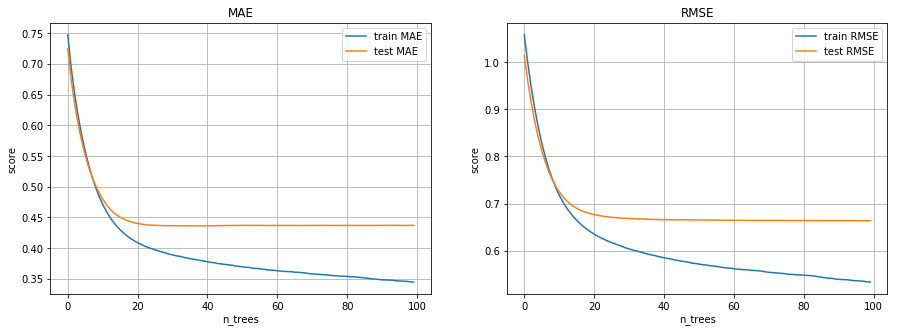

In [302]:
plot_compare(train_eval_mae, 'train MAE', test_eval_mae, 'test MAE', train_eval_rmse, 'train RMSE', test_eval_rmse,
            'test RMSE')

Судя по всему, большое число деревьев не улучшает качество предсказаний, так как после 30 ошибка на тестовых анных перестает значительно падать. Остановимся на переборе меньшего числа деревьев и, возможно, подборе ещё ряда параметров обучения.

Между тем, определим признаки, оказывающие наибольшее влияние на предсказание.

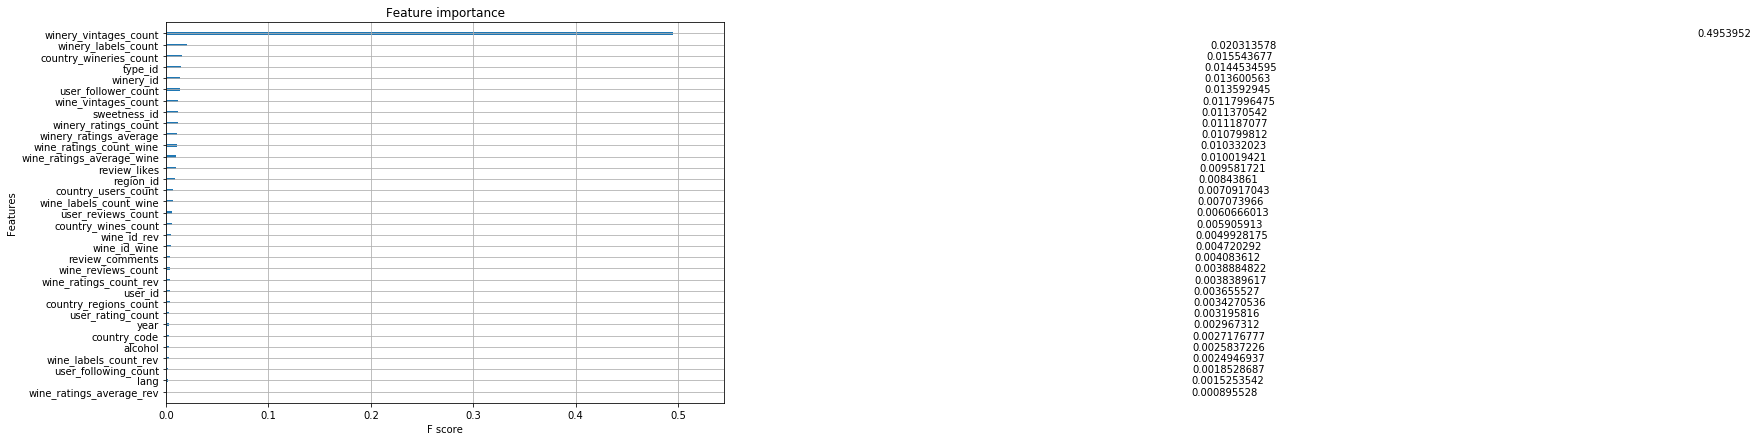

In [303]:
importances = OrderedDict(sorted(importances.items(), key=lambda x: -x[1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xgb.plot_importance(importances, ax=ax)

Таким образом, получили, что xgboost оказывается несколкьо точнее по сравнению с SVD, даже без использования всех признаков, таких как текст и параметры SVD-разложения.

Посмотрим, как изменится качество предсказаний при добавлении некоторых атрибутов матричной факторизации к признакам.

## SVDpp

Библиотека surprise предлагает нам более интересный алгоритм матричной факторизации, который позволяет учитывать набор факторов, отражающий неявные рейтинги (как, например, сам факт того, что пользователь оценил данное вино). Обучим его.

In [304]:
data_train_svd = data_train[['user_id', 'wine_id_wine', 'common_normalized_rating']]
data_train_svd = data_train_svd.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})
svd_test = data_test[['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_test = svd_test.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})

max_rate = data_train_svd['common_normalized_rating'].values.max()
min_rate = data_train_svd['common_normalized_rating'].values.min()

reader = Reader(rating_scale=(min_rate, max_rate))
data = Dataset.load_from_df(data_train_svd, reader)

param_grid_svdpp = {'n_epochs': range(30, 70, 5), 'lr_all': [0.009], 'reg_all': [0.08]}

gs_svdpp = GridSearchCV(SVDpp, param_grid_svdpp, measures=['rmse','mae'], cv=5, n_jobs=4)
gs_svdpp.fit(data)
bestSVDpp = gs_svdpp.best_estimator['mae']

In [305]:
trainset_svdpp = data.build_full_trainset()
bestSVDpp.fit(trainset_svdpp)

In [306]:
mapping_bu_pp = trainset_svdpp.__dict__['_raw2inner_id_users']
mapping_bi_pp = trainset_svdpp.__dict__['_raw2inner_id_items']

In [307]:
bu = bestSVDpp.bu[data_train['user_id'].map(mapping_bu_pp)]
bi = bestSVDpp.bi[data_train['wine_id_wine'].map(mapping_bi_pp)]
yj = bestSVDpp.yj[data_train['wine_id_wine'].map(mapping_bi_pp)]

bu_test = bestSVDpp.bu[data_test['user_id'].map(mapping_bu_pp)]

# с wine_bias-ами придется повозиться, так как в тесте могут быть wine_id, не встретившиеся в обучении. 
wine_map = data_test['wine_id_wine'].map(mapping_bi_pp)    
wine_map[wine_map.isna()] = mapping_bi_pp.get(-1)   # переобозначим их за наше OutOfVocabulary id=-1
wine_map = wine_map.astype(int)
bi_test = bestSVDpp.bi[wine_map]
yj_test = bestSVDpp.yj[wine_map]

In [308]:
def svd_scalar_map_pp(x):    
    y = bestSVDpp.pu[mapping_bu_pp.get(x['user_id'])]
    if mapping_bi_pp.get(x['wine_id_wine']):
        z = bestSVDpp.qi[mapping_bi_pp.get(x['wine_id_wine'])]
    else:
        z = bestSVDpp.qi[mapping_bi_pp.get(-1)]
    return np.dot(y,z)
    
scalar = data_train.apply(svd_scalar_map_pp, axis=1).as_matrix()
scalar_test = data_test.apply(svd_scalar_map_pp, axis=1).as_matrix()

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':
/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.


In [309]:
def svd_sum(x):
    u = bestSVDpp.bu[mapping_bu_pp.get(x['user_id'])]
    if mapping_bi_pp.get(x['wine_id_wine']):
        i = bestSVDpp.bi[mapping_bi_pp.get(x['wine_id_wine'])]
    else:
        i = bestSVDpp.bi[mapping_bi_pp.get(-1)]
    sc = svd_scalar_map_pp(x)
    return (u + i + sc)

svd_sum_train = data_train.apply(svd_sum, axis=1).as_matrix()
svd_sum_test = data_test.apply(svd_sum, axis=1).as_matrix()

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()


In [310]:
X_train, X_test, y_train, y_test = make_X_y()

In [311]:
X_train['user_bias'] = pd.Series(bu, index=X_train.index)
X_train['wine_bias'] = pd.Series(bi, index=X_train.index)

X_test['user_bias'] = pd.Series(bu_test, index=X_test.index)
X_test['wine_bias'] = pd.Series(bi_test, index=X_test.index)

imp_columns = X_train.columns

In [312]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 54) Тест:  (15300, 54)


In [313]:
evals_result_bias, importances_bias = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[14:54:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03132	validation_0-mae:0.735845	validation_1-rmse:1.0197	validation_1-mae:0.729386
[1]	validation_0-rmse:0.945764	validation_0-mae:0.670218	validation_1-rmse:0.971723	validation_1-mae:0.684822
[2]	validation_0-rmse:0.868459	validation_0-mae:0.612045	validation_1-rmse:0.930391	validation_1-mae:0.650159
[3]	validation_0-rmse:0.799352	validation_0-mae:0.560589	validation_1-rmse:0.895705	validation_1-mae:0.621742
[4]	validation_0-rmse:0.736789	validation_0-mae:0.514245	validation_1-rmse:0.866975	validation_1-mae:0.597838
[14:54:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03132	validation_0-mae:0.735845	validation_1-rmse:1.0197	validation_1-mae:0.729386
[1]	validation_0-rmse:0.945764	validation_0-mae:0.670218	validation_1-rmse:0.971723	validati

[19]	validation_0-rmse:0.291626	validation_0-mae:0.185183	validation_1-rmse:0.747066	validation_1-mae:0.487667
[20]	validation_0-rmse:0.279729	validation_0-mae:0.176277	validation_1-rmse:0.746284	validation_1-mae:0.48663
[21]	validation_0-rmse:0.268671	validation_0-mae:0.168142	validation_1-rmse:0.745727	validation_1-mae:0.485997
[22]	validation_0-rmse:0.25888	validation_0-mae:0.160818	validation_1-rmse:0.745177	validation_1-mae:0.485463
[23]	validation_0-rmse:0.249588	validation_0-mae:0.154056	validation_1-rmse:0.745044	validation_1-mae:0.485065
[24]	validation_0-rmse:0.241446	validation_0-mae:0.148005	validation_1-rmse:0.745103	validation_1-mae:0.484913
[14:54:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03132	validation_0-mae:0.735845	validation_1-rmse:1.0197	validation_1-mae:0.729386
[1]	validation_0-rmse:0.945764	validation_0-mae:0.670218	validation_1-rmse:0.971723	validation_1-mae:0

[0]	validation_0-rmse:1.03132	validation_0-mae:0.735845	validation_1-rmse:1.0197	validation_1-mae:0.729386
[1]	validation_0-rmse:0.945764	validation_0-mae:0.670218	validation_1-rmse:0.971723	validation_1-mae:0.684822
[2]	validation_0-rmse:0.868459	validation_0-mae:0.612045	validation_1-rmse:0.930391	validation_1-mae:0.650159
[3]	validation_0-rmse:0.799352	validation_0-mae:0.560589	validation_1-rmse:0.895705	validation_1-mae:0.621742
[4]	validation_0-rmse:0.736789	validation_0-mae:0.514245	validation_1-rmse:0.866975	validation_1-mae:0.597838
[5]	validation_0-rmse:0.680786	validation_0-mae:0.472923	validation_1-rmse:0.843195	validation_1-mae:0.577765
[6]	validation_0-rmse:0.630423	validation_0-mae:0.435938	validation_1-rmse:0.823936	validation_1-mae:0.561033
[7]	validation_0-rmse:0.585352	validation_0-mae:0.402678	validation_1-rmse:0.807849	validation_1-mae:0.546713
[8]	validation_0-rmse:0.544685	validation_0-mae:0.372808	validation_1-rmse:0.794466	validation_1-mae:0.534974
[9]	validatio

[34]	validation_0-rmse:0.184734	validation_0-mae:0.107025	validation_1-rmse:0.745963	validation_1-mae:0.485215
[35]	validation_0-rmse:0.18088	validation_0-mae:0.104371	validation_1-rmse:0.74596	validation_1-mae:0.485238
[36]	validation_0-rmse:0.177078	validation_0-mae:0.101818	validation_1-rmse:0.746129	validation_1-mae:0.485399
[37]	validation_0-rmse:0.173432	validation_0-mae:0.099421	validation_1-rmse:0.746216	validation_1-mae:0.485505
[38]	validation_0-rmse:0.169936	validation_0-mae:0.09714	validation_1-rmse:0.746337	validation_1-mae:0.485651
[39]	validation_0-rmse:0.167386	validation_0-mae:0.095347	validation_1-rmse:0.746495	validation_1-mae:0.485806
[40]	validation_0-rmse:0.164312	validation_0-mae:0.09338	validation_1-rmse:0.746546	validation_1-mae:0.485902
[41]	validation_0-rmse:0.161501	validation_0-mae:0.091564	validation_1-rmse:0.746617	validation_1-mae:0.485984
[42]	validation_0-rmse:0.158914	validation_0-mae:0.089876	validation_1-rmse:0.746701	validation_1-mae:0.486057
[43]	

[11]	validation_0-rmse:0.445633	validation_0-mae:0.299635	validation_1-rmse:0.768496	validation_1-mae:0.510449
[12]	validation_0-rmse:0.419266	validation_0-mae:0.280073	validation_1-rmse:0.763031	validation_1-mae:0.50507
[13]	validation_0-rmse:0.39504	validation_0-mae:0.262146	validation_1-rmse:0.758779	validation_1-mae:0.500965
[14]	validation_0-rmse:0.37363	validation_0-mae:0.246126	validation_1-rmse:0.755121	validation_1-mae:0.497292
[15]	validation_0-rmse:0.353849	validation_0-mae:0.231486	validation_1-rmse:0.752607	validation_1-mae:0.494497
[16]	validation_0-rmse:0.336202	validation_0-mae:0.218317	validation_1-rmse:0.750665	validation_1-mae:0.49218
[17]	validation_0-rmse:0.320028	validation_0-mae:0.206279	validation_1-rmse:0.748922	validation_1-mae:0.490234
[18]	validation_0-rmse:0.305032	validation_0-mae:0.19521	validation_1-rmse:0.748035	validation_1-mae:0.488947
[19]	validation_0-rmse:0.291626	validation_0-mae:0.185183	validation_1-rmse:0.747066	validation_1-mae:0.487667
[20]	v

[29]	validation_0-rmse:0.209033	validation_0-mae:0.124093	validation_1-rmse:0.745204	validation_1-mae:0.484575
[30]	validation_0-rmse:0.20368	validation_0-mae:0.120243	validation_1-rmse:0.745331	validation_1-mae:0.484781
[31]	validation_0-rmse:0.198721	validation_0-mae:0.116719	validation_1-rmse:0.745397	validation_1-mae:0.484862
[32]	validation_0-rmse:0.193586	validation_0-mae:0.113181	validation_1-rmse:0.745659	validation_1-mae:0.485048
[33]	validation_0-rmse:0.189035	validation_0-mae:0.109993	validation_1-rmse:0.745803	validation_1-mae:0.485142
[34]	validation_0-rmse:0.184734	validation_0-mae:0.107025	validation_1-rmse:0.745963	validation_1-mae:0.485215
[35]	validation_0-rmse:0.18088	validation_0-mae:0.104371	validation_1-rmse:0.74596	validation_1-mae:0.485238
[36]	validation_0-rmse:0.177078	validation_0-mae:0.101818	validation_1-rmse:0.746129	validation_1-mae:0.485399
[37]	validation_0-rmse:0.173432	validation_0-mae:0.099421	validation_1-rmse:0.746216	validation_1-mae:0.485505
[38]

[43]	validation_0-rmse:0.156562	validation_0-mae:0.08835	validation_1-rmse:0.746633	validation_1-mae:0.486098
[44]	validation_0-rmse:0.154088	validation_0-mae:0.086822	validation_1-rmse:0.746732	validation_1-mae:0.486162
[45]	validation_0-rmse:0.152251	validation_0-mae:0.085668	validation_1-rmse:0.746868	validation_1-mae:0.486302
[46]	validation_0-rmse:0.150097	validation_0-mae:0.084358	validation_1-rmse:0.746948	validation_1-mae:0.486367
[47]	validation_0-rmse:0.148244	validation_0-mae:0.083175	validation_1-rmse:0.747016	validation_1-mae:0.486434
[48]	validation_0-rmse:0.145795	validation_0-mae:0.081732	validation_1-rmse:0.747091	validation_1-mae:0.486481
[49]	validation_0-rmse:0.14344	validation_0-mae:0.080338	validation_1-rmse:0.747212	validation_1-mae:0.486574
[50]	validation_0-rmse:0.142045	validation_0-mae:0.079394	validation_1-rmse:0.747314	validation_1-mae:0.486673
[51]	validation_0-rmse:0.140214	validation_0-mae:0.078313	validation_1-rmse:0.747451	validation_1-mae:0.486792
[52

[51]	validation_0-rmse:0.140214	validation_0-mae:0.078313	validation_1-rmse:0.747451	validation_1-mae:0.486792
[52]	validation_0-rmse:0.137988	validation_0-mae:0.077119	validation_1-rmse:0.747464	validation_1-mae:0.486838
[53]	validation_0-rmse:0.135917	validation_0-mae:0.075997	validation_1-rmse:0.747524	validation_1-mae:0.486957
[54]	validation_0-rmse:0.134565	validation_0-mae:0.075168	validation_1-rmse:0.747662	validation_1-mae:0.487027
[55]	validation_0-rmse:0.132998	validation_0-mae:0.07423	validation_1-rmse:0.747645	validation_1-mae:0.487036
[56]	validation_0-rmse:0.131612	validation_0-mae:0.073416	validation_1-rmse:0.747565	validation_1-mae:0.487023
[57]	validation_0-rmse:0.130241	validation_0-mae:0.07256	validation_1-rmse:0.7476	validation_1-mae:0.487047
[58]	validation_0-rmse:0.129001	validation_0-mae:0.07184	validation_1-rmse:0.747622	validation_1-mae:0.487074
[59]	validation_0-rmse:0.12741	validation_0-mae:0.070915	validation_1-rmse:0.747613	validation_1-mae:0.487068
[60]	va

[54]	validation_0-rmse:0.134565	validation_0-mae:0.075168	validation_1-rmse:0.747662	validation_1-mae:0.487027
[55]	validation_0-rmse:0.132998	validation_0-mae:0.07423	validation_1-rmse:0.747645	validation_1-mae:0.487036
[56]	validation_0-rmse:0.131612	validation_0-mae:0.073416	validation_1-rmse:0.747565	validation_1-mae:0.487023
[57]	validation_0-rmse:0.130241	validation_0-mae:0.07256	validation_1-rmse:0.7476	validation_1-mae:0.487047
[58]	validation_0-rmse:0.129001	validation_0-mae:0.07184	validation_1-rmse:0.747622	validation_1-mae:0.487074
[59]	validation_0-rmse:0.12741	validation_0-mae:0.070915	validation_1-rmse:0.747613	validation_1-mae:0.487068
[60]	validation_0-rmse:0.125853	validation_0-mae:0.070044	validation_1-rmse:0.747612	validation_1-mae:0.487067
[61]	validation_0-rmse:0.124736	validation_0-mae:0.069328	validation_1-rmse:0.747552	validation_1-mae:0.487042
[62]	validation_0-rmse:0.124137	validation_0-mae:0.068873	validation_1-rmse:0.747545	validation_1-mae:0.487029
[63]	va

[53]	validation_0-rmse:0.135917	validation_0-mae:0.075997	validation_1-rmse:0.747524	validation_1-mae:0.486957
[54]	validation_0-rmse:0.134565	validation_0-mae:0.075168	validation_1-rmse:0.747662	validation_1-mae:0.487027
[55]	validation_0-rmse:0.132998	validation_0-mae:0.07423	validation_1-rmse:0.747645	validation_1-mae:0.487036
[56]	validation_0-rmse:0.131612	validation_0-mae:0.073416	validation_1-rmse:0.747565	validation_1-mae:0.487023
[57]	validation_0-rmse:0.130241	validation_0-mae:0.07256	validation_1-rmse:0.7476	validation_1-mae:0.487047
[58]	validation_0-rmse:0.129001	validation_0-mae:0.07184	validation_1-rmse:0.747622	validation_1-mae:0.487074
[59]	validation_0-rmse:0.12741	validation_0-mae:0.070915	validation_1-rmse:0.747613	validation_1-mae:0.487068
[60]	validation_0-rmse:0.125853	validation_0-mae:0.070044	validation_1-rmse:0.747612	validation_1-mae:0.487067
[61]	validation_0-rmse:0.124736	validation_0-mae:0.069328	validation_1-rmse:0.747552	validation_1-mae:0.487042
[62]	va

[47]	validation_0-rmse:0.148244	validation_0-mae:0.083175	validation_1-rmse:0.747016	validation_1-mae:0.486434
[48]	validation_0-rmse:0.145795	validation_0-mae:0.081732	validation_1-rmse:0.747091	validation_1-mae:0.486481
[49]	validation_0-rmse:0.14344	validation_0-mae:0.080338	validation_1-rmse:0.747212	validation_1-mae:0.486574
[50]	validation_0-rmse:0.142045	validation_0-mae:0.079394	validation_1-rmse:0.747314	validation_1-mae:0.486673
[51]	validation_0-rmse:0.140214	validation_0-mae:0.078313	validation_1-rmse:0.747451	validation_1-mae:0.486792
[52]	validation_0-rmse:0.137988	validation_0-mae:0.077119	validation_1-rmse:0.747464	validation_1-mae:0.486838
[53]	validation_0-rmse:0.135917	validation_0-mae:0.075997	validation_1-rmse:0.747524	validation_1-mae:0.486957
[54]	validation_0-rmse:0.134565	validation_0-mae:0.075168	validation_1-rmse:0.747662	validation_1-mae:0.487027
[55]	validation_0-rmse:0.132998	validation_0-mae:0.07423	validation_1-rmse:0.747645	validation_1-mae:0.487036
[56

[36]	validation_0-rmse:0.177078	validation_0-mae:0.101818	validation_1-rmse:0.746129	validation_1-mae:0.485399
[37]	validation_0-rmse:0.173432	validation_0-mae:0.099421	validation_1-rmse:0.746216	validation_1-mae:0.485505
[38]	validation_0-rmse:0.169936	validation_0-mae:0.09714	validation_1-rmse:0.746337	validation_1-mae:0.485651
[39]	validation_0-rmse:0.167386	validation_0-mae:0.095347	validation_1-rmse:0.746495	validation_1-mae:0.485806
[40]	validation_0-rmse:0.164312	validation_0-mae:0.09338	validation_1-rmse:0.746546	validation_1-mae:0.485902
[41]	validation_0-rmse:0.161501	validation_0-mae:0.091564	validation_1-rmse:0.746617	validation_1-mae:0.485984
[42]	validation_0-rmse:0.158914	validation_0-mae:0.089876	validation_1-rmse:0.746701	validation_1-mae:0.486057
[43]	validation_0-rmse:0.156562	validation_0-mae:0.08835	validation_1-rmse:0.746633	validation_1-mae:0.486098
[44]	validation_0-rmse:0.154088	validation_0-mae:0.086822	validation_1-rmse:0.746732	validation_1-mae:0.486162
[45]

[20]	validation_0-rmse:0.279729	validation_0-mae:0.176277	validation_1-rmse:0.746284	validation_1-mae:0.48663
[21]	validation_0-rmse:0.268671	validation_0-mae:0.168142	validation_1-rmse:0.745727	validation_1-mae:0.485997
[22]	validation_0-rmse:0.25888	validation_0-mae:0.160818	validation_1-rmse:0.745177	validation_1-mae:0.485463
[23]	validation_0-rmse:0.249588	validation_0-mae:0.154056	validation_1-rmse:0.745044	validation_1-mae:0.485065
[24]	validation_0-rmse:0.241446	validation_0-mae:0.148005	validation_1-rmse:0.745103	validation_1-mae:0.484913
[25]	validation_0-rmse:0.234178	validation_0-mae:0.142616	validation_1-rmse:0.745028	validation_1-mae:0.484645
[26]	validation_0-rmse:0.227562	validation_0-mae:0.137638	validation_1-rmse:0.745019	validation_1-mae:0.484427
[27]	validation_0-rmse:0.220753	validation_0-mae:0.132677	validation_1-rmse:0.74519	validation_1-mae:0.484441
[28]	validation_0-rmse:0.214859	validation_0-mae:0.128349	validation_1-rmse:0.745172	validation_1-mae:0.484592
[29]

[15:00:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03132	validation_0-mae:0.735845	validation_1-rmse:1.0197	validation_1-mae:0.729386
[1]	validation_0-rmse:0.945764	validation_0-mae:0.670218	validation_1-rmse:0.971723	validation_1-mae:0.684822
[2]	validation_0-rmse:0.868459	validation_0-mae:0.612045	validation_1-rmse:0.930391	validation_1-mae:0.650159
[3]	validation_0-rmse:0.799352	validation_0-mae:0.560589	validation_1-rmse:0.895705	validation_1-mae:0.621742
[4]	validation_0-rmse:0.736789	validation_0-mae:0.514245	validation_1-rmse:0.866975	validation_1-mae:0.597838
[5]	validation_0-rmse:0.680786	validation_0-mae:0.472923	validation_1-rmse:0.843195	validation_1-mae:0.577765
[6]	validation_0-rmse:0.630423	validation_0-mae:0.435938	validation_1-rmse:0.823936	validation_1-mae:0.561033
[7]	validation_0-rmse:0.585352	validation_0-mae:0.402678	validation_1-rmse:0.807849	validation_1-mae:0.546

[74]	validation_0-rmse:0.114164	validation_0-mae:0.06303	validation_1-rmse:0.747551	validation_1-mae:0.487305
[75]	validation_0-rmse:0.113641	validation_0-mae:0.062637	validation_1-rmse:0.747553	validation_1-mae:0.487312
[76]	validation_0-rmse:0.113081	validation_0-mae:0.062331	validation_1-rmse:0.747554	validation_1-mae:0.48729
[77]	validation_0-rmse:0.112345	validation_0-mae:0.061898	validation_1-rmse:0.747527	validation_1-mae:0.487273
[78]	validation_0-rmse:0.112032	validation_0-mae:0.061676	validation_1-rmse:0.747559	validation_1-mae:0.487293
[79]	validation_0-rmse:0.111848	validation_0-mae:0.061525	validation_1-rmse:0.747586	validation_1-mae:0.487297
[80]	validation_0-rmse:0.111213	validation_0-mae:0.061087	validation_1-rmse:0.747591	validation_1-mae:0.487316
[81]	validation_0-rmse:0.110776	validation_0-mae:0.060852	validation_1-rmse:0.74755	validation_1-mae:0.487294
[82]	validation_0-rmse:0.109948	validation_0-mae:0.060363	validation_1-rmse:0.747537	validation_1-mae:0.48731
[83]	

In [314]:
train_evals_rmse_bias, train_evals_mae_bias, test_evals_rmse_bias, test_evals_mae_bias = show_evals(evals_result_bias)

[0.729386, 0.684822, 0.650159, 0.621742, 0.597838, 0.577765, 0.561033, 0.546713, 0.534974, 0.525027]


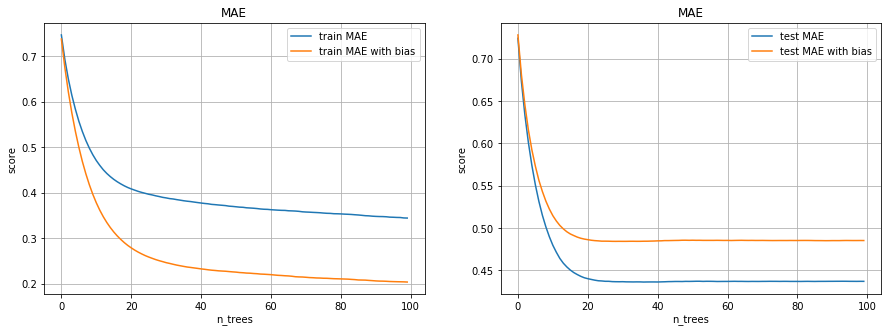

In [315]:
plot_compare(train_eval_mae, 'train MAE', train_eval_mae_bias, 'train MAE with bias', test_eval_mae, 'test MAE', test_eval_mae_bias,
            'test MAE with bias')

In [316]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_scalar'] = pd.Series(scalar, index=X_train.index)
X_test['svd_scalar'] = pd.Series(scalar_test, index=X_test.index)

imp_columns = X_train.columns

In [317]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 53) Тест:  (15300, 53)


In [318]:
evals_result_scalar, importances_scalar = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[15:00:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.03767	validation_0-mae:0.739487	validation_1-rmse:1.02169	validation_1-mae:0.730113
[1]	validation_0-rmse:0.958118	validation_0-mae:0.677511	validation_1-rmse:0.975473	validation_1-mae:0.686436
[2]	validation_0-rmse:0.887099	validation_0-mae:0.622894	validation_1-rmse:0.935646	validation_1-mae:0.652309
[3]	validation_0-rmse:0.823819	validation_0-mae:0.57507	validation_1-rmse:0.902208	validation_1-mae:0.624664
[4]	validation_0-rmse:0.76677	validation_0-mae:0.532176	validation_1-rmse:0.874078	validation_1-mae:0.601345
[15:00:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03767	validation_0-mae:0.739487	validation_1-rmse:1.02169	validation_1-mae:0.730113
[1]	validation_0-rmse:0.958118	validation_0-mae:0.677511	validation_1-rmse:0.975473	validation_1-mae:0.686436
[2]	validation_0-rmse:0.887099	validation_0-mae:0.622894	validation_1-rmse:0.935646	validation_1-mae:0.652309

[21]	validation_0-rmse:0.345392	validation_0-mae:0.221247	validation_1-rmse:0.742201	validation_1-mae:0.490202
[22]	validation_0-rmse:0.336224	validation_0-mae:0.214591	validation_1-rmse:0.741433	validation_1-mae:0.489787
[23]	validation_0-rmse:0.327315	validation_0-mae:0.208359	validation_1-rmse:0.740698	validation_1-mae:0.489536
[24]	validation_0-rmse:0.320166	validation_0-mae:0.202918	validation_1-rmse:0.739873	validation_1-mae:0.489104
[15:01:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03767	validation_0-mae:0.739487	validation_1-rmse:1.02169	validation_1-mae:0.730113
[1]	validation_0-rmse:0.958118	validation_0-mae:0.677511	validation_1-rmse:0.975473	validation_1-mae:0.686436
[2]	validation_0-rmse:0.887099	validation_0-mae:0.622894	validation_1-rmse:0.935646	validation_1-mae:0.652309
[3]	validation_0-rmse:0.823819	validation_0-mae:0.57507	validation_1-rmse:0.902208	validation_1-mae:0

[2]	validation_0-rmse:0.887099	validation_0-mae:0.622894	validation_1-rmse:0.935646	validation_1-mae:0.652309
[3]	validation_0-rmse:0.823819	validation_0-mae:0.57507	validation_1-rmse:0.902208	validation_1-mae:0.624664
[4]	validation_0-rmse:0.76677	validation_0-mae:0.532176	validation_1-rmse:0.874078	validation_1-mae:0.601345
[5]	validation_0-rmse:0.71555	validation_0-mae:0.493873	validation_1-rmse:0.85039	validation_1-mae:0.581696
[6]	validation_0-rmse:0.669711	validation_0-mae:0.459819	validation_1-rmse:0.830822	validation_1-mae:0.565304
[7]	validation_0-rmse:0.629062	validation_0-mae:0.429502	validation_1-rmse:0.81435	validation_1-mae:0.551421
[8]	validation_0-rmse:0.592271	validation_0-mae:0.402442	validation_1-rmse:0.800888	validation_1-mae:0.53998
[9]	validation_0-rmse:0.559697	validation_0-mae:0.37825	validation_1-rmse:0.789443	validation_1-mae:0.530307
[10]	validation_0-rmse:0.530165	validation_0-mae:0.356447	validation_1-rmse:0.780256	validation_1-mae:0.52204
[11]	validation_0

[36]	validation_0-rmse:0.259778	validation_0-mae:0.160337	validation_1-rmse:0.737245	validation_1-mae:0.489918
[37]	validation_0-rmse:0.256871	validation_0-mae:0.158138	validation_1-rmse:0.737082	validation_1-mae:0.489981
[38]	validation_0-rmse:0.25421	validation_0-mae:0.156377	validation_1-rmse:0.737225	validation_1-mae:0.49023
[39]	validation_0-rmse:0.250255	validation_0-mae:0.153867	validation_1-rmse:0.737075	validation_1-mae:0.490235
[40]	validation_0-rmse:0.248315	validation_0-mae:0.152355	validation_1-rmse:0.737052	validation_1-mae:0.490283
[41]	validation_0-rmse:0.245311	validation_0-mae:0.150238	validation_1-rmse:0.737006	validation_1-mae:0.490347
[42]	validation_0-rmse:0.242365	validation_0-mae:0.14848	validation_1-rmse:0.737077	validation_1-mae:0.490487
[43]	validation_0-rmse:0.239297	validation_0-mae:0.146484	validation_1-rmse:0.737061	validation_1-mae:0.49051
[44]	validation_0-rmse:0.237459	validation_0-mae:0.145132	validation_1-rmse:0.737028	validation_1-mae:0.49044
[15:02

[14]	validation_0-rmse:0.438857	validation_0-mae:0.289006	validation_1-rmse:0.756777	validation_1-mae:0.501131
[15]	validation_0-rmse:0.421029	validation_0-mae:0.275972	validation_1-rmse:0.75325	validation_1-mae:0.498243
[16]	validation_0-rmse:0.405806	validation_0-mae:0.264785	validation_1-rmse:0.750421	validation_1-mae:0.495936
[17]	validation_0-rmse:0.391052	validation_0-mae:0.254135	validation_1-rmse:0.748047	validation_1-mae:0.494133
[18]	validation_0-rmse:0.377872	validation_0-mae:0.244573	validation_1-rmse:0.745927	validation_1-mae:0.492481
[19]	validation_0-rmse:0.366159	validation_0-mae:0.236141	validation_1-rmse:0.744318	validation_1-mae:0.491367
[20]	validation_0-rmse:0.355143	validation_0-mae:0.228195	validation_1-rmse:0.743249	validation_1-mae:0.490772
[21]	validation_0-rmse:0.345392	validation_0-mae:0.221247	validation_1-rmse:0.742201	validation_1-mae:0.490202
[22]	validation_0-rmse:0.336224	validation_0-mae:0.214591	validation_1-rmse:0.741433	validation_1-mae:0.489787
[2

[33]	validation_0-rmse:0.270713	validation_0-mae:0.167909	validation_1-rmse:0.737641	validation_1-mae:0.489725
[34]	validation_0-rmse:0.267227	validation_0-mae:0.165375	validation_1-rmse:0.737458	validation_1-mae:0.489795
[35]	validation_0-rmse:0.263085	validation_0-mae:0.162544	validation_1-rmse:0.737313	validation_1-mae:0.4899
[36]	validation_0-rmse:0.259778	validation_0-mae:0.160337	validation_1-rmse:0.737245	validation_1-mae:0.489918
[37]	validation_0-rmse:0.256871	validation_0-mae:0.158138	validation_1-rmse:0.737082	validation_1-mae:0.489981
[38]	validation_0-rmse:0.25421	validation_0-mae:0.156377	validation_1-rmse:0.737225	validation_1-mae:0.49023
[39]	validation_0-rmse:0.250255	validation_0-mae:0.153867	validation_1-rmse:0.737075	validation_1-mae:0.490235
[40]	validation_0-rmse:0.248315	validation_0-mae:0.152355	validation_1-rmse:0.737052	validation_1-mae:0.490283
[41]	validation_0-rmse:0.245311	validation_0-mae:0.150238	validation_1-rmse:0.737006	validation_1-mae:0.490347
[42]	

[47]	validation_0-rmse:0.232201	validation_0-mae:0.14138	validation_1-rmse:0.736878	validation_1-mae:0.490677
[48]	validation_0-rmse:0.230439	validation_0-mae:0.140237	validation_1-rmse:0.73677	validation_1-mae:0.490714
[49]	validation_0-rmse:0.227763	validation_0-mae:0.138632	validation_1-rmse:0.736634	validation_1-mae:0.490672
[50]	validation_0-rmse:0.225999	validation_0-mae:0.137472	validation_1-rmse:0.736604	validation_1-mae:0.490686
[51]	validation_0-rmse:0.223819	validation_0-mae:0.135991	validation_1-rmse:0.736536	validation_1-mae:0.490692
[52]	validation_0-rmse:0.22181	validation_0-mae:0.134754	validation_1-rmse:0.736388	validation_1-mae:0.490594
[53]	validation_0-rmse:0.21923	validation_0-mae:0.133209	validation_1-rmse:0.736482	validation_1-mae:0.49069
[54]	validation_0-rmse:0.21728	validation_0-mae:0.131974	validation_1-rmse:0.736456	validation_1-mae:0.490695
[55]	validation_0-rmse:0.216471	validation_0-mae:0.131279	validation_1-rmse:0.736372	validation_1-mae:0.490641
[56]	va

[56]	validation_0-rmse:0.215236	validation_0-mae:0.130516	validation_1-rmse:0.736404	validation_1-mae:0.490725
[57]	validation_0-rmse:0.214227	validation_0-mae:0.129858	validation_1-rmse:0.736344	validation_1-mae:0.49073
[58]	validation_0-rmse:0.212888	validation_0-mae:0.12906	validation_1-rmse:0.736362	validation_1-mae:0.490752
[59]	validation_0-rmse:0.211283	validation_0-mae:0.127944	validation_1-rmse:0.736303	validation_1-mae:0.490699
[60]	validation_0-rmse:0.210688	validation_0-mae:0.127567	validation_1-rmse:0.736297	validation_1-mae:0.490723
[61]	validation_0-rmse:0.209482	validation_0-mae:0.126679	validation_1-rmse:0.736273	validation_1-mae:0.49067
[62]	validation_0-rmse:0.207895	validation_0-mae:0.125466	validation_1-rmse:0.736252	validation_1-mae:0.490656
[63]	validation_0-rmse:0.20697	validation_0-mae:0.124921	validation_1-rmse:0.736288	validation_1-mae:0.490707
[64]	validation_0-rmse:0.205757	validation_0-mae:0.124042	validation_1-rmse:0.736225	validation_1-mae:0.49069
[65]	v

[60]	validation_0-rmse:0.210688	validation_0-mae:0.127567	validation_1-rmse:0.736297	validation_1-mae:0.490723
[61]	validation_0-rmse:0.209482	validation_0-mae:0.126679	validation_1-rmse:0.736273	validation_1-mae:0.49067
[62]	validation_0-rmse:0.207895	validation_0-mae:0.125466	validation_1-rmse:0.736252	validation_1-mae:0.490656
[63]	validation_0-rmse:0.20697	validation_0-mae:0.124921	validation_1-rmse:0.736288	validation_1-mae:0.490707
[64]	validation_0-rmse:0.205757	validation_0-mae:0.124042	validation_1-rmse:0.736225	validation_1-mae:0.49069
[65]	validation_0-rmse:0.205294	validation_0-mae:0.123559	validation_1-rmse:0.736172	validation_1-mae:0.490655
[66]	validation_0-rmse:0.204238	validation_0-mae:0.12299	validation_1-rmse:0.736173	validation_1-mae:0.490685
[67]	validation_0-rmse:0.202566	validation_0-mae:0.122015	validation_1-rmse:0.736187	validation_1-mae:0.490736
[68]	validation_0-rmse:0.20109	validation_0-mae:0.120937	validation_1-rmse:0.736122	validation_1-mae:0.490651
[69]	v

[59]	validation_0-rmse:0.211283	validation_0-mae:0.127944	validation_1-rmse:0.736303	validation_1-mae:0.490699
[60]	validation_0-rmse:0.210688	validation_0-mae:0.127567	validation_1-rmse:0.736297	validation_1-mae:0.490723
[61]	validation_0-rmse:0.209482	validation_0-mae:0.126679	validation_1-rmse:0.736273	validation_1-mae:0.49067
[62]	validation_0-rmse:0.207895	validation_0-mae:0.125466	validation_1-rmse:0.736252	validation_1-mae:0.490656
[63]	validation_0-rmse:0.20697	validation_0-mae:0.124921	validation_1-rmse:0.736288	validation_1-mae:0.490707
[64]	validation_0-rmse:0.205757	validation_0-mae:0.124042	validation_1-rmse:0.736225	validation_1-mae:0.49069
[65]	validation_0-rmse:0.205294	validation_0-mae:0.123559	validation_1-rmse:0.736172	validation_1-mae:0.490655
[66]	validation_0-rmse:0.204238	validation_0-mae:0.12299	validation_1-rmse:0.736173	validation_1-mae:0.490685
[67]	validation_0-rmse:0.202566	validation_0-mae:0.122015	validation_1-rmse:0.736187	validation_1-mae:0.490736
[68]	

[53]	validation_0-rmse:0.21923	validation_0-mae:0.133209	validation_1-rmse:0.736482	validation_1-mae:0.49069
[54]	validation_0-rmse:0.21728	validation_0-mae:0.131974	validation_1-rmse:0.736456	validation_1-mae:0.490695
[55]	validation_0-rmse:0.216471	validation_0-mae:0.131279	validation_1-rmse:0.736372	validation_1-mae:0.490641
[56]	validation_0-rmse:0.215236	validation_0-mae:0.130516	validation_1-rmse:0.736404	validation_1-mae:0.490725
[57]	validation_0-rmse:0.214227	validation_0-mae:0.129858	validation_1-rmse:0.736344	validation_1-mae:0.49073
[58]	validation_0-rmse:0.212888	validation_0-mae:0.12906	validation_1-rmse:0.736362	validation_1-mae:0.490752
[59]	validation_0-rmse:0.211283	validation_0-mae:0.127944	validation_1-rmse:0.736303	validation_1-mae:0.490699
[60]	validation_0-rmse:0.210688	validation_0-mae:0.127567	validation_1-rmse:0.736297	validation_1-mae:0.490723
[61]	validation_0-rmse:0.209482	validation_0-mae:0.126679	validation_1-rmse:0.736273	validation_1-mae:0.49067
[62]	va

[42]	validation_0-rmse:0.242365	validation_0-mae:0.14848	validation_1-rmse:0.737077	validation_1-mae:0.490487
[43]	validation_0-rmse:0.239297	validation_0-mae:0.146484	validation_1-rmse:0.737061	validation_1-mae:0.49051
[44]	validation_0-rmse:0.237459	validation_0-mae:0.145132	validation_1-rmse:0.737028	validation_1-mae:0.49044
[45]	validation_0-rmse:0.235157	validation_0-mae:0.143654	validation_1-rmse:0.736983	validation_1-mae:0.490585
[46]	validation_0-rmse:0.233696	validation_0-mae:0.142456	validation_1-rmse:0.736908	validation_1-mae:0.490589
[47]	validation_0-rmse:0.232201	validation_0-mae:0.14138	validation_1-rmse:0.736878	validation_1-mae:0.490677
[48]	validation_0-rmse:0.230439	validation_0-mae:0.140237	validation_1-rmse:0.73677	validation_1-mae:0.490714
[49]	validation_0-rmse:0.227763	validation_0-mae:0.138632	validation_1-rmse:0.736634	validation_1-mae:0.490672
[50]	validation_0-rmse:0.225999	validation_0-mae:0.137472	validation_1-rmse:0.736604	validation_1-mae:0.490686
[51]	v

[26]	validation_0-rmse:0.306946	validation_0-mae:0.193227	validation_1-rmse:0.738932	validation_1-mae:0.489018
[27]	validation_0-rmse:0.30071	validation_0-mae:0.188847	validation_1-rmse:0.738699	validation_1-mae:0.489049
[28]	validation_0-rmse:0.294454	validation_0-mae:0.184546	validation_1-rmse:0.738427	validation_1-mae:0.489121
[29]	validation_0-rmse:0.289598	validation_0-mae:0.18092	validation_1-rmse:0.738062	validation_1-mae:0.48903
[30]	validation_0-rmse:0.285065	validation_0-mae:0.177715	validation_1-rmse:0.738041	validation_1-mae:0.489296
[31]	validation_0-rmse:0.280744	validation_0-mae:0.174591	validation_1-rmse:0.737869	validation_1-mae:0.489448
[32]	validation_0-rmse:0.276151	validation_0-mae:0.171318	validation_1-rmse:0.737721	validation_1-mae:0.489602
[33]	validation_0-rmse:0.270713	validation_0-mae:0.167909	validation_1-rmse:0.737641	validation_1-mae:0.489725
[34]	validation_0-rmse:0.267227	validation_0-mae:0.165375	validation_1-rmse:0.737458	validation_1-mae:0.489795
[35]

[5]	validation_0-rmse:0.71555	validation_0-mae:0.493873	validation_1-rmse:0.85039	validation_1-mae:0.581696
[6]	validation_0-rmse:0.669711	validation_0-mae:0.459819	validation_1-rmse:0.830822	validation_1-mae:0.565304
[7]	validation_0-rmse:0.629062	validation_0-mae:0.429502	validation_1-rmse:0.81435	validation_1-mae:0.551421
[8]	validation_0-rmse:0.592271	validation_0-mae:0.402442	validation_1-rmse:0.800888	validation_1-mae:0.53998
[9]	validation_0-rmse:0.559697	validation_0-mae:0.37825	validation_1-rmse:0.789443	validation_1-mae:0.530307
[10]	validation_0-rmse:0.530165	validation_0-mae:0.356447	validation_1-rmse:0.780256	validation_1-mae:0.52204
[11]	validation_0-rmse:0.503423	validation_0-mae:0.336535	validation_1-rmse:0.772347	validation_1-mae:0.514733
[12]	validation_0-rmse:0.479875	validation_0-mae:0.31904	validation_1-rmse:0.766209	validation_1-mae:0.509289
[13]	validation_0-rmse:0.458488	validation_0-mae:0.303357	validation_1-rmse:0.760912	validation_1-mae:0.504826
[14]	validati

[80]	validation_0-rmse:0.189021	validation_0-mae:0.112842	validation_1-rmse:0.735745	validation_1-mae:0.49046
[81]	validation_0-rmse:0.188604	validation_0-mae:0.112464	validation_1-rmse:0.735708	validation_1-mae:0.490435
[82]	validation_0-rmse:0.187767	validation_0-mae:0.111948	validation_1-rmse:0.735661	validation_1-mae:0.4904
[83]	validation_0-rmse:0.186677	validation_0-mae:0.111383	validation_1-rmse:0.735618	validation_1-mae:0.490429
[84]	validation_0-rmse:0.186287	validation_0-mae:0.111015	validation_1-rmse:0.735533	validation_1-mae:0.490356
[85]	validation_0-rmse:0.186062	validation_0-mae:0.110828	validation_1-rmse:0.735531	validation_1-mae:0.490365
[86]	validation_0-rmse:0.185094	validation_0-mae:0.110017	validation_1-rmse:0.735466	validation_1-mae:0.490338
[87]	validation_0-rmse:0.184629	validation_0-mae:0.109764	validation_1-rmse:0.735408	validation_1-mae:0.490305
[88]	validation_0-rmse:0.183517	validation_0-mae:0.109084	validation_1-rmse:0.735287	validation_1-mae:0.49023
[89]	

[0.730113, 0.686436, 0.652309, 0.624664, 0.601345, 0.581696, 0.565304, 0.551421, 0.53998, 0.530307]


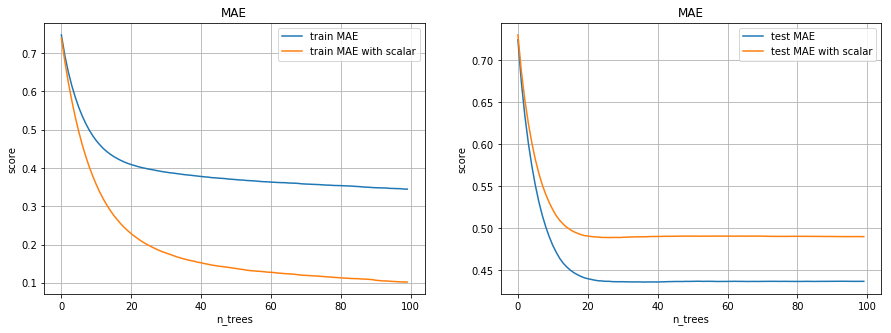

In [321]:
train_eval_rmse_scalar, train_eval_mae_scalar, test_eval_rmse_scalar, test_eval_mae_scalar = show_evals(evals_result_scalar)
plot_compare(train_eval_mae, 'train MAE', train_eval_mae_scalar, 'train MAE with scalar', test_eval_mae, 'test MAE', 
             test_eval_mae_scalar, 'test MAE with scalar')

In [322]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_sum'] = pd.Series(svd_sum_train, index=X_train.index)
X_test['svd_sum'] = pd.Series(svd_sum_test, index=X_test.index)

imp_columns = X_train.columns

In [323]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 53) 		Тест:  (15300, 53)


In [324]:
evals_result_sum, importances_sum = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[15:15:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.03025	validation_0-mae:0.73528	validation_1-rmse:1.02097	validation_1-mae:0.730546
[1]	validation_0-rmse:0.943989	validation_0-mae:0.669166	validation_1-rmse:0.974167	validation_1-mae:0.686723
[2]	validation_0-rmse:0.866424	validation_0-mae:0.611117	validation_1-rmse:0.934764	validation_1-mae:0.653399
[3]	validation_0-rmse:0.796602	validation_0-mae:0.559771	validation_1-rmse:0.901868	validation_1-mae:0.626906
[4]	validation_0-rmse:0.734035	validation_0-mae:0.514118	validation_1-rmse:0.874534	validation_1-mae:0.604585
[15:15:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03025	validation_0-mae:0.73528	validation_1-rmse:1.02097	validation_1-mae:0.730546
[1]	validation_0-rmse:0.943989	validation_0-mae:0.669166	validation_1-rmse:0.974167	validation_1-mae:0.686723
[2]	validation_0-rmse:0.866424	validation_0-mae:0.611117	validation_1-rmse:0.934764	validation_1-mae:0.653399

[21]	validation_0-rmse:0.270268	validation_0-mae:0.174425	validation_1-rmse:0.754382	validation_1-mae:0.495116
[22]	validation_0-rmse:0.260492	validation_0-mae:0.167008	validation_1-rmse:0.753879	validation_1-mae:0.494482
[23]	validation_0-rmse:0.251383	validation_0-mae:0.160163	validation_1-rmse:0.753319	validation_1-mae:0.493819
[24]	validation_0-rmse:0.243469	validation_0-mae:0.154272	validation_1-rmse:0.752945	validation_1-mae:0.493309
[15:15:37] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.03025	validation_0-mae:0.73528	validation_1-rmse:1.02097	validation_1-mae:0.730546
[1]	validation_0-rmse:0.943989	validation_0-mae:0.669166	validation_1-rmse:0.974167	validation_1-mae:0.686723
[2]	validation_0-rmse:0.866424	validation_0-mae:0.611117	validation_1-rmse:0.934764	validation_1-mae:0.653399
[3]	validation_0-rmse:0.796602	validation_0-mae:0.559771	validation_1-rmse:0.901868	validation_1-mae:0

[2]	validation_0-rmse:0.866424	validation_0-mae:0.611117	validation_1-rmse:0.934764	validation_1-mae:0.653399
[3]	validation_0-rmse:0.796602	validation_0-mae:0.559771	validation_1-rmse:0.901868	validation_1-mae:0.626906
[4]	validation_0-rmse:0.734035	validation_0-mae:0.514118	validation_1-rmse:0.874534	validation_1-mae:0.604585
[5]	validation_0-rmse:0.677862	validation_0-mae:0.473259	validation_1-rmse:0.851826	validation_1-mae:0.585563
[6]	validation_0-rmse:0.62782	validation_0-mae:0.43713	validation_1-rmse:0.83316	validation_1-mae:0.569391
[7]	validation_0-rmse:0.58268	validation_0-mae:0.404295	validation_1-rmse:0.817974	validation_1-mae:0.555877
[8]	validation_0-rmse:0.54217	validation_0-mae:0.375036	validation_1-rmse:0.805547	validation_1-mae:0.544855
[9]	validation_0-rmse:0.505798	validation_0-mae:0.348633	validation_1-rmse:0.795461	validation_1-mae:0.535796
[10]	validation_0-rmse:0.472993	validation_0-mae:0.324778	validation_1-rmse:0.786735	validation_1-mae:0.528046
[11]	validatio

[36]	validation_0-rmse:0.182778	validation_0-mae:0.109886	validation_1-rmse:0.752418	validation_1-mae:0.492497
[37]	validation_0-rmse:0.179583	validation_0-mae:0.107662	validation_1-rmse:0.752449	validation_1-mae:0.492551
[38]	validation_0-rmse:0.176629	validation_0-mae:0.10559	validation_1-rmse:0.752492	validation_1-mae:0.492604
[39]	validation_0-rmse:0.174193	validation_0-mae:0.103816	validation_1-rmse:0.75251	validation_1-mae:0.492594
[40]	validation_0-rmse:0.171649	validation_0-mae:0.102038	validation_1-rmse:0.752526	validation_1-mae:0.492676
[41]	validation_0-rmse:0.168852	validation_0-mae:0.100181	validation_1-rmse:0.752541	validation_1-mae:0.492697
[42]	validation_0-rmse:0.167057	validation_0-mae:0.098875	validation_1-rmse:0.752444	validation_1-mae:0.492653
[43]	validation_0-rmse:0.16557	validation_0-mae:0.097857	validation_1-rmse:0.752465	validation_1-mae:0.492703
[44]	validation_0-rmse:0.163399	validation_0-mae:0.096397	validation_1-rmse:0.752563	validation_1-mae:0.492896
[15:

[14]	validation_0-rmse:0.371378	validation_0-mae:0.250051	validation_1-rmse:0.765819	validation_1-mae:0.507951
[15]	validation_0-rmse:0.35216	validation_0-mae:0.235775	validation_1-rmse:0.763049	validation_1-mae:0.505043
[16]	validation_0-rmse:0.334956	validation_0-mae:0.222952	validation_1-rmse:0.760748	validation_1-mae:0.50266
[17]	validation_0-rmse:0.319323	validation_0-mae:0.211273	validation_1-rmse:0.758912	validation_1-mae:0.500725
[18]	validation_0-rmse:0.305365	validation_0-mae:0.200731	validation_1-rmse:0.75726	validation_1-mae:0.498864
[19]	validation_0-rmse:0.292526	validation_0-mae:0.191142	validation_1-rmse:0.756032	validation_1-mae:0.497314
[20]	validation_0-rmse:0.280944	validation_0-mae:0.182337	validation_1-rmse:0.755079	validation_1-mae:0.496048
[21]	validation_0-rmse:0.270268	validation_0-mae:0.174425	validation_1-rmse:0.754382	validation_1-mae:0.495116
[22]	validation_0-rmse:0.260492	validation_0-mae:0.167008	validation_1-rmse:0.753879	validation_1-mae:0.494482
[23]

[33]	validation_0-rmse:0.193568	validation_0-mae:0.117458	validation_1-rmse:0.752399	validation_1-mae:0.492408
[34]	validation_0-rmse:0.189943	validation_0-mae:0.114769	validation_1-rmse:0.752527	validation_1-mae:0.492487
[35]	validation_0-rmse:0.185875	validation_0-mae:0.11202	validation_1-rmse:0.752458	validation_1-mae:0.49248
[36]	validation_0-rmse:0.182778	validation_0-mae:0.109886	validation_1-rmse:0.752418	validation_1-mae:0.492497
[37]	validation_0-rmse:0.179583	validation_0-mae:0.107662	validation_1-rmse:0.752449	validation_1-mae:0.492551
[38]	validation_0-rmse:0.176629	validation_0-mae:0.10559	validation_1-rmse:0.752492	validation_1-mae:0.492604
[39]	validation_0-rmse:0.174193	validation_0-mae:0.103816	validation_1-rmse:0.75251	validation_1-mae:0.492594
[40]	validation_0-rmse:0.171649	validation_0-mae:0.102038	validation_1-rmse:0.752526	validation_1-mae:0.492676
[41]	validation_0-rmse:0.168852	validation_0-mae:0.100181	validation_1-rmse:0.752541	validation_1-mae:0.492697
[42]	

[47]	validation_0-rmse:0.157962	validation_0-mae:0.09275	validation_1-rmse:0.752482	validation_1-mae:0.492806
[48]	validation_0-rmse:0.15601	validation_0-mae:0.091525	validation_1-rmse:0.75253	validation_1-mae:0.492829
[49]	validation_0-rmse:0.154206	validation_0-mae:0.09037	validation_1-rmse:0.752567	validation_1-mae:0.492844
[50]	validation_0-rmse:0.153232	validation_0-mae:0.089695	validation_1-rmse:0.752582	validation_1-mae:0.492882
[51]	validation_0-rmse:0.152	validation_0-mae:0.088862	validation_1-rmse:0.752561	validation_1-mae:0.492825
[52]	validation_0-rmse:0.150132	validation_0-mae:0.08778	validation_1-rmse:0.752618	validation_1-mae:0.492859
[53]	validation_0-rmse:0.147989	validation_0-mae:0.086562	validation_1-rmse:0.75268	validation_1-mae:0.492967
[54]	validation_0-rmse:0.146505	validation_0-mae:0.08567	validation_1-rmse:0.752724	validation_1-mae:0.493019
[55]	validation_0-rmse:0.145035	validation_0-mae:0.084855	validation_1-rmse:0.752694	validation_1-mae:0.493055
[56]	valida

[56]	validation_0-rmse:0.143274	validation_0-mae:0.083833	validation_1-rmse:0.752708	validation_1-mae:0.493081
[57]	validation_0-rmse:0.142237	validation_0-mae:0.083237	validation_1-rmse:0.752697	validation_1-mae:0.493131
[58]	validation_0-rmse:0.14135	validation_0-mae:0.082695	validation_1-rmse:0.75274	validation_1-mae:0.493152
[59]	validation_0-rmse:0.139877	validation_0-mae:0.081828	validation_1-rmse:0.752753	validation_1-mae:0.493249
[60]	validation_0-rmse:0.139056	validation_0-mae:0.081313	validation_1-rmse:0.75277	validation_1-mae:0.493268
[61]	validation_0-rmse:0.138406	validation_0-mae:0.080906	validation_1-rmse:0.752717	validation_1-mae:0.493249
[62]	validation_0-rmse:0.1375	validation_0-mae:0.080388	validation_1-rmse:0.7527	validation_1-mae:0.493217
[63]	validation_0-rmse:0.136831	validation_0-mae:0.079972	validation_1-rmse:0.75271	validation_1-mae:0.493246
[64]	validation_0-rmse:0.136041	validation_0-mae:0.07949	validation_1-rmse:0.752701	validation_1-mae:0.493222
[65]	valid

[60]	validation_0-rmse:0.139056	validation_0-mae:0.081313	validation_1-rmse:0.75277	validation_1-mae:0.493268
[61]	validation_0-rmse:0.138406	validation_0-mae:0.080906	validation_1-rmse:0.752717	validation_1-mae:0.493249
[62]	validation_0-rmse:0.1375	validation_0-mae:0.080388	validation_1-rmse:0.7527	validation_1-mae:0.493217
[63]	validation_0-rmse:0.136831	validation_0-mae:0.079972	validation_1-rmse:0.75271	validation_1-mae:0.493246
[64]	validation_0-rmse:0.136041	validation_0-mae:0.07949	validation_1-rmse:0.752701	validation_1-mae:0.493222
[65]	validation_0-rmse:0.135247	validation_0-mae:0.07898	validation_1-rmse:0.75268	validation_1-mae:0.493199
[66]	validation_0-rmse:0.134103	validation_0-mae:0.07828	validation_1-rmse:0.752637	validation_1-mae:0.493214
[67]	validation_0-rmse:0.133357	validation_0-mae:0.07785	validation_1-rmse:0.752598	validation_1-mae:0.493185
[68]	validation_0-rmse:0.13274	validation_0-mae:0.077482	validation_1-rmse:0.752554	validation_1-mae:0.493156
[69]	validati

[59]	validation_0-rmse:0.139877	validation_0-mae:0.081828	validation_1-rmse:0.752753	validation_1-mae:0.493249
[60]	validation_0-rmse:0.139056	validation_0-mae:0.081313	validation_1-rmse:0.75277	validation_1-mae:0.493268
[61]	validation_0-rmse:0.138406	validation_0-mae:0.080906	validation_1-rmse:0.752717	validation_1-mae:0.493249
[62]	validation_0-rmse:0.1375	validation_0-mae:0.080388	validation_1-rmse:0.7527	validation_1-mae:0.493217
[63]	validation_0-rmse:0.136831	validation_0-mae:0.079972	validation_1-rmse:0.75271	validation_1-mae:0.493246
[64]	validation_0-rmse:0.136041	validation_0-mae:0.07949	validation_1-rmse:0.752701	validation_1-mae:0.493222
[65]	validation_0-rmse:0.135247	validation_0-mae:0.07898	validation_1-rmse:0.75268	validation_1-mae:0.493199
[66]	validation_0-rmse:0.134103	validation_0-mae:0.07828	validation_1-rmse:0.752637	validation_1-mae:0.493214
[67]	validation_0-rmse:0.133357	validation_0-mae:0.07785	validation_1-rmse:0.752598	validation_1-mae:0.493185
[68]	validat

[53]	validation_0-rmse:0.147989	validation_0-mae:0.086562	validation_1-rmse:0.75268	validation_1-mae:0.492967
[54]	validation_0-rmse:0.146505	validation_0-mae:0.08567	validation_1-rmse:0.752724	validation_1-mae:0.493019
[55]	validation_0-rmse:0.145035	validation_0-mae:0.084855	validation_1-rmse:0.752694	validation_1-mae:0.493055
[56]	validation_0-rmse:0.143274	validation_0-mae:0.083833	validation_1-rmse:0.752708	validation_1-mae:0.493081
[57]	validation_0-rmse:0.142237	validation_0-mae:0.083237	validation_1-rmse:0.752697	validation_1-mae:0.493131
[58]	validation_0-rmse:0.14135	validation_0-mae:0.082695	validation_1-rmse:0.75274	validation_1-mae:0.493152
[59]	validation_0-rmse:0.139877	validation_0-mae:0.081828	validation_1-rmse:0.752753	validation_1-mae:0.493249
[60]	validation_0-rmse:0.139056	validation_0-mae:0.081313	validation_1-rmse:0.75277	validation_1-mae:0.493268
[61]	validation_0-rmse:0.138406	validation_0-mae:0.080906	validation_1-rmse:0.752717	validation_1-mae:0.493249
[62]	v

[42]	validation_0-rmse:0.167057	validation_0-mae:0.098875	validation_1-rmse:0.752444	validation_1-mae:0.492653
[43]	validation_0-rmse:0.16557	validation_0-mae:0.097857	validation_1-rmse:0.752465	validation_1-mae:0.492703
[44]	validation_0-rmse:0.163399	validation_0-mae:0.096397	validation_1-rmse:0.752563	validation_1-mae:0.492896
[45]	validation_0-rmse:0.161392	validation_0-mae:0.095072	validation_1-rmse:0.752538	validation_1-mae:0.492915
[46]	validation_0-rmse:0.15958	validation_0-mae:0.09386	validation_1-rmse:0.752517	validation_1-mae:0.492826
[47]	validation_0-rmse:0.157962	validation_0-mae:0.09275	validation_1-rmse:0.752482	validation_1-mae:0.492806
[48]	validation_0-rmse:0.15601	validation_0-mae:0.091525	validation_1-rmse:0.75253	validation_1-mae:0.492829
[49]	validation_0-rmse:0.154206	validation_0-mae:0.09037	validation_1-rmse:0.752567	validation_1-mae:0.492844
[50]	validation_0-rmse:0.153232	validation_0-mae:0.089695	validation_1-rmse:0.752582	validation_1-mae:0.492882
[51]	val

[26]	validation_0-rmse:0.229281	validation_0-mae:0.14363	validation_1-rmse:0.75238	validation_1-mae:0.492517
[27]	validation_0-rmse:0.223086	validation_0-mae:0.139025	validation_1-rmse:0.752296	validation_1-mae:0.492443
[28]	validation_0-rmse:0.217437	validation_0-mae:0.134745	validation_1-rmse:0.752306	validation_1-mae:0.492387
[29]	validation_0-rmse:0.211925	validation_0-mae:0.130788	validation_1-rmse:0.752334	validation_1-mae:0.492433
[30]	validation_0-rmse:0.206387	validation_0-mae:0.126672	validation_1-rmse:0.75235	validation_1-mae:0.492357
[31]	validation_0-rmse:0.201871	validation_0-mae:0.123387	validation_1-rmse:0.752371	validation_1-mae:0.492382
[32]	validation_0-rmse:0.19736	validation_0-mae:0.120229	validation_1-rmse:0.752367	validation_1-mae:0.492361
[33]	validation_0-rmse:0.193568	validation_0-mae:0.117458	validation_1-rmse:0.752399	validation_1-mae:0.492408
[34]	validation_0-rmse:0.189943	validation_0-mae:0.114769	validation_1-rmse:0.752527	validation_1-mae:0.492487
[35]	

[5]	validation_0-rmse:0.677862	validation_0-mae:0.473259	validation_1-rmse:0.851826	validation_1-mae:0.585563
[6]	validation_0-rmse:0.62782	validation_0-mae:0.43713	validation_1-rmse:0.83316	validation_1-mae:0.569391
[7]	validation_0-rmse:0.58268	validation_0-mae:0.404295	validation_1-rmse:0.817974	validation_1-mae:0.555877
[8]	validation_0-rmse:0.54217	validation_0-mae:0.375036	validation_1-rmse:0.805547	validation_1-mae:0.544855
[9]	validation_0-rmse:0.505798	validation_0-mae:0.348633	validation_1-rmse:0.795461	validation_1-mae:0.535796
[10]	validation_0-rmse:0.472993	validation_0-mae:0.324778	validation_1-rmse:0.786735	validation_1-mae:0.528046
[11]	validation_0-rmse:0.443372	validation_0-mae:0.303132	validation_1-rmse:0.779668	validation_1-mae:0.521533
[12]	validation_0-rmse:0.416735	validation_0-mae:0.283594	validation_1-rmse:0.774027	validation_1-mae:0.516221
[13]	validation_0-rmse:0.392866	validation_0-mae:0.26602	validation_1-rmse:0.769671	validation_1-mae:0.511934
[14]	validat

[80]	validation_0-rmse:0.125172	validation_0-mae:0.073031	validation_1-rmse:0.752347	validation_1-mae:0.493084
[81]	validation_0-rmse:0.12419	validation_0-mae:0.072456	validation_1-rmse:0.752326	validation_1-mae:0.493094
[82]	validation_0-rmse:0.123931	validation_0-mae:0.072268	validation_1-rmse:0.75233	validation_1-mae:0.493101
[83]	validation_0-rmse:0.122886	validation_0-mae:0.071669	validation_1-rmse:0.752286	validation_1-mae:0.493112
[84]	validation_0-rmse:0.121722	validation_0-mae:0.071068	validation_1-rmse:0.752308	validation_1-mae:0.49313
[85]	validation_0-rmse:0.12161	validation_0-mae:0.070966	validation_1-rmse:0.752305	validation_1-mae:0.493136
[86]	validation_0-rmse:0.121145	validation_0-mae:0.070652	validation_1-rmse:0.752288	validation_1-mae:0.493126
[87]	validation_0-rmse:0.120644	validation_0-mae:0.07033	validation_1-rmse:0.752298	validation_1-mae:0.493134
[88]	validation_0-rmse:0.120339	validation_0-mae:0.070119	validation_1-rmse:0.752292	validation_1-mae:0.493136
[89]	v

[0.730546, 0.686723, 0.653399, 0.626906, 0.604585, 0.585563, 0.569391, 0.555877, 0.544855, 0.535796]


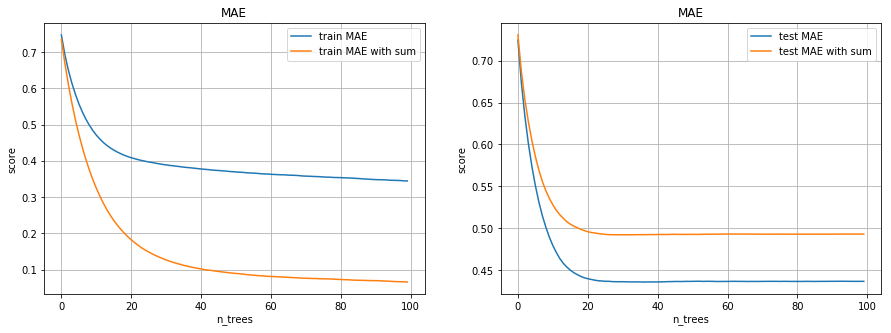

In [325]:
train_eval_rmse_sum, train_eval_mae_sum, test_eval_rmse_sum, test_eval_mae_sum = show_evals(evals_result_sum)
plot_compare(train_eval_mae, 'train MAE', train_eval_mae_sum, 'train MAE with sum', test_eval_mae, 'test MAE', 
             test_eval_mae_sum, 'test MAE with sum')

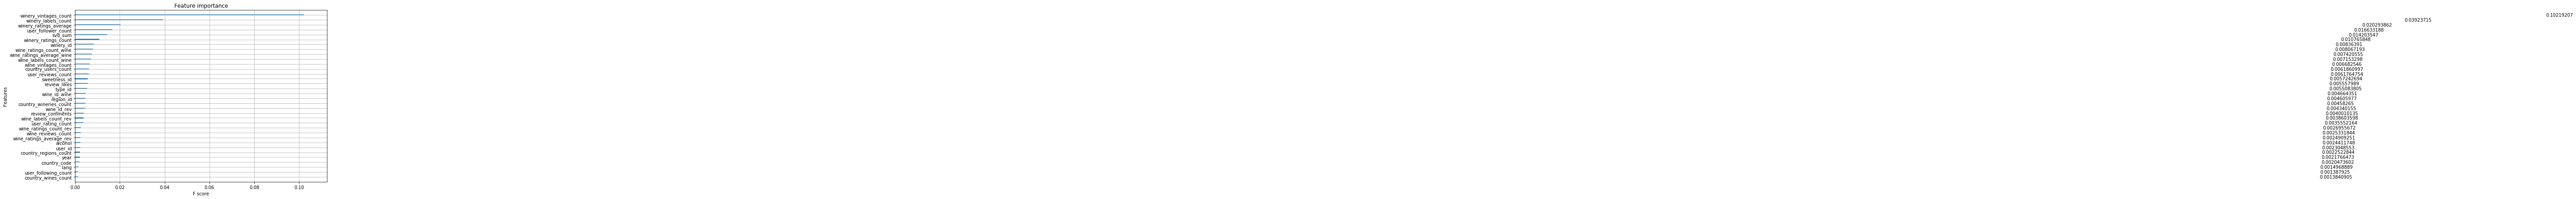

In [326]:
importances = OrderedDict(sorted(importances_sum.items(), key=lambda x: -x[1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xgb.plot_importance(importances, ax=ax)

По графикам отчетливо видно, как при добавлении в признаки какого-либо атрибута SVD-разложения улучшается качество предсказаний на обучении и ухудшается на тесте, - на лицо переобучение. Очевидно, xgboost выучивает много лишнего, и спросите меня, почему так происходит. Подсказка - см. user per num_ratings.

## Усечение SVD++

Чтобы попытаться исправить сложившуюся картину, проведем отбор в данных для SVD: будем настраиваться на пользователей, оставивших не меньше одной оценки. Для определенности и ускорения работы SVD++ оставим в OutOfVocabulary небольшую часть пользователей. Опять же, по-хорошему, нужно выборку перемешать, выбрать пользователей случайно или по их средним оценкам, но для простоты возьмём просто группку с 4 оценками.

In [327]:
more_rating_users = byUserNumRatings[byUserNumRatings.rating>=5].user_id.tolist()
ne_rating_users = byUserNumRatings[byUserNumRatings.rating==4].user_id.tolist()
print("Пользователей с >5 оценками: ", len(more_rating_users))
print("Пользователей с 4 оценками(OOV): ", len(ne_rating_users))
svd_data = data_train[data_train.user_id.isin(more_rating_users)][['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_data = svd_data.append(data_train[data_train.user_id.isin(ne_rating_users)][['user_id', 'wine_id_wine', 
                                                                                 'common_normalized_rating']])

svd_data.loc[svd_data['user_id'].isin(ne_rating_users), 'user_id'] = 1
svd_data = svd_data.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})

svd_test = data_test[['user_id', 'wine_id_wine', 'common_normalized_rating']]
svd_test = svd_test.astype({ 'user_id':int, 'wine_id_wine':int,'common_normalized_rating':float})

Пользователей с >5 оценками:  3794
Пользователей с 4 оценками(OOV):  1162


In [328]:
max_rate = svd_data['common_normalized_rating'].values.max()
min_rate = svd_data['common_normalized_rating'].values.min()

reader = Reader(rating_scale=(min_rate, max_rate))
data = Dataset.load_from_df(svd_data, reader)
trainset_svdpp_upd = data.build_full_trainset()

bestSVDpp = SVDpp(n_factors=10, n_epochs=55, lr_all=0.008, reg_all=0.08, init_mean=0.0, init_std_dev=0.1)
bestSVDpp.fit(trainset_svdpp_upd)

In [329]:
mapping_bu_pp_upd = trainset_svdpp_upd.__dict__['_raw2inner_id_users']
mapping_bi_pp_upd = trainset_svdpp_upd.__dict__['_raw2inner_id_items']

In [330]:
user_map_upd = data_train['user_id'].map(mapping_bu_pp_upd)
user_map_upd[user_map_upd.isna()] = mapping_bu_pp_upd.get(1)
user_map_upd = user_map_upd.astype(int)
bu_upd = bestSVDpp.bu[user_map_upd]

wine_map_upd = data_train['wine_id_wine'].map(mapping_bi_pp_upd)
wine_map_upd[wine_map_upd.isna()] = mapping_bi_pp_upd.get(-1)
wine_map_upd = wine_map_upd.astype(int)
bi_upd = bestSVDpp.bi[wine_map_upd]

In [331]:
user_map_upd_test = data_test['user_id'].map(mapping_bu_pp_upd)
user_map_upd_test[user_map_upd_test.isna()] = mapping_bu_pp_upd.get(1)
user_map_upd_test = user_map_upd_test.astype(int)
bu_upd_test = bestSVDpp.bu[user_map_upd_test]

wine_map_upd_test = data_test['wine_id_wine'].map(mapping_bi_pp_upd)
wine_map_upd_test[wine_map_upd_test.isna()] = mapping_bi_pp_upd.get(-1)
wine_map_upd_test = wine_map_upd_test.astype(int)
bi_upd_test = bestSVDpp.bi[wine_map_upd_test]

In [332]:
def svd_scalar_map_pp_upd(x):    
    if mapping_bu_pp_upd.get(x['user_id']):
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])]
    elif mapping_bu_pp_upd.get(x['user_id'])==0:
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])]
    else: 
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(1)]
        
    if mapping_bi_pp_upd.get(x['wine_id_wine']):
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    elif mapping_bi_pp_upd.get(x['wine_id_wine'])==0:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    else:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(-1)]
        
    return np.dot(y,z)
    
scalar = data_train.apply(svd_scalar_map_pp_upd, axis=1).as_matrix()
scalar_test = data_test.apply(svd_scalar_map_pp_upd, axis=1).as_matrix()

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [333]:
mu = data_train['common_normalized_rating'].values.mean()

def svd_plusplus(x):
    us = x['user_id']
    if svd_data[svd_data.user_id==us].empty:
        Iu = svd_data[svd_data.user_id==1].wine_id_wine.values.tolist()
        mod_Iu = np.power(len(Iu), -0.5)
    else: 
        Iu = svd_data[svd_data.user_id==us].wine_id_wine.values.tolist()
        mod_Iu = np.power(len(Iu), -0.5)
    yj = 0
    for j in Iu:
        yj += bestSVDpp.yj[mapping_bi_pp_upd.get(j)]
    yj = yj*mod_Iu
    if mapping_bu_pp_upd.get(x['user_id']):
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])] + yj
        bu = bestSVDpp.bu[mapping_bu_pp_upd.get(x['user_id'])]
    elif mapping_bu_pp_upd.get(x['user_id'])==0:
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(x['user_id'])] + yj
        bu = bestSVDpp.bu[mapping_bu_pp_upd.get(x['user_id'])]
    else: 
        y = bestSVDpp.pu[mapping_bu_pp_upd.get(1)] + yj
        bu = bestSVDpp.bu[mapping_bu_pp_upd.get(1)]
    if mapping_bi_pp_upd.get(x['wine_id_wine']):
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
        bi = bestSVDpp.bi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    elif mapping_bi_pp_upd.get(x['wine_id_wine'])==0:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
        bi = bestSVDpp.bi[mapping_bi_pp_upd.get(x['wine_id_wine'])]
    else:
        z = bestSVDpp.qi[mapping_bi_pp_upd.get(-1)]
        bi = bestSVDpp.bi[mapping_bi_pp_upd.get(-1)]
    return mu + bu + bi + np.dot(y,z)

res_train = data_train.apply(svd_plusplus, axis=1).as_matrix()
res_test = data_test.apply(svd_plusplus, axis=1).as_matrix()

/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/maria/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [334]:
print('Train MAE: ', metrics.mean_absolute_error(res_train, data_train['common_normalized_rating']),
      '\tTrain RMSE: ', metrics.mean_squared_error(res_train, data_train['common_normalized_rating']))
print('Test MAE: ', metrics.mean_absolute_error(res_test, data_test['common_normalized_rating']), '\tTest RMSE: ', 
      metrics.mean_squared_error(res_test, data_test['common_normalized_rating']))

Train MAE:  0.5618579312101636 	Train RMSE:  0.66921327431649
Test MAE:  0.5848935524561836 	Test RMSE:  0.6905119186171834


Качество предсказаний совсем не улучшается, неудивительно, ведь мы сильно сократили датасет и участвующих в нем пользователей. Посмотрим на влияние факторов на xgboost.

## XGBoost с параметрами SVD-разложения

In [335]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['user_bias'] = pd.Series(bu_upd, index=X_train.index)
X_train['wine_bias'] = pd.Series(bi_upd, index=X_train.index)
X_test['user_bias'] = pd.Series(bu_upd_test, index=X_test.index)
X_test['wine_bias'] = pd.Series(bi_upd_test, index=X_test.index)

imp_columns = X_train.columns

In [336]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 54) 		Тест:  (15300, 54)


In [337]:
evals_result_upd_bias, importances_upd_bias = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[15:46:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.04846	validation_0-mae:0.743364	validation_1-rmse:1.0139	validation_1-mae:0.724707
[1]	validation_0-rmse:0.979039	validation_0-mae:0.685291	validation_1-rmse:0.959785	validation_1-mae:0.675286
[2]	validation_0-rmse:0.916725	validation_0-mae:0.635207	validation_1-rmse:0.913804	validation_1-mae:0.636476
[3]	validation_0-rmse:0.861005	validation_0-mae:0.591753	validation_1-rmse:0.874588	validation_1-mae:0.604992
[4]	validation_0-rmse:0.811381	validation_0-mae:0.553083	validation_1-rmse:0.841089	validation_1-mae:0.577806
[15:46:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04846	validation_0-mae:0.743364	validation_1-rmse:1.0139	validation_1-mae:0.724707
[1]	validation_0-rmse:0.979039	validation_0-mae:0.685291	validation_1-rmse:0.959785	validation_1-mae:0.675286
[2]	validation_0-rmse:0.916725	validation_0-mae:0.635207	validation_1-rmse:0.913804	validation_1-mae:0.636476

[20]	validation_0-rmse:0.451201	validation_0-mae:0.277505	validation_1-rmse:0.683405	validation_1-mae:0.443867
[21]	validation_0-rmse:0.441966	validation_0-mae:0.270537	validation_1-rmse:0.682552	validation_1-mae:0.443317
[22]	validation_0-rmse:0.433134	validation_0-mae:0.264176	validation_1-rmse:0.681505	validation_1-mae:0.442734
[23]	validation_0-rmse:0.424723	validation_0-mae:0.258159	validation_1-rmse:0.680799	validation_1-mae:0.442263
[24]	validation_0-rmse:0.416658	validation_0-mae:0.25234	validation_1-rmse:0.680152	validation_1-mae:0.441952
[15:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04846	validation_0-mae:0.743364	validation_1-rmse:1.0139	validation_1-mae:0.724707
[1]	validation_0-rmse:0.979039	validation_0-mae:0.685291	validation_1-rmse:0.959785	validation_1-mae:0.675286
[2]	validation_0-rmse:0.916725	validation_0-mae:0.635207	validation_1-rmse:0.913804	validation_1-mae:0

[1]	validation_0-rmse:0.979039	validation_0-mae:0.685291	validation_1-rmse:0.959785	validation_1-mae:0.675286
[2]	validation_0-rmse:0.916725	validation_0-mae:0.635207	validation_1-rmse:0.913804	validation_1-mae:0.636476
[3]	validation_0-rmse:0.861005	validation_0-mae:0.591753	validation_1-rmse:0.874588	validation_1-mae:0.604992
[4]	validation_0-rmse:0.811381	validation_0-mae:0.553083	validation_1-rmse:0.841089	validation_1-mae:0.577806
[5]	validation_0-rmse:0.767086	validation_0-mae:0.518935	validation_1-rmse:0.812672	validation_1-mae:0.55476
[6]	validation_0-rmse:0.728028	validation_0-mae:0.488799	validation_1-rmse:0.788923	validation_1-mae:0.53533
[7]	validation_0-rmse:0.692582	validation_0-mae:0.461747	validation_1-rmse:0.769373	validation_1-mae:0.518921
[8]	validation_0-rmse:0.660603	validation_0-mae:0.437306	validation_1-rmse:0.753255	validation_1-mae:0.504948
[9]	validation_0-rmse:0.632446	validation_0-mae:0.415488	validation_1-rmse:0.73969	validation_1-mae:0.493005
[10]	validati

[35]	validation_0-rmse:0.35835	validation_0-mae:0.211595	validation_1-rmse:0.677941	validation_1-mae:0.442673
[36]	validation_0-rmse:0.354048	validation_0-mae:0.208616	validation_1-rmse:0.678004	validation_1-mae:0.442764
[37]	validation_0-rmse:0.350045	validation_0-mae:0.206139	validation_1-rmse:0.678045	validation_1-mae:0.442976
[38]	validation_0-rmse:0.346465	validation_0-mae:0.20375	validation_1-rmse:0.678058	validation_1-mae:0.443062
[39]	validation_0-rmse:0.342631	validation_0-mae:0.201156	validation_1-rmse:0.678104	validation_1-mae:0.443274
[40]	validation_0-rmse:0.338183	validation_0-mae:0.198374	validation_1-rmse:0.678016	validation_1-mae:0.443279
[41]	validation_0-rmse:0.334599	validation_0-mae:0.196167	validation_1-rmse:0.677828	validation_1-mae:0.443324
[42]	validation_0-rmse:0.331476	validation_0-mae:0.194072	validation_1-rmse:0.6779	validation_1-mae:0.443468
[43]	validation_0-rmse:0.328094	validation_0-mae:0.191945	validation_1-rmse:0.677714	validation_1-mae:0.443366
[44]	

[12]	validation_0-rmse:0.56366	validation_0-mae:0.362596	validation_1-rmse:0.711366	validation_1-mae:0.46759
[13]	validation_0-rmse:0.543721	validation_0-mae:0.347621	validation_1-rmse:0.705274	validation_1-mae:0.462117
[14]	validation_0-rmse:0.526398	validation_0-mae:0.334445	validation_1-rmse:0.700308	validation_1-mae:0.457496
[15]	validation_0-rmse:0.510705	validation_0-mae:0.3224	validation_1-rmse:0.696042	validation_1-mae:0.453792
[16]	validation_0-rmse:0.496704	validation_0-mae:0.311602	validation_1-rmse:0.692104	validation_1-mae:0.450486
[17]	validation_0-rmse:0.483303	validation_0-mae:0.301709	validation_1-rmse:0.689322	validation_1-mae:0.448218
[18]	validation_0-rmse:0.470964	validation_0-mae:0.292519	validation_1-rmse:0.686728	validation_1-mae:0.446238
[19]	validation_0-rmse:0.46059	validation_0-mae:0.284642	validation_1-rmse:0.684952	validation_1-mae:0.444749
[20]	validation_0-rmse:0.451201	validation_0-mae:0.277505	validation_1-rmse:0.683405	validation_1-mae:0.443867
[21]	v

[31]	validation_0-rmse:0.376216	validation_0-mae:0.223433	validation_1-rmse:0.67804	validation_1-mae:0.441801
[32]	validation_0-rmse:0.371563	validation_0-mae:0.220499	validation_1-rmse:0.677999	validation_1-mae:0.441985
[33]	validation_0-rmse:0.366206	validation_0-mae:0.21711	validation_1-rmse:0.678016	validation_1-mae:0.442252
[34]	validation_0-rmse:0.362615	validation_0-mae:0.214466	validation_1-rmse:0.678015	validation_1-mae:0.442614
[35]	validation_0-rmse:0.35835	validation_0-mae:0.211595	validation_1-rmse:0.677941	validation_1-mae:0.442673
[36]	validation_0-rmse:0.354048	validation_0-mae:0.208616	validation_1-rmse:0.678004	validation_1-mae:0.442764
[37]	validation_0-rmse:0.350045	validation_0-mae:0.206139	validation_1-rmse:0.678045	validation_1-mae:0.442976
[38]	validation_0-rmse:0.346465	validation_0-mae:0.20375	validation_1-rmse:0.678058	validation_1-mae:0.443062
[39]	validation_0-rmse:0.342631	validation_0-mae:0.201156	validation_1-rmse:0.678104	validation_1-mae:0.443274
[40]	

[45]	validation_0-rmse:0.321148	validation_0-mae:0.187822	validation_1-rmse:0.677665	validation_1-mae:0.443548
[46]	validation_0-rmse:0.31866	validation_0-mae:0.186237	validation_1-rmse:0.677595	validation_1-mae:0.443626
[47]	validation_0-rmse:0.315941	validation_0-mae:0.184586	validation_1-rmse:0.677524	validation_1-mae:0.443756
[48]	validation_0-rmse:0.313288	validation_0-mae:0.183022	validation_1-rmse:0.677467	validation_1-mae:0.443838
[49]	validation_0-rmse:0.311531	validation_0-mae:0.181708	validation_1-rmse:0.677462	validation_1-mae:0.443886
[50]	validation_0-rmse:0.309389	validation_0-mae:0.180369	validation_1-rmse:0.677421	validation_1-mae:0.444033
[51]	validation_0-rmse:0.307583	validation_0-mae:0.17931	validation_1-rmse:0.677401	validation_1-mae:0.444124
[52]	validation_0-rmse:0.304209	validation_0-mae:0.177544	validation_1-rmse:0.677343	validation_1-mae:0.444115
[53]	validation_0-rmse:0.300646	validation_0-mae:0.175453	validation_1-rmse:0.677185	validation_1-mae:0.444041
[54

[54]	validation_0-rmse:0.297142	validation_0-mae:0.173356	validation_1-rmse:0.677265	validation_1-mae:0.444153
[55]	validation_0-rmse:0.294449	validation_0-mae:0.171697	validation_1-rmse:0.677298	validation_1-mae:0.444243
[56]	validation_0-rmse:0.292509	validation_0-mae:0.170558	validation_1-rmse:0.677365	validation_1-mae:0.444324
[57]	validation_0-rmse:0.289711	validation_0-mae:0.169219	validation_1-rmse:0.677323	validation_1-mae:0.444343
[58]	validation_0-rmse:0.287849	validation_0-mae:0.167972	validation_1-rmse:0.677369	validation_1-mae:0.444507
[59]	validation_0-rmse:0.287301	validation_0-mae:0.167515	validation_1-rmse:0.677331	validation_1-mae:0.44452
[60]	validation_0-rmse:0.284431	validation_0-mae:0.166075	validation_1-rmse:0.677276	validation_1-mae:0.444565
[61]	validation_0-rmse:0.282991	validation_0-mae:0.165415	validation_1-rmse:0.677351	validation_1-mae:0.44461
[62]	validation_0-rmse:0.280351	validation_0-mae:0.163901	validation_1-rmse:0.677331	validation_1-mae:0.444606
[63

[57]	validation_0-rmse:0.289711	validation_0-mae:0.169219	validation_1-rmse:0.677323	validation_1-mae:0.444343
[58]	validation_0-rmse:0.287849	validation_0-mae:0.167972	validation_1-rmse:0.677369	validation_1-mae:0.444507
[59]	validation_0-rmse:0.287301	validation_0-mae:0.167515	validation_1-rmse:0.677331	validation_1-mae:0.44452
[60]	validation_0-rmse:0.284431	validation_0-mae:0.166075	validation_1-rmse:0.677276	validation_1-mae:0.444565
[61]	validation_0-rmse:0.282991	validation_0-mae:0.165415	validation_1-rmse:0.677351	validation_1-mae:0.44461
[62]	validation_0-rmse:0.280351	validation_0-mae:0.163901	validation_1-rmse:0.677331	validation_1-mae:0.444606
[63]	validation_0-rmse:0.277601	validation_0-mae:0.162066	validation_1-rmse:0.677342	validation_1-mae:0.444625
[64]	validation_0-rmse:0.275656	validation_0-mae:0.160965	validation_1-rmse:0.677366	validation_1-mae:0.44465
[65]	validation_0-rmse:0.275319	validation_0-mae:0.160713	validation_1-rmse:0.677342	validation_1-mae:0.444674
[66]

[56]	validation_0-rmse:0.292509	validation_0-mae:0.170558	validation_1-rmse:0.677365	validation_1-mae:0.444324
[57]	validation_0-rmse:0.289711	validation_0-mae:0.169219	validation_1-rmse:0.677323	validation_1-mae:0.444343
[58]	validation_0-rmse:0.287849	validation_0-mae:0.167972	validation_1-rmse:0.677369	validation_1-mae:0.444507
[59]	validation_0-rmse:0.287301	validation_0-mae:0.167515	validation_1-rmse:0.677331	validation_1-mae:0.44452
[60]	validation_0-rmse:0.284431	validation_0-mae:0.166075	validation_1-rmse:0.677276	validation_1-mae:0.444565
[61]	validation_0-rmse:0.282991	validation_0-mae:0.165415	validation_1-rmse:0.677351	validation_1-mae:0.44461
[62]	validation_0-rmse:0.280351	validation_0-mae:0.163901	validation_1-rmse:0.677331	validation_1-mae:0.444606
[63]	validation_0-rmse:0.277601	validation_0-mae:0.162066	validation_1-rmse:0.677342	validation_1-mae:0.444625
[64]	validation_0-rmse:0.275656	validation_0-mae:0.160965	validation_1-rmse:0.677366	validation_1-mae:0.44465
[65]

[50]	validation_0-rmse:0.309389	validation_0-mae:0.180369	validation_1-rmse:0.677421	validation_1-mae:0.444033
[51]	validation_0-rmse:0.307583	validation_0-mae:0.17931	validation_1-rmse:0.677401	validation_1-mae:0.444124
[52]	validation_0-rmse:0.304209	validation_0-mae:0.177544	validation_1-rmse:0.677343	validation_1-mae:0.444115
[53]	validation_0-rmse:0.300646	validation_0-mae:0.175453	validation_1-rmse:0.677185	validation_1-mae:0.444041
[54]	validation_0-rmse:0.297142	validation_0-mae:0.173356	validation_1-rmse:0.677265	validation_1-mae:0.444153
[55]	validation_0-rmse:0.294449	validation_0-mae:0.171697	validation_1-rmse:0.677298	validation_1-mae:0.444243
[56]	validation_0-rmse:0.292509	validation_0-mae:0.170558	validation_1-rmse:0.677365	validation_1-mae:0.444324
[57]	validation_0-rmse:0.289711	validation_0-mae:0.169219	validation_1-rmse:0.677323	validation_1-mae:0.444343
[58]	validation_0-rmse:0.287849	validation_0-mae:0.167972	validation_1-rmse:0.677369	validation_1-mae:0.444507
[5

[38]	validation_0-rmse:0.346465	validation_0-mae:0.20375	validation_1-rmse:0.678058	validation_1-mae:0.443062
[39]	validation_0-rmse:0.342631	validation_0-mae:0.201156	validation_1-rmse:0.678104	validation_1-mae:0.443274
[40]	validation_0-rmse:0.338183	validation_0-mae:0.198374	validation_1-rmse:0.678016	validation_1-mae:0.443279
[41]	validation_0-rmse:0.334599	validation_0-mae:0.196167	validation_1-rmse:0.677828	validation_1-mae:0.443324
[42]	validation_0-rmse:0.331476	validation_0-mae:0.194072	validation_1-rmse:0.6779	validation_1-mae:0.443468
[43]	validation_0-rmse:0.328094	validation_0-mae:0.191945	validation_1-rmse:0.677714	validation_1-mae:0.443366
[44]	validation_0-rmse:0.32506	validation_0-mae:0.190055	validation_1-rmse:0.677771	validation_1-mae:0.443465
[45]	validation_0-rmse:0.321148	validation_0-mae:0.187822	validation_1-rmse:0.677665	validation_1-mae:0.443548
[46]	validation_0-rmse:0.31866	validation_0-mae:0.186237	validation_1-rmse:0.677595	validation_1-mae:0.443626
[47]	v

[21]	validation_0-rmse:0.441966	validation_0-mae:0.270537	validation_1-rmse:0.682552	validation_1-mae:0.443317
[22]	validation_0-rmse:0.433134	validation_0-mae:0.264176	validation_1-rmse:0.681505	validation_1-mae:0.442734
[23]	validation_0-rmse:0.424723	validation_0-mae:0.258159	validation_1-rmse:0.680799	validation_1-mae:0.442263
[24]	validation_0-rmse:0.416658	validation_0-mae:0.25234	validation_1-rmse:0.680152	validation_1-mae:0.441952
[25]	validation_0-rmse:0.409103	validation_0-mae:0.247005	validation_1-rmse:0.679455	validation_1-mae:0.441581
[26]	validation_0-rmse:0.40338	validation_0-mae:0.242556	validation_1-rmse:0.678989	validation_1-mae:0.441373
[27]	validation_0-rmse:0.398478	validation_0-mae:0.238699	validation_1-rmse:0.678673	validation_1-mae:0.441344
[28]	validation_0-rmse:0.392024	validation_0-mae:0.234434	validation_1-rmse:0.678602	validation_1-mae:0.441635
[29]	validation_0-rmse:0.386726	validation_0-mae:0.230651	validation_1-rmse:0.67831	validation_1-mae:0.441592
[30]

[15:51:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04846	validation_0-mae:0.743364	validation_1-rmse:1.0139	validation_1-mae:0.724707
[1]	validation_0-rmse:0.979039	validation_0-mae:0.685291	validation_1-rmse:0.959785	validation_1-mae:0.675286
[2]	validation_0-rmse:0.916725	validation_0-mae:0.635207	validation_1-rmse:0.913804	validation_1-mae:0.636476
[3]	validation_0-rmse:0.861005	validation_0-mae:0.591753	validation_1-rmse:0.874588	validation_1-mae:0.604992
[4]	validation_0-rmse:0.811381	validation_0-mae:0.553083	validation_1-rmse:0.841089	validation_1-mae:0.577806
[5]	validation_0-rmse:0.767086	validation_0-mae:0.518935	validation_1-rmse:0.812672	validation_1-mae:0.55476
[6]	validation_0-rmse:0.728028	validation_0-mae:0.488799	validation_1-rmse:0.788923	validation_1-mae:0.53533
[7]	validation_0-rmse:0.692582	validation_0-mae:0.461747	validation_1-rmse:0.769373	validation_1-mae:0.51892

[73]	validation_0-rmse:0.265566	validation_0-mae:0.15487	validation_1-rmse:0.677417	validation_1-mae:0.444911
[74]	validation_0-rmse:0.264826	validation_0-mae:0.154322	validation_1-rmse:0.677395	validation_1-mae:0.444897
[75]	validation_0-rmse:0.262693	validation_0-mae:0.153105	validation_1-rmse:0.677472	validation_1-mae:0.444946
[76]	validation_0-rmse:0.260637	validation_0-mae:0.152028	validation_1-rmse:0.677509	validation_1-mae:0.445047
[77]	validation_0-rmse:0.258209	validation_0-mae:0.150991	validation_1-rmse:0.677613	validation_1-mae:0.445111
[78]	validation_0-rmse:0.257954	validation_0-mae:0.150857	validation_1-rmse:0.677613	validation_1-mae:0.44511
[79]	validation_0-rmse:0.257475	validation_0-mae:0.150481	validation_1-rmse:0.677605	validation_1-mae:0.445112
[80]	validation_0-rmse:0.2565	validation_0-mae:0.149902	validation_1-rmse:0.677612	validation_1-mae:0.445085
[81]	validation_0-rmse:0.256437	validation_0-mae:0.149858	validation_1-rmse:0.677627	validation_1-mae:0.445092
[82]	

[0.724707, 0.675286, 0.636476, 0.604992, 0.577806, 0.55476, 0.53533, 0.518921, 0.504948, 0.493005]


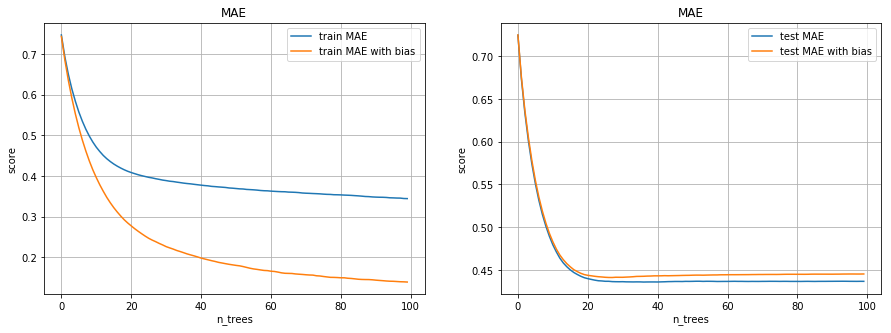

In [338]:
train_rmse_upd_bias, train_mae_upd_bias, test_rmse_upd_bias, test_mae_upd_bias = show_evals(evals_result_upd_bias)
plot_compare(train_eval_mae, 'train MAE', train_mae_upd_bias, 'train MAE with bias', test_eval_mae, 'test MAE', 
             test_mae_upd_bias, 'test MAE with bias')

In [339]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_scalar'] = pd.Series(scalar, index=X_train.index)
X_test['svd_scalar'] = pd.Series(scalar_test, index=X_test.index)

imp_columns = X_train.columns

In [340]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 53) Тест:  (15300, 53)


In [341]:
evals_result_upd_scal, importances_upd_scal = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[15:51:54] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.04801	validation_0-mae:0.743671	validation_1-rmse:1.01643	validation_1-mae:0.7267
[1]	validation_0-rmse:0.977331	validation_0-mae:0.685152	validation_1-rmse:0.965969	validation_1-mae:0.679439
[2]	validation_0-rmse:0.914864	validation_0-mae:0.63553	validation_1-rmse:0.922809	validation_1-mae:0.643153
[3]	validation_0-rmse:0.859639	validation_0-mae:0.592508	validation_1-rmse:0.886202	validation_1-mae:0.613004
[4]	validation_0-rmse:0.809716	validation_0-mae:0.554026	validation_1-rmse:0.85505	validation_1-mae:0.587231
[15:51:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04801	validation_0-mae:0.743671	validation_1-rmse:1.01643	validation_1-mae:0.7267
[1]	validation_0-rmse:0.977331	validation_0-mae:0.685152	validation_1-rmse:0.965969	validation_1-mae:0.679439
[2]	validation_0-rmse:0.914864	validation_0-mae:0.63553	validation_1-rmse:0.922809	validation_1-mae:0.643153
[3]	

[21]	validation_0-rmse:0.442264	validation_0-mae:0.27672	validation_1-rmse:0.706433	validation_1-mae:0.461819
[22]	validation_0-rmse:0.434466	validation_0-mae:0.270857	validation_1-rmse:0.705533	validation_1-mae:0.461382
[23]	validation_0-rmse:0.426323	validation_0-mae:0.265107	validation_1-rmse:0.704488	validation_1-mae:0.460744
[24]	validation_0-rmse:0.419251	validation_0-mae:0.259914	validation_1-rmse:0.703808	validation_1-mae:0.460316
[15:52:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04801	validation_0-mae:0.743671	validation_1-rmse:1.01643	validation_1-mae:0.7267
[1]	validation_0-rmse:0.977331	validation_0-mae:0.685152	validation_1-rmse:0.965969	validation_1-mae:0.679439
[2]	validation_0-rmse:0.914864	validation_0-mae:0.63553	validation_1-rmse:0.922809	validation_1-mae:0.643153
[3]	validation_0-rmse:0.859639	validation_0-mae:0.592508	validation_1-rmse:0.886202	validation_1-mae:0.61

[2]	validation_0-rmse:0.914864	validation_0-mae:0.63553	validation_1-rmse:0.922809	validation_1-mae:0.643153
[3]	validation_0-rmse:0.859639	validation_0-mae:0.592508	validation_1-rmse:0.886202	validation_1-mae:0.613004
[4]	validation_0-rmse:0.809716	validation_0-mae:0.554026	validation_1-rmse:0.85505	validation_1-mae:0.587231
[5]	validation_0-rmse:0.765256	validation_0-mae:0.520054	validation_1-rmse:0.828626	validation_1-mae:0.565415
[6]	validation_0-rmse:0.725712	validation_0-mae:0.489873	validation_1-rmse:0.80603	validation_1-mae:0.546429
[7]	validation_0-rmse:0.690695	validation_0-mae:0.463258	validation_1-rmse:0.787566	validation_1-mae:0.530703
[8]	validation_0-rmse:0.65893	validation_0-mae:0.439051	validation_1-rmse:0.772172	validation_1-mae:0.517668
[9]	validation_0-rmse:0.630584	validation_0-mae:0.417316	validation_1-rmse:0.759516	validation_1-mae:0.506488
[10]	validation_0-rmse:0.604437	validation_0-mae:0.397759	validation_1-rmse:0.748967	validation_1-mae:0.497234
[11]	validati

[36]	validation_0-rmse:0.364814	validation_0-mae:0.221368	validation_1-rmse:0.702071	validation_1-mae:0.460846
[37]	validation_0-rmse:0.361552	validation_0-mae:0.219127	validation_1-rmse:0.701971	validation_1-mae:0.460882
[38]	validation_0-rmse:0.35725	validation_0-mae:0.21655	validation_1-rmse:0.701845	validation_1-mae:0.461103
[39]	validation_0-rmse:0.353339	validation_0-mae:0.214449	validation_1-rmse:0.701671	validation_1-mae:0.461131
[40]	validation_0-rmse:0.351114	validation_0-mae:0.213075	validation_1-rmse:0.701668	validation_1-mae:0.461245
[41]	validation_0-rmse:0.348258	validation_0-mae:0.210987	validation_1-rmse:0.701579	validation_1-mae:0.461238
[42]	validation_0-rmse:0.344273	validation_0-mae:0.208431	validation_1-rmse:0.701755	validation_1-mae:0.461444
[43]	validation_0-rmse:0.342201	validation_0-mae:0.206757	validation_1-rmse:0.70164	validation_1-mae:0.46141
[44]	validation_0-rmse:0.338432	validation_0-mae:0.204478	validation_1-rmse:0.701652	validation_1-mae:0.461394
[15:5

[14]	validation_0-rmse:0.523576	validation_0-mae:0.337295	validation_1-rmse:0.723048	validation_1-mae:0.474426
[15]	validation_0-rmse:0.508593	validation_0-mae:0.326093	validation_1-rmse:0.718845	validation_1-mae:0.47094
[16]	validation_0-rmse:0.494596	validation_0-mae:0.315702	validation_1-rmse:0.715646	validation_1-mae:0.468292
[17]	validation_0-rmse:0.482328	validation_0-mae:0.306374	validation_1-rmse:0.713109	validation_1-mae:0.466261
[18]	validation_0-rmse:0.470751	validation_0-mae:0.297875	validation_1-rmse:0.711022	validation_1-mae:0.464888
[19]	validation_0-rmse:0.460217	validation_0-mae:0.290101	validation_1-rmse:0.708795	validation_1-mae:0.46324
[20]	validation_0-rmse:0.451271	validation_0-mae:0.283386	validation_1-rmse:0.707757	validation_1-mae:0.462693
[21]	validation_0-rmse:0.442264	validation_0-mae:0.27672	validation_1-rmse:0.706433	validation_1-mae:0.461819
[22]	validation_0-rmse:0.434466	validation_0-mae:0.270857	validation_1-rmse:0.705533	validation_1-mae:0.461382
[23]

[33]	validation_0-rmse:0.373076	validation_0-mae:0.227399	validation_1-rmse:0.702004	validation_1-mae:0.460266
[34]	validation_0-rmse:0.37043	validation_0-mae:0.22536	validation_1-rmse:0.702015	validation_1-mae:0.460479
[35]	validation_0-rmse:0.367268	validation_0-mae:0.223229	validation_1-rmse:0.701994	validation_1-mae:0.460661
[36]	validation_0-rmse:0.364814	validation_0-mae:0.221368	validation_1-rmse:0.702071	validation_1-mae:0.460846
[37]	validation_0-rmse:0.361552	validation_0-mae:0.219127	validation_1-rmse:0.701971	validation_1-mae:0.460882
[38]	validation_0-rmse:0.35725	validation_0-mae:0.21655	validation_1-rmse:0.701845	validation_1-mae:0.461103
[39]	validation_0-rmse:0.353339	validation_0-mae:0.214449	validation_1-rmse:0.701671	validation_1-mae:0.461131
[40]	validation_0-rmse:0.351114	validation_0-mae:0.213075	validation_1-rmse:0.701668	validation_1-mae:0.461245
[41]	validation_0-rmse:0.348258	validation_0-mae:0.210987	validation_1-rmse:0.701579	validation_1-mae:0.461238
[42]	

[47]	validation_0-rmse:0.329014	validation_0-mae:0.198468	validation_1-rmse:0.7017	validation_1-mae:0.461721
[48]	validation_0-rmse:0.327313	validation_0-mae:0.19711	validation_1-rmse:0.701566	validation_1-mae:0.461664
[49]	validation_0-rmse:0.324293	validation_0-mae:0.195144	validation_1-rmse:0.701631	validation_1-mae:0.461768
[50]	validation_0-rmse:0.32185	validation_0-mae:0.19349	validation_1-rmse:0.701542	validation_1-mae:0.461749
[51]	validation_0-rmse:0.318707	validation_0-mae:0.191382	validation_1-rmse:0.701394	validation_1-mae:0.461747
[52]	validation_0-rmse:0.317293	validation_0-mae:0.190421	validation_1-rmse:0.701357	validation_1-mae:0.461765
[53]	validation_0-rmse:0.315391	validation_0-mae:0.189303	validation_1-rmse:0.701372	validation_1-mae:0.461818
[54]	validation_0-rmse:0.313846	validation_0-mae:0.188172	validation_1-rmse:0.701262	validation_1-mae:0.461791
[55]	validation_0-rmse:0.311829	validation_0-mae:0.187071	validation_1-rmse:0.701148	validation_1-mae:0.461749
[56]	v

[56]	validation_0-rmse:0.308892	validation_0-mae:0.185474	validation_1-rmse:0.70124	validation_1-mae:0.461876
[57]	validation_0-rmse:0.306621	validation_0-mae:0.184212	validation_1-rmse:0.701257	validation_1-mae:0.462002
[58]	validation_0-rmse:0.304336	validation_0-mae:0.182763	validation_1-rmse:0.701181	validation_1-mae:0.46203
[59]	validation_0-rmse:0.303004	validation_0-mae:0.181729	validation_1-rmse:0.700991	validation_1-mae:0.461899
[60]	validation_0-rmse:0.300078	validation_0-mae:0.180028	validation_1-rmse:0.700982	validation_1-mae:0.461945
[61]	validation_0-rmse:0.298771	validation_0-mae:0.17926	validation_1-rmse:0.700918	validation_1-mae:0.461951
[62]	validation_0-rmse:0.296863	validation_0-mae:0.17805	validation_1-rmse:0.700963	validation_1-mae:0.462014
[63]	validation_0-rmse:0.294083	validation_0-mae:0.176015	validation_1-rmse:0.700753	validation_1-mae:0.461874
[64]	validation_0-rmse:0.291501	validation_0-mae:0.174503	validation_1-rmse:0.700692	validation_1-mae:0.461908
[65]	

[60]	validation_0-rmse:0.300078	validation_0-mae:0.180028	validation_1-rmse:0.700982	validation_1-mae:0.461945
[61]	validation_0-rmse:0.298771	validation_0-mae:0.17926	validation_1-rmse:0.700918	validation_1-mae:0.461951
[62]	validation_0-rmse:0.296863	validation_0-mae:0.17805	validation_1-rmse:0.700963	validation_1-mae:0.462014
[63]	validation_0-rmse:0.294083	validation_0-mae:0.176015	validation_1-rmse:0.700753	validation_1-mae:0.461874
[64]	validation_0-rmse:0.291501	validation_0-mae:0.174503	validation_1-rmse:0.700692	validation_1-mae:0.461908
[65]	validation_0-rmse:0.290224	validation_0-mae:0.173537	validation_1-rmse:0.700549	validation_1-mae:0.461809
[66]	validation_0-rmse:0.287321	validation_0-mae:0.172116	validation_1-rmse:0.700551	validation_1-mae:0.461843
[67]	validation_0-rmse:0.28402	validation_0-mae:0.170034	validation_1-rmse:0.700422	validation_1-mae:0.461782
[68]	validation_0-rmse:0.282699	validation_0-mae:0.169074	validation_1-rmse:0.700377	validation_1-mae:0.461724
[69]

[59]	validation_0-rmse:0.303004	validation_0-mae:0.181729	validation_1-rmse:0.700991	validation_1-mae:0.461899
[60]	validation_0-rmse:0.300078	validation_0-mae:0.180028	validation_1-rmse:0.700982	validation_1-mae:0.461945
[61]	validation_0-rmse:0.298771	validation_0-mae:0.17926	validation_1-rmse:0.700918	validation_1-mae:0.461951
[62]	validation_0-rmse:0.296863	validation_0-mae:0.17805	validation_1-rmse:0.700963	validation_1-mae:0.462014
[63]	validation_0-rmse:0.294083	validation_0-mae:0.176015	validation_1-rmse:0.700753	validation_1-mae:0.461874
[64]	validation_0-rmse:0.291501	validation_0-mae:0.174503	validation_1-rmse:0.700692	validation_1-mae:0.461908
[65]	validation_0-rmse:0.290224	validation_0-mae:0.173537	validation_1-rmse:0.700549	validation_1-mae:0.461809
[66]	validation_0-rmse:0.287321	validation_0-mae:0.172116	validation_1-rmse:0.700551	validation_1-mae:0.461843
[67]	validation_0-rmse:0.28402	validation_0-mae:0.170034	validation_1-rmse:0.700422	validation_1-mae:0.461782
[68]

[53]	validation_0-rmse:0.315391	validation_0-mae:0.189303	validation_1-rmse:0.701372	validation_1-mae:0.461818
[54]	validation_0-rmse:0.313846	validation_0-mae:0.188172	validation_1-rmse:0.701262	validation_1-mae:0.461791
[55]	validation_0-rmse:0.311829	validation_0-mae:0.187071	validation_1-rmse:0.701148	validation_1-mae:0.461749
[56]	validation_0-rmse:0.308892	validation_0-mae:0.185474	validation_1-rmse:0.70124	validation_1-mae:0.461876
[57]	validation_0-rmse:0.306621	validation_0-mae:0.184212	validation_1-rmse:0.701257	validation_1-mae:0.462002
[58]	validation_0-rmse:0.304336	validation_0-mae:0.182763	validation_1-rmse:0.701181	validation_1-mae:0.46203
[59]	validation_0-rmse:0.303004	validation_0-mae:0.181729	validation_1-rmse:0.700991	validation_1-mae:0.461899
[60]	validation_0-rmse:0.300078	validation_0-mae:0.180028	validation_1-rmse:0.700982	validation_1-mae:0.461945
[61]	validation_0-rmse:0.298771	validation_0-mae:0.17926	validation_1-rmse:0.700918	validation_1-mae:0.461951
[62]

[42]	validation_0-rmse:0.344273	validation_0-mae:0.208431	validation_1-rmse:0.701755	validation_1-mae:0.461444
[43]	validation_0-rmse:0.342201	validation_0-mae:0.206757	validation_1-rmse:0.70164	validation_1-mae:0.46141
[44]	validation_0-rmse:0.338432	validation_0-mae:0.204478	validation_1-rmse:0.701652	validation_1-mae:0.461394
[45]	validation_0-rmse:0.335509	validation_0-mae:0.202569	validation_1-rmse:0.70165	validation_1-mae:0.461504
[46]	validation_0-rmse:0.33193	validation_0-mae:0.200429	validation_1-rmse:0.701721	validation_1-mae:0.46159
[47]	validation_0-rmse:0.329014	validation_0-mae:0.198468	validation_1-rmse:0.7017	validation_1-mae:0.461721
[48]	validation_0-rmse:0.327313	validation_0-mae:0.19711	validation_1-rmse:0.701566	validation_1-mae:0.461664
[49]	validation_0-rmse:0.324293	validation_0-mae:0.195144	validation_1-rmse:0.701631	validation_1-mae:0.461768
[50]	validation_0-rmse:0.32185	validation_0-mae:0.19349	validation_1-rmse:0.701542	validation_1-mae:0.461749
[51]	valida

[26]	validation_0-rmse:0.406751	validation_0-mae:0.251179	validation_1-rmse:0.702921	validation_1-mae:0.459916
[27]	validation_0-rmse:0.401108	validation_0-mae:0.247002	validation_1-rmse:0.702529	validation_1-mae:0.459898
[28]	validation_0-rmse:0.395785	validation_0-mae:0.243158	validation_1-rmse:0.70243	validation_1-mae:0.459935
[29]	validation_0-rmse:0.390104	validation_0-mae:0.239222	validation_1-rmse:0.702243	validation_1-mae:0.45993
[30]	validation_0-rmse:0.385772	validation_0-mae:0.23623	validation_1-rmse:0.702084	validation_1-mae:0.460026
[31]	validation_0-rmse:0.381584	validation_0-mae:0.233148	validation_1-rmse:0.702064	validation_1-mae:0.460085
[32]	validation_0-rmse:0.37753	validation_0-mae:0.230248	validation_1-rmse:0.702082	validation_1-mae:0.460234
[33]	validation_0-rmse:0.373076	validation_0-mae:0.227399	validation_1-rmse:0.702004	validation_1-mae:0.460266
[34]	validation_0-rmse:0.37043	validation_0-mae:0.22536	validation_1-rmse:0.702015	validation_1-mae:0.460479
[35]	va

[5]	validation_0-rmse:0.765256	validation_0-mae:0.520054	validation_1-rmse:0.828626	validation_1-mae:0.565415
[6]	validation_0-rmse:0.725712	validation_0-mae:0.489873	validation_1-rmse:0.80603	validation_1-mae:0.546429
[7]	validation_0-rmse:0.690695	validation_0-mae:0.463258	validation_1-rmse:0.787566	validation_1-mae:0.530703
[8]	validation_0-rmse:0.65893	validation_0-mae:0.439051	validation_1-rmse:0.772172	validation_1-mae:0.517668
[9]	validation_0-rmse:0.630584	validation_0-mae:0.417316	validation_1-rmse:0.759516	validation_1-mae:0.506488
[10]	validation_0-rmse:0.604437	validation_0-mae:0.397759	validation_1-rmse:0.748967	validation_1-mae:0.497234
[11]	validation_0-rmse:0.580267	validation_0-mae:0.379813	validation_1-rmse:0.740811	validation_1-mae:0.490004
[12]	validation_0-rmse:0.560346	validation_0-mae:0.364433	validation_1-rmse:0.733574	validation_1-mae:0.48347
[13]	validation_0-rmse:0.540612	validation_0-mae:0.350019	validation_1-rmse:0.727761	validation_1-mae:0.478579
[14]	vali

[80]	validation_0-rmse:0.269899	validation_0-mae:0.160251	validation_1-rmse:0.700203	validation_1-mae:0.461638
[81]	validation_0-rmse:0.269818	validation_0-mae:0.160197	validation_1-rmse:0.700194	validation_1-mae:0.461647
[82]	validation_0-rmse:0.267788	validation_0-mae:0.158963	validation_1-rmse:0.700191	validation_1-mae:0.461624
[83]	validation_0-rmse:0.265719	validation_0-mae:0.157599	validation_1-rmse:0.700314	validation_1-mae:0.461709
[84]	validation_0-rmse:0.265149	validation_0-mae:0.156974	validation_1-rmse:0.700198	validation_1-mae:0.461613
[85]	validation_0-rmse:0.262023	validation_0-mae:0.155361	validation_1-rmse:0.70014	validation_1-mae:0.461638
[86]	validation_0-rmse:0.260315	validation_0-mae:0.154074	validation_1-rmse:0.700173	validation_1-mae:0.461627
[87]	validation_0-rmse:0.259977	validation_0-mae:0.153695	validation_1-rmse:0.70008	validation_1-mae:0.461544
[88]	validation_0-rmse:0.257414	validation_0-mae:0.152434	validation_1-rmse:0.700135	validation_1-mae:0.461583
[89

[0.7267, 0.679439, 0.643153, 0.613004, 0.587231, 0.565415, 0.546429, 0.530703, 0.517668, 0.506488]


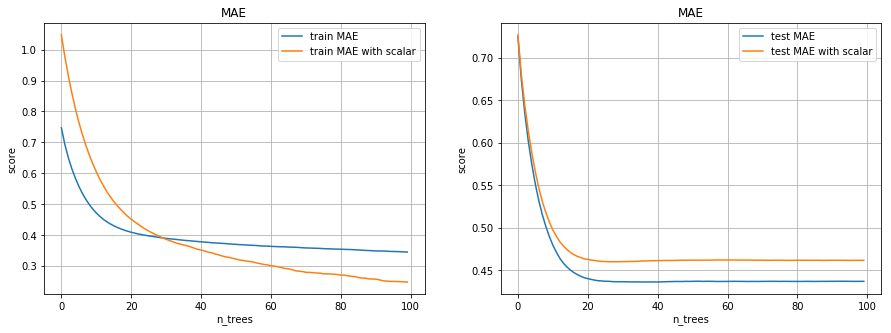

In [342]:
train_rmse_upd_scal, train_mae_upd_scal, test_rmse_upd_scal, test_mae_upd_scal = show_evals(evals_result_upd_scal)
plot_compare(train_eval_mae, 'train MAE', train_rmse_upd_scal, 'train MAE with scalar', test_eval_mae, 'test MAE', 
             test_mae_upd_scal, 'test MAE with scalar')

In [343]:
X_train, X_test, y_train, y_test = make_X_y()

X_train['svd_sum'] = pd.Series(res_train, index=X_train.index)
X_test['svd_sum'] = pd.Series(res_test, index=X_test.index)

imp_columns = X_train.columns

In [344]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 53) Тест:  (15300, 53)


In [345]:
evals_result_upd_sum, importances_upd_sum = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

[15:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[0]	validation_0-rmse:1.04548	validation_0-mae:0.742192	validation_1-rmse:1.01555	validation_1-mae:0.726656
[1]	validation_0-rmse:0.9737	validation_0-mae:0.682996	validation_1-rmse:0.96287	validation_1-mae:0.67882
[2]	validation_0-rmse:0.909525	validation_0-mae:0.632155	validation_1-rmse:0.918452	validation_1-mae:0.641183
[3]	validation_0-rmse:0.852031	validation_0-mae:0.58804	validation_1-rmse:0.880164	validation_1-mae:0.610271
[4]	validation_0-rmse:0.800873	validation_0-mae:0.54891	validation_1-rmse:0.848199	validation_1-mae:0.58408
[15:57:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04548	validation_0-mae:0.742192	validation_1-rmse:1.01555	validation_1-mae:0.726656
[1]	validation_0-rmse:0.9737	validation_0-mae:0.682996	validation_1-rmse:0.96287	validation_1-mae:0.67882
[2]	validation_0-rmse:0.909525	validation_0-mae:0.632155	validation_1-rmse:0.918452	validation_1-mae:0.641183
[3]	vali

[21]	validation_0-rmse:0.417511	validation_0-mae:0.262701	validation_1-rmse:0.695631	validation_1-mae:0.452136
[22]	validation_0-rmse:0.408564	validation_0-mae:0.256205	validation_1-rmse:0.694681	validation_1-mae:0.451446
[23]	validation_0-rmse:0.400443	validation_0-mae:0.250576	validation_1-rmse:0.69403	validation_1-mae:0.451079
[24]	validation_0-rmse:0.392876	validation_0-mae:0.245309	validation_1-rmse:0.6935	validation_1-mae:0.450841
[15:57:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04548	validation_0-mae:0.742192	validation_1-rmse:1.01555	validation_1-mae:0.726656
[1]	validation_0-rmse:0.9737	validation_0-mae:0.682996	validation_1-rmse:0.96287	validation_1-mae:0.67882
[2]	validation_0-rmse:0.909525	validation_0-mae:0.632155	validation_1-rmse:0.918452	validation_1-mae:0.641183
[3]	validation_0-rmse:0.852031	validation_0-mae:0.58804	validation_1-rmse:0.880164	validation_1-mae:0.610271

[3]	validation_0-rmse:0.852031	validation_0-mae:0.58804	validation_1-rmse:0.880164	validation_1-mae:0.610271
[4]	validation_0-rmse:0.800873	validation_0-mae:0.54891	validation_1-rmse:0.848199	validation_1-mae:0.58408
[5]	validation_0-rmse:0.755573	validation_0-mae:0.514512	validation_1-rmse:0.820934	validation_1-mae:0.56151
[6]	validation_0-rmse:0.714246	validation_0-mae:0.483464	validation_1-rmse:0.79817	validation_1-mae:0.542796
[7]	validation_0-rmse:0.677262	validation_0-mae:0.45565	validation_1-rmse:0.778832	validation_1-mae:0.526721
[8]	validation_0-rmse:0.643965	validation_0-mae:0.430525	validation_1-rmse:0.763081	validation_1-mae:0.512873
[9]	validation_0-rmse:0.613942	validation_0-mae:0.408048	validation_1-rmse:0.750371	validation_1-mae:0.501677
[10]	validation_0-rmse:0.587367	validation_0-mae:0.388085	validation_1-rmse:0.739774	validation_1-mae:0.492048
[11]	validation_0-rmse:0.563188	validation_0-mae:0.370023	validation_1-rmse:0.730825	validation_1-mae:0.484244
[12]	validatio

[37]	validation_0-rmse:0.328515	validation_0-mae:0.200817	validation_1-rmse:0.691598	validation_1-mae:0.450477
[38]	validation_0-rmse:0.324688	validation_0-mae:0.198235	validation_1-rmse:0.691645	validation_1-mae:0.450588
[39]	validation_0-rmse:0.322345	validation_0-mae:0.196468	validation_1-rmse:0.691509	validation_1-mae:0.450564
[40]	validation_0-rmse:0.318496	validation_0-mae:0.194035	validation_1-rmse:0.691551	validation_1-mae:0.450751
[41]	validation_0-rmse:0.315292	validation_0-mae:0.191886	validation_1-rmse:0.691528	validation_1-mae:0.450896
[42]	validation_0-rmse:0.312084	validation_0-mae:0.18981	validation_1-rmse:0.691719	validation_1-mae:0.451104
[43]	validation_0-rmse:0.308925	validation_0-mae:0.187727	validation_1-rmse:0.691802	validation_1-mae:0.451222
[44]	validation_0-rmse:0.306597	validation_0-mae:0.185877	validation_1-rmse:0.691852	validation_1-mae:0.451332
[15:58:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:

[15]	validation_0-rmse:0.488296	validation_0-mae:0.314065	validation_1-rmse:0.708302	validation_1-mae:0.463181
[16]	validation_0-rmse:0.473628	validation_0-mae:0.303402	validation_1-rmse:0.705195	validation_1-mae:0.46033
[17]	validation_0-rmse:0.460785	validation_0-mae:0.29387	validation_1-rmse:0.702565	validation_1-mae:0.457885
[18]	validation_0-rmse:0.449214	validation_0-mae:0.285468	validation_1-rmse:0.700259	validation_1-mae:0.455936
[19]	validation_0-rmse:0.438039	validation_0-mae:0.277433	validation_1-rmse:0.698297	validation_1-mae:0.454148
[20]	validation_0-rmse:0.42729	validation_0-mae:0.26977	validation_1-rmse:0.69691	validation_1-mae:0.452955
[21]	validation_0-rmse:0.417511	validation_0-mae:0.262701	validation_1-rmse:0.695631	validation_1-mae:0.452136
[22]	validation_0-rmse:0.408564	validation_0-mae:0.256205	validation_1-rmse:0.694681	validation_1-mae:0.451446
[23]	validation_0-rmse:0.400443	validation_0-mae:0.250576	validation_1-rmse:0.69403	validation_1-mae:0.451079
[24]	va

[34]	validation_0-rmse:0.340298	validation_0-mae:0.2085	validation_1-rmse:0.691412	validation_1-mae:0.449962
[35]	validation_0-rmse:0.337229	validation_0-mae:0.206222	validation_1-rmse:0.691435	validation_1-mae:0.450052
[36]	validation_0-rmse:0.333486	validation_0-mae:0.203622	validation_1-rmse:0.691574	validation_1-mae:0.450217
[37]	validation_0-rmse:0.328515	validation_0-mae:0.200817	validation_1-rmse:0.691598	validation_1-mae:0.450477
[38]	validation_0-rmse:0.324688	validation_0-mae:0.198235	validation_1-rmse:0.691645	validation_1-mae:0.450588
[39]	validation_0-rmse:0.322345	validation_0-mae:0.196468	validation_1-rmse:0.691509	validation_1-mae:0.450564
[40]	validation_0-rmse:0.318496	validation_0-mae:0.194035	validation_1-rmse:0.691551	validation_1-mae:0.450751
[41]	validation_0-rmse:0.315292	validation_0-mae:0.191886	validation_1-rmse:0.691528	validation_1-mae:0.450896
[42]	validation_0-rmse:0.312084	validation_0-mae:0.18981	validation_1-rmse:0.691719	validation_1-mae:0.451104
[43]

[48]	validation_0-rmse:0.297303	validation_0-mae:0.179795	validation_1-rmse:0.69192	validation_1-mae:0.451785
[49]	validation_0-rmse:0.294724	validation_0-mae:0.178151	validation_1-rmse:0.691764	validation_1-mae:0.451781
[50]	validation_0-rmse:0.292955	validation_0-mae:0.176832	validation_1-rmse:0.69178	validation_1-mae:0.451874
[51]	validation_0-rmse:0.291394	validation_0-mae:0.175697	validation_1-rmse:0.691764	validation_1-mae:0.451902
[52]	validation_0-rmse:0.290045	validation_0-mae:0.174901	validation_1-rmse:0.691734	validation_1-mae:0.451958
[53]	validation_0-rmse:0.288238	validation_0-mae:0.173683	validation_1-rmse:0.691792	validation_1-mae:0.452026
[54]	validation_0-rmse:0.286229	validation_0-mae:0.172615	validation_1-rmse:0.691814	validation_1-mae:0.452067
[55]	validation_0-rmse:0.28572	validation_0-mae:0.172156	validation_1-rmse:0.691788	validation_1-mae:0.452072
[56]	validation_0-rmse:0.283358	validation_0-mae:0.170805	validation_1-rmse:0.69179	validation_1-mae:0.452153
[57]	

[57]	validation_0-rmse:0.281534	validation_0-mae:0.169721	validation_1-rmse:0.691682	validation_1-mae:0.452122
[58]	validation_0-rmse:0.280269	validation_0-mae:0.168835	validation_1-rmse:0.69162	validation_1-mae:0.452122
[59]	validation_0-rmse:0.279137	validation_0-mae:0.167882	validation_1-rmse:0.69159	validation_1-mae:0.452144
[60]	validation_0-rmse:0.276643	validation_0-mae:0.166527	validation_1-rmse:0.69151	validation_1-mae:0.452105
[61]	validation_0-rmse:0.273939	validation_0-mae:0.164976	validation_1-rmse:0.691531	validation_1-mae:0.452172
[62]	validation_0-rmse:0.273423	validation_0-mae:0.164527	validation_1-rmse:0.691484	validation_1-mae:0.45219
[63]	validation_0-rmse:0.272699	validation_0-mae:0.163978	validation_1-rmse:0.691507	validation_1-mae:0.452228
[64]	validation_0-rmse:0.271805	validation_0-mae:0.163356	validation_1-rmse:0.691488	validation_1-mae:0.452271
[65]	validation_0-rmse:0.268851	validation_0-mae:0.161865	validation_1-rmse:0.691509	validation_1-mae:0.452302
[66]	

[61]	validation_0-rmse:0.273939	validation_0-mae:0.164976	validation_1-rmse:0.691531	validation_1-mae:0.452172
[62]	validation_0-rmse:0.273423	validation_0-mae:0.164527	validation_1-rmse:0.691484	validation_1-mae:0.45219
[63]	validation_0-rmse:0.272699	validation_0-mae:0.163978	validation_1-rmse:0.691507	validation_1-mae:0.452228
[64]	validation_0-rmse:0.271805	validation_0-mae:0.163356	validation_1-rmse:0.691488	validation_1-mae:0.452271
[65]	validation_0-rmse:0.268851	validation_0-mae:0.161865	validation_1-rmse:0.691509	validation_1-mae:0.452302
[66]	validation_0-rmse:0.268021	validation_0-mae:0.161159	validation_1-rmse:0.691558	validation_1-mae:0.452312
[67]	validation_0-rmse:0.265124	validation_0-mae:0.159262	validation_1-rmse:0.691446	validation_1-mae:0.452259
[68]	validation_0-rmse:0.26268	validation_0-mae:0.158067	validation_1-rmse:0.691441	validation_1-mae:0.452276
[69]	validation_0-rmse:0.26176	validation_0-mae:0.157185	validation_1-rmse:0.691525	validation_1-mae:0.452344
[70]

[60]	validation_0-rmse:0.276643	validation_0-mae:0.166527	validation_1-rmse:0.69151	validation_1-mae:0.452105
[61]	validation_0-rmse:0.273939	validation_0-mae:0.164976	validation_1-rmse:0.691531	validation_1-mae:0.452172
[62]	validation_0-rmse:0.273423	validation_0-mae:0.164527	validation_1-rmse:0.691484	validation_1-mae:0.45219
[63]	validation_0-rmse:0.272699	validation_0-mae:0.163978	validation_1-rmse:0.691507	validation_1-mae:0.452228
[64]	validation_0-rmse:0.271805	validation_0-mae:0.163356	validation_1-rmse:0.691488	validation_1-mae:0.452271
[65]	validation_0-rmse:0.268851	validation_0-mae:0.161865	validation_1-rmse:0.691509	validation_1-mae:0.452302
[66]	validation_0-rmse:0.268021	validation_0-mae:0.161159	validation_1-rmse:0.691558	validation_1-mae:0.452312
[67]	validation_0-rmse:0.265124	validation_0-mae:0.159262	validation_1-rmse:0.691446	validation_1-mae:0.452259
[68]	validation_0-rmse:0.26268	validation_0-mae:0.158067	validation_1-rmse:0.691441	validation_1-mae:0.452276
[69]

[54]	validation_0-rmse:0.286229	validation_0-mae:0.172615	validation_1-rmse:0.691814	validation_1-mae:0.452067
[55]	validation_0-rmse:0.28572	validation_0-mae:0.172156	validation_1-rmse:0.691788	validation_1-mae:0.452072
[56]	validation_0-rmse:0.283358	validation_0-mae:0.170805	validation_1-rmse:0.69179	validation_1-mae:0.452153
[57]	validation_0-rmse:0.281534	validation_0-mae:0.169721	validation_1-rmse:0.691682	validation_1-mae:0.452122
[58]	validation_0-rmse:0.280269	validation_0-mae:0.168835	validation_1-rmse:0.69162	validation_1-mae:0.452122
[59]	validation_0-rmse:0.279137	validation_0-mae:0.167882	validation_1-rmse:0.69159	validation_1-mae:0.452144
[60]	validation_0-rmse:0.276643	validation_0-mae:0.166527	validation_1-rmse:0.69151	validation_1-mae:0.452105
[61]	validation_0-rmse:0.273939	validation_0-mae:0.164976	validation_1-rmse:0.691531	validation_1-mae:0.452172
[62]	validation_0-rmse:0.273423	validation_0-mae:0.164527	validation_1-rmse:0.691484	validation_1-mae:0.45219
[63]	va

[43]	validation_0-rmse:0.308925	validation_0-mae:0.187727	validation_1-rmse:0.691802	validation_1-mae:0.451222
[44]	validation_0-rmse:0.306597	validation_0-mae:0.185877	validation_1-rmse:0.691852	validation_1-mae:0.451332
[45]	validation_0-rmse:0.30414	validation_0-mae:0.184158	validation_1-rmse:0.691918	validation_1-mae:0.451463
[46]	validation_0-rmse:0.301145	validation_0-mae:0.182317	validation_1-rmse:0.69196	validation_1-mae:0.451613
[47]	validation_0-rmse:0.299069	validation_0-mae:0.181021	validation_1-rmse:0.691894	validation_1-mae:0.451687
[48]	validation_0-rmse:0.297303	validation_0-mae:0.179795	validation_1-rmse:0.69192	validation_1-mae:0.451785
[49]	validation_0-rmse:0.294724	validation_0-mae:0.178151	validation_1-rmse:0.691764	validation_1-mae:0.451781
[50]	validation_0-rmse:0.292955	validation_0-mae:0.176832	validation_1-rmse:0.69178	validation_1-mae:0.451874
[51]	validation_0-rmse:0.291394	validation_0-mae:0.175697	validation_1-rmse:0.691764	validation_1-mae:0.451902
[52]	

[27]	validation_0-rmse:0.372651	validation_0-mae:0.231225	validation_1-rmse:0.692364	validation_1-mae:0.450135
[28]	validation_0-rmse:0.366632	validation_0-mae:0.227057	validation_1-rmse:0.692284	validation_1-mae:0.450092
[29]	validation_0-rmse:0.360429	validation_0-mae:0.22287	validation_1-rmse:0.691985	validation_1-mae:0.449912
[30]	validation_0-rmse:0.356692	validation_0-mae:0.220202	validation_1-rmse:0.691823	validation_1-mae:0.44993
[31]	validation_0-rmse:0.352008	validation_0-mae:0.216907	validation_1-rmse:0.691833	validation_1-mae:0.449974
[32]	validation_0-rmse:0.348527	validation_0-mae:0.214255	validation_1-rmse:0.691867	validation_1-mae:0.450056
[33]	validation_0-rmse:0.344304	validation_0-mae:0.211282	validation_1-rmse:0.691748	validation_1-mae:0.45009
[34]	validation_0-rmse:0.340298	validation_0-mae:0.2085	validation_1-rmse:0.691412	validation_1-mae:0.449962
[35]	validation_0-rmse:0.337229	validation_0-mae:0.206222	validation_1-rmse:0.691435	validation_1-mae:0.450052
[36]	v

[6]	validation_0-rmse:0.714246	validation_0-mae:0.483464	validation_1-rmse:0.79817	validation_1-mae:0.542796
[7]	validation_0-rmse:0.677262	validation_0-mae:0.45565	validation_1-rmse:0.778832	validation_1-mae:0.526721
[8]	validation_0-rmse:0.643965	validation_0-mae:0.430525	validation_1-rmse:0.763081	validation_1-mae:0.512873
[9]	validation_0-rmse:0.613942	validation_0-mae:0.408048	validation_1-rmse:0.750371	validation_1-mae:0.501677
[10]	validation_0-rmse:0.587367	validation_0-mae:0.388085	validation_1-rmse:0.739774	validation_1-mae:0.492048
[11]	validation_0-rmse:0.563188	validation_0-mae:0.370023	validation_1-rmse:0.730825	validation_1-mae:0.484244
[12]	validation_0-rmse:0.541303	validation_0-mae:0.353488	validation_1-rmse:0.72327	validation_1-mae:0.477148
[13]	validation_0-rmse:0.521822	validation_0-mae:0.338839	validation_1-rmse:0.717419	validation_1-mae:0.471619
[14]	validation_0-rmse:0.504344	validation_0-mae:0.325885	validation_1-rmse:0.712658	validation_1-mae:0.467062
[15]	val

[81]	validation_0-rmse:0.246474	validation_0-mae:0.147851	validation_1-rmse:0.69163	validation_1-mae:0.452656
[82]	validation_0-rmse:0.245776	validation_0-mae:0.147396	validation_1-rmse:0.691598	validation_1-mae:0.452641
[83]	validation_0-rmse:0.245141	validation_0-mae:0.146778	validation_1-rmse:0.691578	validation_1-mae:0.452658
[84]	validation_0-rmse:0.244289	validation_0-mae:0.146188	validation_1-rmse:0.691585	validation_1-mae:0.45268
[85]	validation_0-rmse:0.243555	validation_0-mae:0.145588	validation_1-rmse:0.691636	validation_1-mae:0.452697
[86]	validation_0-rmse:0.242848	validation_0-mae:0.144943	validation_1-rmse:0.691653	validation_1-mae:0.45272
[87]	validation_0-rmse:0.242763	validation_0-mae:0.144882	validation_1-rmse:0.691644	validation_1-mae:0.452729
[88]	validation_0-rmse:0.24216	validation_0-mae:0.144447	validation_1-rmse:0.691614	validation_1-mae:0.452697
[89]	validation_0-rmse:0.240299	validation_0-mae:0.1434	validation_1-rmse:0.691647	validation_1-mae:0.452701
[90]	va

[0.726656, 0.67882, 0.641183, 0.610271, 0.58408, 0.56151, 0.542796, 0.526721, 0.512873, 0.501677]


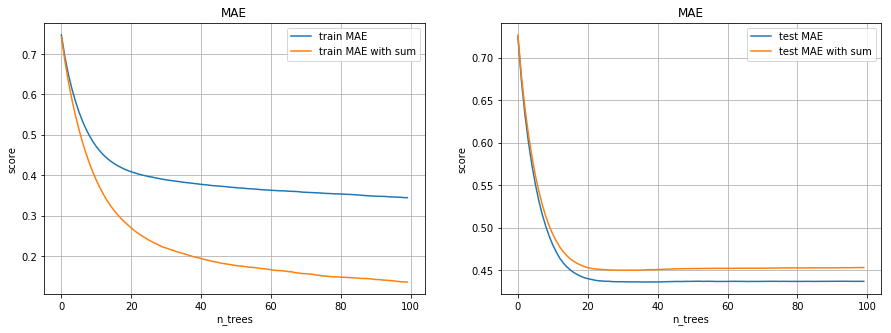

In [346]:
train_rmse_upd_sum, train_mae_upd_sum, test_rmse_upd_sum, test_mae_upd_sum = show_evals(evals_result_upd_sum)
plot_compare(train_eval_mae, 'train MAE', train_mae_upd_sum, 'train MAE with sum', test_eval_mae, 'test MAE', 
             test_mae_upd_sum, 'test MAE with sum')

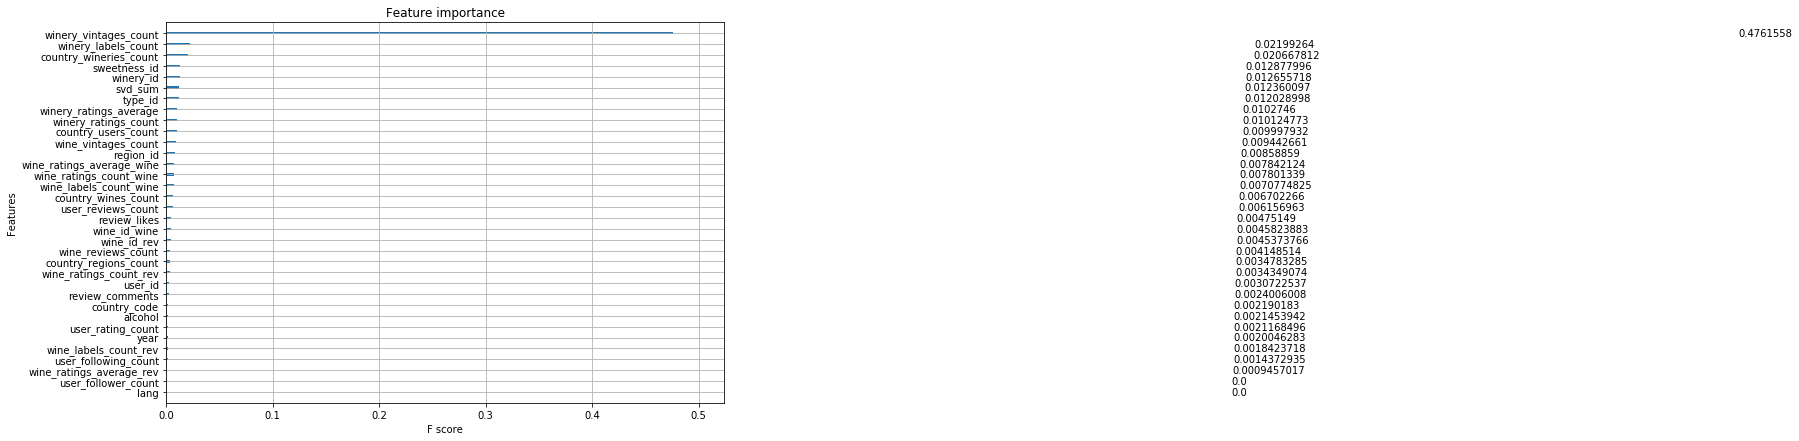

In [347]:
importances = OrderedDict(sorted(importances_upd_sum.items(), key=lambda x: -x[1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xgb.plot_importance(importances_ups_sum, ax=ax)

Судя по результатам предсказаний xgboost-а, добавление параметров матричной факторизации к признакам влечет быстрое переобучение, и, похоже, в этой задаче SVD нам не товарищ. Можно было бы, пожалуй, ещё позаниматься отбором обучающей выборки для SVD++, но это скорее всего не даст нам особого прироста, а данные будут ещё более синтетическими. 

Тем не менее, у нас есть ещё неиспользованные текстовые признаки, которые несут в себе немало информации для предсказания оценки. Остаётся прибегнуть к анализу текстов.

## Tf-IDF

С помощью меры tf-idf выделим наиболее важные (весомые) слова среди плохих и хороших отзывов. Так у нас появится срез слов, которые будут отражать позитивные и негативные нюансы текстового описания вина. Добавление информации о вхождении этих в слов в отзыв должен повысит качество предсказаниясамой оценки.

Тут мы, конечно, лукавим, так как в реальности у нас никогда не будет возможности посмотреть на отзыв отдельно от оценки, и такой подход всё-таки является заглядыванием в будущее. Тем не менее, интересно будет посмотреть на такую искусственную модель.

Возьмём хорошо оцененные вина и объединим их текстовое описание для каждого пользователя. Делается это исходя из того, что tf-idf взвешивается лучше на больших корпусах текста.

In [348]:
df3 = data_train[data_train['rating'] > 4.5][['user_id', 'wine_id_wine', 'wine_description', 'coment']]
df3.dropna(subset=['wine_id_wine', 'coment'], inplace=True)

df_good_user_coments = df3.groupby('user_id').agg({'coment': ' '.join})
df_good_user_coments.head()

,coment
user_id,
2954.0,Celebrating the 70th anniversary of the libera...
8868.0,Spicy and full. Really good!
8968.0,Non vintaged (yes yes)\noutstanding winy champ...
24200.0,A magnificent magnum purchased 7 years ago. Ve...
28125.0,Dark fruit intensive with oak-driven flavours....


In [349]:
from langdetect import detect
import re 
RE_EMOJI = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)

min_symbols = 10
def detectLanguage(text):
    filtered = RE_EMOJI.sub(r'', text[0])        # remove emodzi
    filtered = re.sub(r'[0-9]+', '', filtered)   # remove digits
    try:
        if(len(filtered) < min_symbols):
            return "unknown"
        else:
            return detect(filtered)
    except:
        return "unknown"

df_good_user_coments["lang"] = df_good_user_coments[['coment']].apply(detectLanguage, axis=1)

In [350]:
df_good_user_coments.lang.value_counts()

en         3026
af           63
pt           36
unknown      35
es           30
it           26
fr           25
nl           21
da           18
de           13
cy           12
ca           12
ro           12
no           10
ru            9
tl            5
et            3
sv            3
so            3
id            2
fi            2
sw            2
pl            2
lt            1
bg            1
tr            1
sl            1
Name: lang, dtype: int64

In [351]:
import string
import nltk

def text_preprocess(row):
    # приводим все слова к тексте к маленьким буквам
    row = row.lower()
    # вырезаем пунктуацию - переводим все знаки в пустую строку с пом. str.translate
    table = str.maketrans('', '', string.punctuation)
    row = row.translate(table)
    # переводим все числа в слово num(оно более информативно для анализа) регулярными выражениями
    row = re.sub(r'\d+', 'num', row)
    # удаляем смайлики
    row =  RE_EMOJI.sub(r'', row)     
    
    # из nltk заимствуем стоп-лист слов, переводим его в множество для ускорения
    stopwords = set(nltk.corpus.stopwords.words('english') + ['reuter', '\x03'])
    row = [word for word in row.split() if word not in stopwords]
    
    # стеммируем очищенный текст
    stemmer = nltk.stem.PorterStemmer()
    row = [" ".join([stemmer.stem(word) for word in row])]
    return row[0]

In [352]:
df_good_user_coments = df_good_user_coments[df_good_user_coments.lang=='en']

In [353]:
df_good_user_coments['preprocessed'] = df_good_user_coments['coment'].apply(text_preprocess)

In [354]:
df_good_user_coments.head()

,coment,lang,preprocessed
user_id,,,
2954.0,Celebrating the 70th anniversary of the libera...,en,celebr numth anniversari liber denmark candl w...
8868.0,Spicy and full. Really good!,en,spici full realli good
8968.0,Non vintaged (yes yes)\noutstanding winy champ...,en,non vintag ye ye outstand wini champagn non so...
24200.0,A magnificent magnum purchased 7 years ago. Ve...,en,magnific magnum purchas num year ago soft matu...
28125.0,Dark fruit intensive with oak-driven flavours....,en,dark fruit intens oakdriven flavour rich dens ...


Векторизуем полученные корпуса, ищем слова и пары слов. Сразу отсечём слишком часто встречающиеся, а значит неинформативные слова и словосочетания.

In [355]:
vect = TfidfVectorizer(ngram_range=(1,2), max_df=0.8, min_df=1)

In [356]:
%%time
good_coment_vectorized = vect.fit_transform(df_good_user_coments['preprocessed'])

CPU times: user 197 ms, sys: 15.2 ms, total: 212 ms
Wall time: 536 ms


In [357]:
good_coment_vectorized

<3026x40937 sparse matrix of type '<class 'numpy.float64'>'
	with 95071 stored elements in Compressed Sparse Row format>

In [358]:
good_words_list = vect.get_feature_names()
good_com_arr = good_coment_vectorized.toarray()
good_words_stat = []        

for i in range(good_com_arr.shape[1]):
    meet = [j for j in good_com_arr[:,i] if j!=0]
    num_meet = len(meet)
    mean_tfidf = np.sum(meet)/num_meet
    if num_meet > 20:                
        good_words_stat.append((good_words_list[i], num_meet, mean_tfidf))
good_words_stat = sorted(good_words_stat, key=lambda x: (-x[2], -x[1]))

Возьмём 20 самых важных слов (предварительно указав, что они должны встречаться не менее, чем в 20 документах - частотность тоже решает!).

In [359]:
print(len(good_words_stat))
top_good_words = good_words_stat[:20]
print(top_good_words)

461
[('sweet fruiti', 24, 0.36698601485023485), ('fruiti sweet', 31, 0.3457254874667301), ('great tast', 24, 0.3047807712242579), ('favorit wine', 32, 0.29853852901613664), ('good wine', 34, 0.2893906432388747), ('one favorit', 64, 0.28204437505769203), ('yummi', 23, 0.2699284683334681), ('excel wine', 25, 0.2575026656483518), ('love wine', 44, 0.2547269661584752), ('great valu', 21, 0.24982628860208062), ('easi drink', 60, 0.24207774135539548), ('tasti', 42, 0.23960914017206777), ('refresh', 90, 0.233528108875544), ('sweet wine', 27, 0.23334350706324467), ('white wine', 27, 0.22961775691305933), ('new year', 23, 0.22415050355216729), ('yum', 21, 0.2227027019045448), ('easi', 83, 0.21952127050700435), ('cold', 23, 0.214577171336754), ('chill', 25, 0.21290353409100882)]


И получим такой же анти-топ важных слов для плохих отзывов.

In [360]:
df4 = data_train[data_train['rating'] < 3][['user_id', 'wine_id_wine', 'wine_description', 'coment']]
df4.dropna(subset=['wine_id_wine', 'coment'], inplace=True)

df_bad_user_coments = df4.groupby('user_id').agg({'coment': ' '.join})
df_bad_user_coments.head()

,coment
user_id,
2764.0,"Dark fruit character, evident residual sugar, ..."
3299.0,"Lacking, thin, monotone."
16274.0,Fresh fruit and Medium body. Ok finish. Fresh ...
16603.0,Not sure if it was Wine !!! Not pleasant
19696.0,Not a bad little wine. Low cost; it doesn't re...


In [361]:
df_bad_user_coments["lang"] = df_bad_user_coments[['coment']].apply(detectLanguage, axis=1)
df_bad_user_coments.lang.value_counts()

en         2278
pt           59
es           50
af           48
unknown      37
it           36
no           27
ru           22
nl           20
da           18
de           18
fr           15
so            9
ca            6
et            5
sv            3
bg            3
cy            3
tl            2
tr            2
id            2
ko            2
fi            2
pl            2
sq            1
uk            1
ja            1
mk            1
sl            1
Name: lang, dtype: int64

In [362]:
df_bad_user_coments = df_bad_user_coments[df_bad_user_coments.lang=='en']
df_bad_user_coments['preprocessed'] = df_bad_user_coments['coment'].apply(text_preprocess)
df_bad_user_coments.head()

,coment,lang,preprocessed
user_id,,,
2764.0,"Dark fruit character, evident residual sugar, ...",en,dark fruit charact evid residu sugar high alco...
3299.0,"Lacking, thin, monotone.",en,lack thin monoton
16274.0,Fresh fruit and Medium body. Ok finish. Fresh ...,en,fresh fruit medium bodi ok finish fresh light ...
16603.0,Not sure if it was Wine !!! Not pleasant,en,sure wine pleasant
19696.0,Not a bad little wine. Low cost; it doesn't re...,en,bad littl wine low cost doesnt realli tast lik...


In [363]:
%%time
bad_coment_vectorized = vect.fit_transform(df_bad_user_coments['preprocessed'].values)

CPU times: user 159 ms, sys: 9 µs, total: 159 ms
Wall time: 158 ms


In [364]:
bad_words_list = vect.get_feature_names()
bad_com_arr = bad_coment_vectorized.toarray()
bad_words_stat = []            

for i in range(bad_com_arr.shape[1]):
    meet = [j for j in bad_com_arr[:,i] if j!=0]
    num_meet = len(meet)
    mean_tfidf = np.sum(meet)/num_meet
    if num_meet > 20:                
        bad_words_stat.append((bad_words_list[i], num_meet, mean_tfidf))
bad_words_stat = sorted(bad_words_stat, key=lambda x: (-x[2], -x[1]))

In [365]:
print(len(bad_words_stat))
top_bad_words = bad_words_stat[:20]
print(top_bad_words)

370
[('sweet tast', 24, 0.2621901951646523), ('favorit', 23, 0.22551997156048745), ('cheap wine', 23, 0.22225874242257967), ('good valu', 25, 0.21122600835848943), ('okay', 33, 0.21100130250795296), ('tabl wine', 53, 0.20748311459728508), ('noth special', 56, 0.19152588065793782), ('good wine', 23, 0.19152501357373464), ('cook', 43, 0.18853886988214866), ('money', 28, 0.1875486549519372), ('tabl', 67, 0.18432982082536434), ('everyday', 21, 0.1834357812933495), ('water', 32, 0.18209882582137776), ('sweeter', 28, 0.17919444967369727), ('cheer', 21, 0.17518111759866903), ('cheap', 119, 0.17261056693558885), ('dinner', 23, 0.17163868788523828), ('harsh', 34, 0.17143749002136033), ('special', 75, 0.17141616913101462), ('recommend', 32, 0.17065057272492182)]


Видно, что набор слов из плохох отзывов соержит неярко выраженную негативно окрашенную лексику, но слов "cheap wine", "meh", "water" вполне может быть достаточно. Можно лишь отметить общую культуру пользователей сревиса :)

Отлично, получили "хорошие" и "плохие" слова на обучающей выборке, самое время использовать эту информацию на всем датасете.

In [366]:
coments_train = data_train.dropna(subset=['coment'])[['coment']]
coments_test = data_test.dropna(subset=['coment'])[['coment']]

coments_train['lang'] = coments_train[['coment']].apply(detectLanguage, axis=1)
coments_test['lang'] = coments_test[['coment']].apply(detectLanguage, axis=1)

In [367]:
coments_train.lang.value_counts(), coments_test.lang.value_counts()

(en         76211
 pt          1241
 af           858
 es           635
 it           417
 unknown      385
 fr           295
 nl           283
 da           242
 no           202
 ru           188
 de           157
 ca           150
 ro           119
 cy           102
 et            74
 tl            67
 sv            52
 so            50
 pl            33
 id            21
 fi            19
 sl            14
 ja            14
 sk            13
 hr            13
 bg            13
 sq            13
 tr             9
 ko             7
 lt             6
 uk             5
 cs             4
 sw             4
 mk             2
 lv             2
 hu             1
 zh-tw          1
 zh-cn          1
 vi             1
 Name: lang, dtype: int64, en         14564
 pt           207
 af            83
 es            72
 it            52
 fr            40
 nl            34
 unknown       34
 no            28
 ca            27
 ru            24
 de            23
 ro            22
 da            18
 c

In [368]:
coments_train = coments_train[coments_train.lang=='en']
coments_test = coments_test[coments_test.lang=='en']

coments_train['preprocessed'] = coments_train['coment'].apply(text_preprocess)
coments_test['preprocessed'] = coments_test['coment'].apply(text_preprocess)
coments_train[coments_train.preprocessed.isna()]

,coment,lang,preprocessed


In [369]:
data_train = data_train.merge(coments_train, on=['coment', 'lang'], how='left').drop_duplicates()

In [370]:
data_test = data_test.merge(coments_test, on=['coment', 'lang'], how='left').drop_duplicates()

In [371]:
%%time
vectorized_coments = vect.transform(data_train['preprocessed'].values.astype('U'))
vectorized_com_test = vect.transform(data_test['preprocessed'].values.astype('U'))

CPU times: user 3.07 s, sys: 72.2 ms, total: 3.14 s
Wall time: 3.16 s


In [372]:
vect.vocabulary_     # здесь видим весь обученный словарь, применим его к топ-листу

{'dark': 7516,
 'fruit': 12140,
 'charact': 5245,
 'evid': 10038,
 'residu': 25248,
 'sugar': 29002,
 'high': 14337,
 'alcohol': 701,
 'slightli': 27288,
 'imbalanc': 15004,
 'dark fruit': 7530,
 'fruit charact': 12169,
 'charact evid': 5254,
 'evid residu': 10041,
 'residu sugar': 25253,
 'sugar high': 29014,
 'high alcohol': 14342,
 'alcohol slightli': 775,
 'slightli imbalanc': 27313,
 'lack': 16012,
 'thin': 30602,
 'monoton': 19030,
 'lack thin': 16067,
 'thin monoton': 30626,
 'fresh': 11945,
 'medium': 18278,
 'bodi': 3571,
 'ok': 21244,
 'finish': 10904,
 'light': 16587,
 'easi': 9301,
 'drink': 8857,
 'quit': 24366,
 'deliv': 7910,
 'promis': 24016,
 'verdejo': 32358,
 'white': 33211,
 'far': 10530,
 'near': 19546,
 'level': 16516,
 'rueda': 25848,
 'bland': 3388,
 'funni': 12634,
 'fizzi': 11220,
 'stuff': 28882,
 'dri': 8709,
 'sweet': 29295,
 'vanilla': 32208,
 'almond': 865,
 'flavour': 11444,
 'juici': 15719,
 'fine': 10858,
 'noth': 20461,
 'special': 27997,
 'redwin': 2

In [373]:
bad_words_idx = []
good_words_idx = []
for i in top_bad_words:
    if vect.vocabulary_.get(i[0]):
        bad_words_idx.append(vect.vocabulary_.get(i[0]))
for i in top_good_words:
    if vect.vocabulary_.get(i[0]):
        good_words_idx.append(vect.vocabulary_.get(i[0]))
print(bad_words_idx)
print(good_words_idx)

[29519, 10626, 5471, 13381, 21347, 29697, 20520, 13390, 6899, 19009, 29687, 10004, 32749, 29553, 5495, 5397, 8220, 14040, 27997, 24860]
[29383, 12511, 13712, 13390, 34666, 17569, 13716, 9312, 30323, 25047, 29541, 33280, 19707, 9301, 6309, 5746]


Как было и раньше видно, некоторые словосочетания есть и в топе, и в анти-топе, так что просто избавимся от дублёров, сократив число интересных для нас слов.

In [374]:
idx = bad_words_idx + good_words_idx
idx = list(set(idx))
len(idx)

35

Теперь наконец можем добавить веса, вычисленные на этих словах во всех комментариях. Чем большим весом будет обладать слово в конкретном документе, тем значимее должен быть этот признак. Добавим текстовые фичи в общую таблицу признаков и обучим xgboost.

In [375]:
tfidf_features = vectorized_coments[:, idx]
tfidf_feat_test = vectorized_com_test[:, idx]
tfidf_features

<81927x35 sparse matrix of type '<class 'numpy.float64'>'
	with 27215 stored elements in Compressed Sparse Row format>

In [376]:
X_train

array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         9.48000000e+02,  4.60000000e+01,  8.01459166e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         5.41200000e+03,  4.40000000e+01, -4.69940389e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         5.41200000e+03,  4.40000000e+01, -4.69940389e-01],
       ...,
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.06190000e+04,  6.60000000e+01, -1.27666758e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         2.74270000e+04,  1.16000000e+02,  5.94553482e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00, ...,
         1.47910000e+04,  1.40000000e+01, -1.13117550e-01]])

In [377]:
X_train, X_test, y_train, y_test = make_X_y(nltk=1)

for i in range(len(idx)):
    name = 'tfidf_' + str(i)
    X_train[name] = pd.Series([x[0] for x in tfidf_features[:,i].todense().tolist()], index=X_train.index)
    X_test[name] = pd.Series([x[0] for x in tfidf_feat_test[:,i].todense().tolist()], index=X_test.index)

imp_columns = X_train.columns

In [378]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 87) Тест:  (15300, 87)


## XGBoost с текстовыми признаками

In [379]:
evals_result_tf, importances_tf = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:28:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05191	validation_0-mae:0.744232	validation_1-rmse:1.01394	validation_1-mae:0.724506
[1]	validation_0-rmse:0.985279	validation_0-mae:0.686906	validation_1-rmse:0.959313	validation_1-mae:0.673747
[2]	validation_0-rmse:0.925839	validation_0-mae:0.638752	validation_1-rmse:0.913343	validation_1-mae:0.634519
[3]	validation_0-rmse:0.872274	validation_0-mae:0.596245	validation_1-rmse:0.873063	validation_1-mae:0.601575
[4]	validation_0-rmse:0.824757	validation_0-mae:0.559833	validation_1-rmse:0.840013	validation_1-mae:0.57467
[16:28:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05191	validation_0-mae:0.744232	validation_1-rmse:1.01394	validation_1-mae:0.724506
[1]	validation_0-rmse:0.985279	validation_0-mae:0.686906	validation_1-rmse:0.959313	validat

[19]	validation_0-rmse:0.495468	validation_0-mae:0.31521	validation_1-rmse:0.682993	validation_1-mae:0.4452
[20]	validation_0-rmse:0.487624	validation_0-mae:0.309581	validation_1-rmse:0.681257	validation_1-mae:0.444111
[21]	validation_0-rmse:0.479993	validation_0-mae:0.304372	validation_1-rmse:0.680109	validation_1-mae:0.443717
[22]	validation_0-rmse:0.473223	validation_0-mae:0.299645	validation_1-rmse:0.67925	validation_1-mae:0.443379
[23]	validation_0-rmse:0.467268	validation_0-mae:0.295235	validation_1-rmse:0.67819	validation_1-mae:0.442864
[24]	validation_0-rmse:0.462193	validation_0-mae:0.291784	validation_1-rmse:0.677505	validation_1-mae:0.442662
[16:29:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05191	validation_0-mae:0.744232	validation_1-rmse:1.01394	validation_1-mae:0.724506
[1]	validation_0-rmse:0.985279	validation_0-mae:0.686906	validation_1-rmse:0.959313	validation_1-mae:0.6

[0]	validation_0-rmse:1.05191	validation_0-mae:0.744232	validation_1-rmse:1.01394	validation_1-mae:0.724506
[1]	validation_0-rmse:0.985279	validation_0-mae:0.686906	validation_1-rmse:0.959313	validation_1-mae:0.673747
[2]	validation_0-rmse:0.925839	validation_0-mae:0.638752	validation_1-rmse:0.913343	validation_1-mae:0.634519
[3]	validation_0-rmse:0.872274	validation_0-mae:0.596245	validation_1-rmse:0.873063	validation_1-mae:0.601575
[4]	validation_0-rmse:0.824757	validation_0-mae:0.559833	validation_1-rmse:0.840013	validation_1-mae:0.57467
[5]	validation_0-rmse:0.78309	validation_0-mae:0.527851	validation_1-rmse:0.811576	validation_1-mae:0.551139
[6]	validation_0-rmse:0.745313	validation_0-mae:0.499101	validation_1-rmse:0.787906	validation_1-mae:0.531548
[7]	validation_0-rmse:0.710608	validation_0-mae:0.47321	validation_1-rmse:0.767852	validation_1-mae:0.515035
[8]	validation_0-rmse:0.679617	validation_0-mae:0.450058	validation_1-rmse:0.751436	validation_1-mae:0.500965
[9]	validation_

[34]	validation_0-rmse:0.42889	validation_0-mae:0.27044	validation_1-rmse:0.675116	validation_1-mae:0.443666
[35]	validation_0-rmse:0.426544	validation_0-mae:0.268979	validation_1-rmse:0.675007	validation_1-mae:0.443786
[36]	validation_0-rmse:0.424976	validation_0-mae:0.267827	validation_1-rmse:0.675065	validation_1-mae:0.444028
[37]	validation_0-rmse:0.421543	validation_0-mae:0.265896	validation_1-rmse:0.675099	validation_1-mae:0.444295
[38]	validation_0-rmse:0.420097	validation_0-mae:0.264858	validation_1-rmse:0.675094	validation_1-mae:0.444341
[39]	validation_0-rmse:0.4171	validation_0-mae:0.262899	validation_1-rmse:0.675015	validation_1-mae:0.444458
[40]	validation_0-rmse:0.414332	validation_0-mae:0.261004	validation_1-rmse:0.674913	validation_1-mae:0.444597
[41]	validation_0-rmse:0.411937	validation_0-mae:0.259502	validation_1-rmse:0.674866	validation_1-mae:0.444721
[42]	validation_0-rmse:0.410318	validation_0-mae:0.258359	validation_1-rmse:0.674776	validation_1-mae:0.44473
[43]	v

[11]	validation_0-rmse:0.605937	validation_0-mae:0.395129	validation_1-rmse:0.715826	validation_1-mae:0.471163
[12]	validation_0-rmse:0.586175	validation_0-mae:0.380603	validation_1-rmse:0.708449	validation_1-mae:0.464762
[13]	validation_0-rmse:0.568542	validation_0-mae:0.367514	validation_1-rmse:0.701948	validation_1-mae:0.459189
[14]	validation_0-rmse:0.553239	validation_0-mae:0.356233	validation_1-rmse:0.697032	validation_1-mae:0.455051
[15]	validation_0-rmse:0.538477	validation_0-mae:0.345935	validation_1-rmse:0.693171	validation_1-mae:0.45192
[16]	validation_0-rmse:0.526627	validation_0-mae:0.337437	validation_1-rmse:0.689777	validation_1-mae:0.449459
[17]	validation_0-rmse:0.515168	validation_0-mae:0.329291	validation_1-rmse:0.687121	validation_1-mae:0.447832
[18]	validation_0-rmse:0.505693	validation_0-mae:0.322255	validation_1-rmse:0.684829	validation_1-mae:0.446353
[19]	validation_0-rmse:0.495468	validation_0-mae:0.31521	validation_1-rmse:0.682993	validation_1-mae:0.4452
[20]	

[30]	validation_0-rmse:0.438172	validation_0-mae:0.276305	validation_1-rmse:0.675801	validation_1-mae:0.443063
[31]	validation_0-rmse:0.435483	validation_0-mae:0.274627	validation_1-rmse:0.675632	validation_1-mae:0.443246
[32]	validation_0-rmse:0.432116	validation_0-mae:0.272699	validation_1-rmse:0.675452	validation_1-mae:0.443379
[33]	validation_0-rmse:0.430323	validation_0-mae:0.271446	validation_1-rmse:0.675274	validation_1-mae:0.443495
[34]	validation_0-rmse:0.42889	validation_0-mae:0.27044	validation_1-rmse:0.675116	validation_1-mae:0.443666
[35]	validation_0-rmse:0.426544	validation_0-mae:0.268979	validation_1-rmse:0.675007	validation_1-mae:0.443786
[36]	validation_0-rmse:0.424976	validation_0-mae:0.267827	validation_1-rmse:0.675065	validation_1-mae:0.444028
[37]	validation_0-rmse:0.421543	validation_0-mae:0.265896	validation_1-rmse:0.675099	validation_1-mae:0.444295
[38]	validation_0-rmse:0.420097	validation_0-mae:0.264858	validation_1-rmse:0.675094	validation_1-mae:0.444341
[39

[44]	validation_0-rmse:0.407528	validation_0-mae:0.256557	validation_1-rmse:0.674556	validation_1-mae:0.444879
[45]	validation_0-rmse:0.40601	validation_0-mae:0.255428	validation_1-rmse:0.674434	validation_1-mae:0.444868
[46]	validation_0-rmse:0.405051	validation_0-mae:0.254731	validation_1-rmse:0.674448	validation_1-mae:0.444974
[47]	validation_0-rmse:0.403999	validation_0-mae:0.253891	validation_1-rmse:0.674379	validation_1-mae:0.444997
[48]	validation_0-rmse:0.401905	validation_0-mae:0.252488	validation_1-rmse:0.674279	validation_1-mae:0.44502
[49]	validation_0-rmse:0.40113	validation_0-mae:0.251916	validation_1-rmse:0.674253	validation_1-mae:0.445046
[50]	validation_0-rmse:0.400672	validation_0-mae:0.251536	validation_1-rmse:0.67425	validation_1-mae:0.445118
[51]	validation_0-rmse:0.400249	validation_0-mae:0.251184	validation_1-rmse:0.674214	validation_1-mae:0.445123
[52]	validation_0-rmse:0.39831	validation_0-mae:0.249768	validation_1-rmse:0.673998	validation_1-mae:0.444966
[53]	v

[53]	validation_0-rmse:0.397006	validation_0-mae:0.248957	validation_1-rmse:0.67397	validation_1-mae:0.444994
[54]	validation_0-rmse:0.395919	validation_0-mae:0.248298	validation_1-rmse:0.673915	validation_1-mae:0.445084
[55]	validation_0-rmse:0.394864	validation_0-mae:0.247534	validation_1-rmse:0.673894	validation_1-mae:0.445141
[56]	validation_0-rmse:0.390203	validation_0-mae:0.244423	validation_1-rmse:0.673769	validation_1-mae:0.44507
[57]	validation_0-rmse:0.388917	validation_0-mae:0.243509	validation_1-rmse:0.673695	validation_1-mae:0.445006
[58]	validation_0-rmse:0.387804	validation_0-mae:0.242717	validation_1-rmse:0.673598	validation_1-mae:0.44499
[59]	validation_0-rmse:0.385575	validation_0-mae:0.241201	validation_1-rmse:0.673613	validation_1-mae:0.445112
[60]	validation_0-rmse:0.383737	validation_0-mae:0.240203	validation_1-rmse:0.673644	validation_1-mae:0.445171
[61]	validation_0-rmse:0.38273	validation_0-mae:0.239508	validation_1-rmse:0.673505	validation_1-mae:0.445086
[62]	

[56]	validation_0-rmse:0.390203	validation_0-mae:0.244423	validation_1-rmse:0.673769	validation_1-mae:0.44507
[57]	validation_0-rmse:0.388917	validation_0-mae:0.243509	validation_1-rmse:0.673695	validation_1-mae:0.445006
[58]	validation_0-rmse:0.387804	validation_0-mae:0.242717	validation_1-rmse:0.673598	validation_1-mae:0.44499
[59]	validation_0-rmse:0.385575	validation_0-mae:0.241201	validation_1-rmse:0.673613	validation_1-mae:0.445112
[60]	validation_0-rmse:0.383737	validation_0-mae:0.240203	validation_1-rmse:0.673644	validation_1-mae:0.445171
[61]	validation_0-rmse:0.38273	validation_0-mae:0.239508	validation_1-rmse:0.673505	validation_1-mae:0.445086
[62]	validation_0-rmse:0.382523	validation_0-mae:0.239301	validation_1-rmse:0.673482	validation_1-mae:0.445097
[63]	validation_0-rmse:0.380666	validation_0-mae:0.237999	validation_1-rmse:0.673502	validation_1-mae:0.445163
[64]	validation_0-rmse:0.377995	validation_0-mae:0.236342	validation_1-rmse:0.673458	validation_1-mae:0.445125
[65]

[54]	validation_0-rmse:0.395919	validation_0-mae:0.248298	validation_1-rmse:0.673915	validation_1-mae:0.445084
[55]	validation_0-rmse:0.394864	validation_0-mae:0.247534	validation_1-rmse:0.673894	validation_1-mae:0.445141
[56]	validation_0-rmse:0.390203	validation_0-mae:0.244423	validation_1-rmse:0.673769	validation_1-mae:0.44507
[57]	validation_0-rmse:0.388917	validation_0-mae:0.243509	validation_1-rmse:0.673695	validation_1-mae:0.445006
[58]	validation_0-rmse:0.387804	validation_0-mae:0.242717	validation_1-rmse:0.673598	validation_1-mae:0.44499
[59]	validation_0-rmse:0.385575	validation_0-mae:0.241201	validation_1-rmse:0.673613	validation_1-mae:0.445112
[60]	validation_0-rmse:0.383737	validation_0-mae:0.240203	validation_1-rmse:0.673644	validation_1-mae:0.445171
[61]	validation_0-rmse:0.38273	validation_0-mae:0.239508	validation_1-rmse:0.673505	validation_1-mae:0.445086
[62]	validation_0-rmse:0.382523	validation_0-mae:0.239301	validation_1-rmse:0.673482	validation_1-mae:0.445097
[63]

[47]	validation_0-rmse:0.403999	validation_0-mae:0.253891	validation_1-rmse:0.674379	validation_1-mae:0.444997
[48]	validation_0-rmse:0.401905	validation_0-mae:0.252488	validation_1-rmse:0.674279	validation_1-mae:0.44502
[49]	validation_0-rmse:0.40113	validation_0-mae:0.251916	validation_1-rmse:0.674253	validation_1-mae:0.445046
[50]	validation_0-rmse:0.400672	validation_0-mae:0.251536	validation_1-rmse:0.67425	validation_1-mae:0.445118
[51]	validation_0-rmse:0.400249	validation_0-mae:0.251184	validation_1-rmse:0.674214	validation_1-mae:0.445123
[52]	validation_0-rmse:0.39831	validation_0-mae:0.249768	validation_1-rmse:0.673998	validation_1-mae:0.444966
[53]	validation_0-rmse:0.397006	validation_0-mae:0.248957	validation_1-rmse:0.67397	validation_1-mae:0.444994
[54]	validation_0-rmse:0.395919	validation_0-mae:0.248298	validation_1-rmse:0.673915	validation_1-mae:0.445084
[55]	validation_0-rmse:0.394864	validation_0-mae:0.247534	validation_1-rmse:0.673894	validation_1-mae:0.445141
[56]	v

[35]	validation_0-rmse:0.426544	validation_0-mae:0.268979	validation_1-rmse:0.675007	validation_1-mae:0.443786
[36]	validation_0-rmse:0.424976	validation_0-mae:0.267827	validation_1-rmse:0.675065	validation_1-mae:0.444028
[37]	validation_0-rmse:0.421543	validation_0-mae:0.265896	validation_1-rmse:0.675099	validation_1-mae:0.444295
[38]	validation_0-rmse:0.420097	validation_0-mae:0.264858	validation_1-rmse:0.675094	validation_1-mae:0.444341
[39]	validation_0-rmse:0.4171	validation_0-mae:0.262899	validation_1-rmse:0.675015	validation_1-mae:0.444458
[40]	validation_0-rmse:0.414332	validation_0-mae:0.261004	validation_1-rmse:0.674913	validation_1-mae:0.444597
[41]	validation_0-rmse:0.411937	validation_0-mae:0.259502	validation_1-rmse:0.674866	validation_1-mae:0.444721
[42]	validation_0-rmse:0.410318	validation_0-mae:0.258359	validation_1-rmse:0.674776	validation_1-mae:0.44473
[43]	validation_0-rmse:0.409302	validation_0-mae:0.257591	validation_1-rmse:0.674684	validation_1-mae:0.444859
[44]

[18]	validation_0-rmse:0.505693	validation_0-mae:0.322255	validation_1-rmse:0.684829	validation_1-mae:0.446353
[19]	validation_0-rmse:0.495468	validation_0-mae:0.31521	validation_1-rmse:0.682993	validation_1-mae:0.4452
[20]	validation_0-rmse:0.487624	validation_0-mae:0.309581	validation_1-rmse:0.681257	validation_1-mae:0.444111
[21]	validation_0-rmse:0.479993	validation_0-mae:0.304372	validation_1-rmse:0.680109	validation_1-mae:0.443717
[22]	validation_0-rmse:0.473223	validation_0-mae:0.299645	validation_1-rmse:0.67925	validation_1-mae:0.443379
[23]	validation_0-rmse:0.467268	validation_0-mae:0.295235	validation_1-rmse:0.67819	validation_1-mae:0.442864
[24]	validation_0-rmse:0.462193	validation_0-mae:0.291784	validation_1-rmse:0.677505	validation_1-mae:0.442662
[25]	validation_0-rmse:0.457099	validation_0-mae:0.288439	validation_1-rmse:0.676978	validation_1-mae:0.442573
[26]	validation_0-rmse:0.452576	validation_0-mae:0.285394	validation_1-rmse:0.676776	validation_1-mae:0.442759
[27]	v

[93]	validation_0-rmse:0.350186	validation_0-mae:0.216666	validation_1-rmse:0.672354	validation_1-mae:0.44461
[94]	validation_0-rmse:0.350019	validation_0-mae:0.216488	validation_1-rmse:0.672364	validation_1-mae:0.444647
[16:34:59] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05191	validation_0-mae:0.744232	validation_1-rmse:1.01394	validation_1-mae:0.724506
[1]	validation_0-rmse:0.985279	validation_0-mae:0.686906	validation_1-rmse:0.959313	validation_1-mae:0.673747
[2]	validation_0-rmse:0.925839	validation_0-mae:0.638752	validation_1-rmse:0.913343	validation_1-mae:0.634519
[3]	validation_0-rmse:0.872274	validation_0-mae:0.596245	validation_1-rmse:0.873063	validation_1-mae:0.601575
[4]	validation_0-rmse:0.824757	validation_0-mae:0.559833	validation_1-rmse:0.840013	validation_1-mae:0.57467
[5]	validation_0-rmse:0.78309	validation_0-mae:0.527851	validation_1-rmse:0.811576	validation_1-mae:0.551

[71]	validation_0-rmse:0.372145	validation_0-mae:0.231945	validation_1-rmse:0.672951	validation_1-mae:0.44477
[72]	validation_0-rmse:0.371361	validation_0-mae:0.231176	validation_1-rmse:0.672728	validation_1-mae:0.444584
[73]	validation_0-rmse:0.370532	validation_0-mae:0.230537	validation_1-rmse:0.672736	validation_1-mae:0.44461
[74]	validation_0-rmse:0.369056	validation_0-mae:0.229721	validation_1-rmse:0.672872	validation_1-mae:0.444703
[75]	validation_0-rmse:0.367044	validation_0-mae:0.228373	validation_1-rmse:0.672801	validation_1-mae:0.444678
[76]	validation_0-rmse:0.366194	validation_0-mae:0.227744	validation_1-rmse:0.672842	validation_1-mae:0.444662
[77]	validation_0-rmse:0.366009	validation_0-mae:0.227565	validation_1-rmse:0.672821	validation_1-mae:0.444684
[78]	validation_0-rmse:0.364881	validation_0-mae:0.226874	validation_1-rmse:0.67279	validation_1-mae:0.444742
[79]	validation_0-rmse:0.364469	validation_0-mae:0.226485	validation_1-rmse:0.672704	validation_1-mae:0.44468
[80]	

[0.724506, 0.673747, 0.634519, 0.601575, 0.57467, 0.551139, 0.531548, 0.515035, 0.500965, 0.488903]


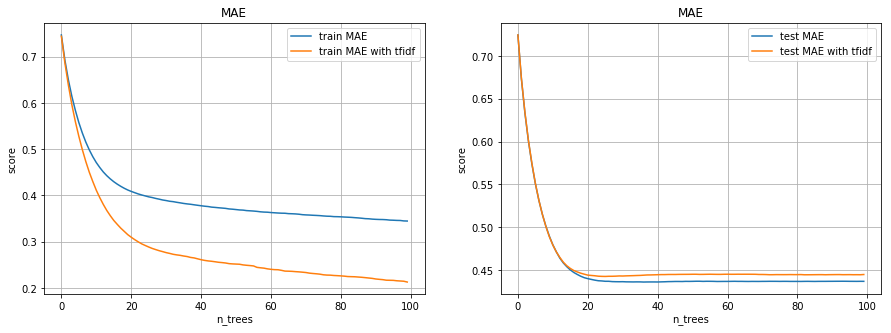

In [380]:
train_rmse_tf, train_mae_tf, test_rmse_tf, test_mae_tf = show_evals(evals_result_tf)
plot_compare(train_eval_mae, 'train MAE', train_mae_tf, 'train MAE with tfidf', test_eval_mae, 'test MAE', 
             test_mae_tf, 'test MAE with tfidf')

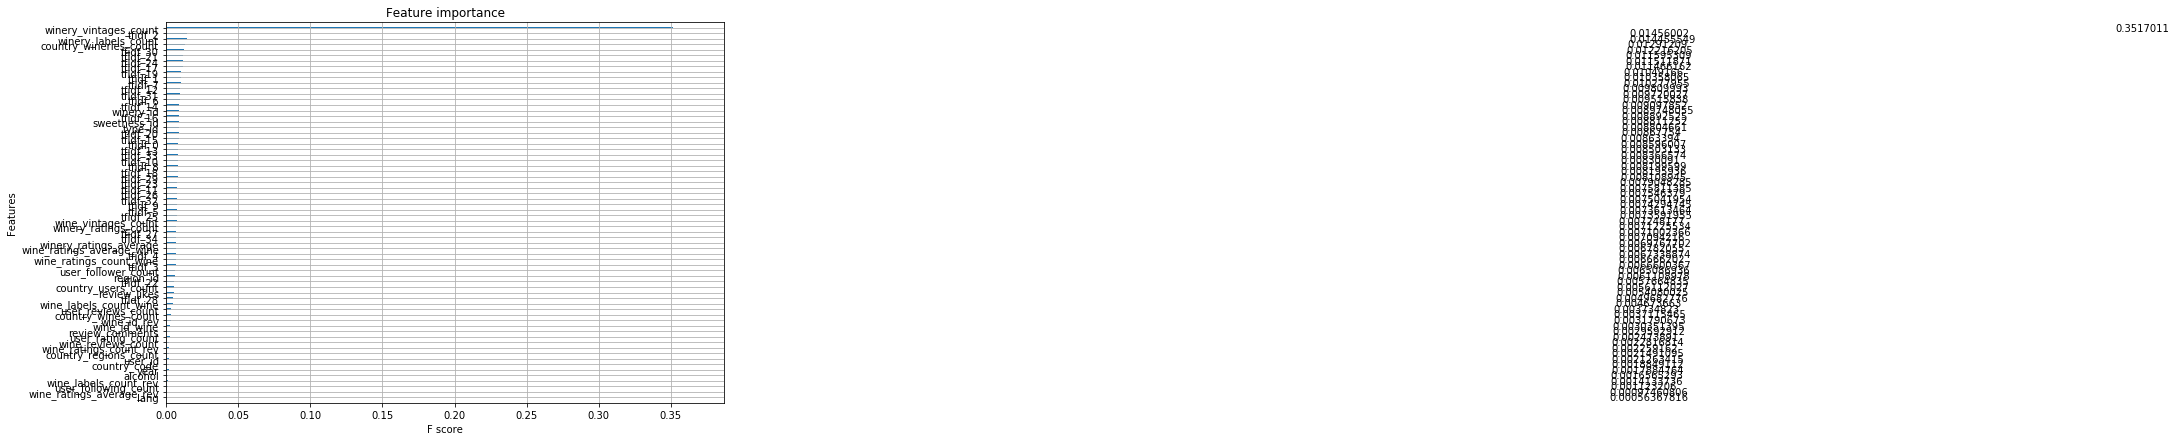

In [381]:
importances = OrderedDict(sorted(importances_tf.items(), key=lambda x: -x[1]))

fig, ax = plt.subplots(1, 1, figsize=(10, 7))
xgb.plot_importance(importances_tf, ax=ax)

Улучшения особо незаметно, на обучении его нет вообще. На всякий лучай посмотрим, может произойдёт чудо и меры tf-idf возымеют эффект совместно с SVD? Сравним все.

## Random Tree Embedding

Попробуем ещё вот эту штуку, Женя сказал

In [382]:
from sklearn.ensemble import RandomTreesEmbedding

rte = RandomTreesEmbedding(n_estimators=20, max_depth=10, random_state=42)

In [383]:
tfidf_features = vectorized_coments[:, idx]
tfidf_feat_test = vectorized_com_test[:, idx]
tfidf_features

<81927x35 sparse matrix of type '<class 'numpy.float64'>'
	with 27215 stored elements in Compressed Sparse Row format>

In [384]:
%time
tfidf_features = rte.fit_transform(tfidf_features)
tfidf_feat_test = rte.transform(tfidf_feat_test)
tfidf_features

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 7.15 µs


<81927x1684 sparse matrix of type '<class 'numpy.float64'>'
	with 1638540 stored elements in Compressed Sparse Row format>

In [385]:
X_train, X_test, y_train, y_test = make_X_y(nltk=1)

for i in range(len(idx)):
    name = 'tfidf_' + str(i)
    X_train[name] = pd.Series([x[0] for x in tfidf_features[:,i].todense().tolist()], index=X_train.index)
    X_test[name] = pd.Series([x[0] for x in tfidf_feat_test[:,i].todense().tolist()], index=X_test.index)

imp_columns = X_train.columns

In [386]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, 'Тест: ', X_test.shape)

Обучение:  (81927, 87) Тест:  (15300, 87)


In [387]:
evals_result_embed, importances_embed = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:37:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05068	validation_0-mae:0.743871	validation_1-rmse:1.01483	validation_1-mae:0.725001
[1]	validation_0-rmse:0.982772	validation_0-mae:0.68609	validation_1-rmse:0.960589	validation_1-mae:0.6749
[2]	validation_0-rmse:0.921463	validation_0-mae:0.636909	validation_1-rmse:0.915415	validation_1-mae:0.635993
[3]	validation_0-rmse:0.867469	validation_0-mae:0.59413	validation_1-rmse:0.876677	validation_1-mae:0.603697
[4]	validation_0-rmse:0.818747	validation_0-mae:0.556348	validation_1-rmse:0.843543	validation_1-mae:0.576484
[16:37:39] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05068	validation_0-mae:0.743871	validation_1-rmse:1.01483	validation_1-mae:0.725001
[1]	validation_0-rmse:0.982772	validation_0-mae:0.68609	validation_1-rmse:0.960589	validation_

[19]	validation_0-rmse:0.457718	validation_0-mae:0.292124	validation_1-rmse:0.688808	validation_1-mae:0.448995
[20]	validation_0-rmse:0.447039	validation_0-mae:0.284649	validation_1-rmse:0.687485	validation_1-mae:0.448249
[21]	validation_0-rmse:0.437157	validation_0-mae:0.277774	validation_1-rmse:0.686265	validation_1-mae:0.44759
[22]	validation_0-rmse:0.428561	validation_0-mae:0.271944	validation_1-rmse:0.685448	validation_1-mae:0.447131
[23]	validation_0-rmse:0.421184	validation_0-mae:0.266623	validation_1-rmse:0.684339	validation_1-mae:0.446775
[24]	validation_0-rmse:0.413234	validation_0-mae:0.261311	validation_1-rmse:0.683809	validation_1-mae:0.446758
[16:38:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.05068	validation_0-mae:0.743871	validation_1-rmse:1.01483	validation_1-mae:0.725001
[1]	validation_0-rmse:0.982772	validation_0-mae:0.68609	validation_1-rmse:0.960589	validation_1-mae:

[0]	validation_0-rmse:1.05068	validation_0-mae:0.743871	validation_1-rmse:1.01483	validation_1-mae:0.725001
[1]	validation_0-rmse:0.982772	validation_0-mae:0.68609	validation_1-rmse:0.960589	validation_1-mae:0.6749
[2]	validation_0-rmse:0.921463	validation_0-mae:0.636909	validation_1-rmse:0.915415	validation_1-mae:0.635993
[3]	validation_0-rmse:0.867469	validation_0-mae:0.59413	validation_1-rmse:0.876677	validation_1-mae:0.603697
[4]	validation_0-rmse:0.818747	validation_0-mae:0.556348	validation_1-rmse:0.843543	validation_1-mae:0.576484
[5]	validation_0-rmse:0.774161	validation_0-mae:0.522733	validation_1-rmse:0.814989	validation_1-mae:0.55349
[6]	validation_0-rmse:0.734258	validation_0-mae:0.493178	validation_1-rmse:0.791583	validation_1-mae:0.534416
[7]	validation_0-rmse:0.698289	validation_0-mae:0.466491	validation_1-rmse:0.771536	validation_1-mae:0.518081
[8]	validation_0-rmse:0.666371	validation_0-mae:0.442739	validation_1-rmse:0.754991	validation_1-mae:0.504177
[9]	validation_0-

[34]	validation_0-rmse:0.358942	validation_0-mae:0.224405	validation_1-rmse:0.681491	validation_1-mae:0.447468
[35]	validation_0-rmse:0.35435	validation_0-mae:0.221792	validation_1-rmse:0.68145	validation_1-mae:0.447617
[36]	validation_0-rmse:0.351094	validation_0-mae:0.219818	validation_1-rmse:0.681468	validation_1-mae:0.447902
[37]	validation_0-rmse:0.34861	validation_0-mae:0.218052	validation_1-rmse:0.681399	validation_1-mae:0.447966
[38]	validation_0-rmse:0.346478	validation_0-mae:0.216598	validation_1-rmse:0.681362	validation_1-mae:0.448112
[39]	validation_0-rmse:0.343071	validation_0-mae:0.214484	validation_1-rmse:0.681396	validation_1-mae:0.448338
[40]	validation_0-rmse:0.340375	validation_0-mae:0.212634	validation_1-rmse:0.681497	validation_1-mae:0.448504
[41]	validation_0-rmse:0.338245	validation_0-mae:0.211169	validation_1-rmse:0.681406	validation_1-mae:0.448556
[42]	validation_0-rmse:0.336266	validation_0-mae:0.209837	validation_1-rmse:0.681401	validation_1-mae:0.44861
[43]	

[12]	validation_0-rmse:0.564099	validation_0-mae:0.367777	validation_1-rmse:0.713454	validation_1-mae:0.468291
[13]	validation_0-rmse:0.543894	validation_0-mae:0.353314	validation_1-rmse:0.70753	validation_1-mae:0.463292
[14]	validation_0-rmse:0.525326	validation_0-mae:0.34003	validation_1-rmse:0.702517	validation_1-mae:0.459354
[15]	validation_0-rmse:0.509761	validation_0-mae:0.328876	validation_1-rmse:0.698584	validation_1-mae:0.456243
[16]	validation_0-rmse:0.495571	validation_0-mae:0.318536	validation_1-rmse:0.695306	validation_1-mae:0.453643
[17]	validation_0-rmse:0.481302	validation_0-mae:0.308734	validation_1-rmse:0.69266	validation_1-mae:0.451742
[18]	validation_0-rmse:0.468903	validation_0-mae:0.299947	validation_1-rmse:0.690577	validation_1-mae:0.450202
[19]	validation_0-rmse:0.457718	validation_0-mae:0.292124	validation_1-rmse:0.688808	validation_1-mae:0.448995
[20]	validation_0-rmse:0.447039	validation_0-mae:0.284649	validation_1-rmse:0.687485	validation_1-mae:0.448249
[21]

[31]	validation_0-rmse:0.371187	validation_0-mae:0.232706	validation_1-rmse:0.681796	validation_1-mae:0.447212
[32]	validation_0-rmse:0.367161	validation_0-mae:0.229944	validation_1-rmse:0.681799	validation_1-mae:0.447351
[33]	validation_0-rmse:0.363331	validation_0-mae:0.227311	validation_1-rmse:0.681676	validation_1-mae:0.447396
[34]	validation_0-rmse:0.358942	validation_0-mae:0.224405	validation_1-rmse:0.681491	validation_1-mae:0.447468
[35]	validation_0-rmse:0.35435	validation_0-mae:0.221792	validation_1-rmse:0.68145	validation_1-mae:0.447617
[36]	validation_0-rmse:0.351094	validation_0-mae:0.219818	validation_1-rmse:0.681468	validation_1-mae:0.447902
[37]	validation_0-rmse:0.34861	validation_0-mae:0.218052	validation_1-rmse:0.681399	validation_1-mae:0.447966
[38]	validation_0-rmse:0.346478	validation_0-mae:0.216598	validation_1-rmse:0.681362	validation_1-mae:0.448112
[39]	validation_0-rmse:0.343071	validation_0-mae:0.214484	validation_1-rmse:0.681396	validation_1-mae:0.448338
[40]

[45]	validation_0-rmse:0.326543	validation_0-mae:0.203784	validation_1-rmse:0.681315	validation_1-mae:0.448791
[46]	validation_0-rmse:0.323823	validation_0-mae:0.20206	validation_1-rmse:0.681324	validation_1-mae:0.448896
[47]	validation_0-rmse:0.320629	validation_0-mae:0.200092	validation_1-rmse:0.681457	validation_1-mae:0.449048
[48]	validation_0-rmse:0.318402	validation_0-mae:0.198704	validation_1-rmse:0.68156	validation_1-mae:0.449167
[49]	validation_0-rmse:0.317012	validation_0-mae:0.197726	validation_1-rmse:0.681729	validation_1-mae:0.449324
[50]	validation_0-rmse:0.315937	validation_0-mae:0.19681	validation_1-rmse:0.681566	validation_1-mae:0.449201
[51]	validation_0-rmse:0.314238	validation_0-mae:0.195698	validation_1-rmse:0.681634	validation_1-mae:0.449283
[52]	validation_0-rmse:0.311912	validation_0-mae:0.194191	validation_1-rmse:0.681641	validation_1-mae:0.449372
[53]	validation_0-rmse:0.311054	validation_0-mae:0.193448	validation_1-rmse:0.681566	validation_1-mae:0.449321
[54]

[54]	validation_0-rmse:0.308646	validation_0-mae:0.191789	validation_1-rmse:0.68154	validation_1-mae:0.449269
[55]	validation_0-rmse:0.307215	validation_0-mae:0.190668	validation_1-rmse:0.681489	validation_1-mae:0.449246
[56]	validation_0-rmse:0.304704	validation_0-mae:0.189184	validation_1-rmse:0.681446	validation_1-mae:0.449292
[57]	validation_0-rmse:0.301762	validation_0-mae:0.187295	validation_1-rmse:0.681392	validation_1-mae:0.449346
[58]	validation_0-rmse:0.301148	validation_0-mae:0.186698	validation_1-rmse:0.681361	validation_1-mae:0.449315
[59]	validation_0-rmse:0.298777	validation_0-mae:0.185068	validation_1-rmse:0.681454	validation_1-mae:0.449362
[60]	validation_0-rmse:0.297619	validation_0-mae:0.184107	validation_1-rmse:0.681379	validation_1-mae:0.449296
[61]	validation_0-rmse:0.293547	validation_0-mae:0.181414	validation_1-rmse:0.681364	validation_1-mae:0.449483
[62]	validation_0-rmse:0.291936	validation_0-mae:0.180286	validation_1-rmse:0.681451	validation_1-mae:0.449571
[6

[58]	validation_0-rmse:0.301148	validation_0-mae:0.186698	validation_1-rmse:0.681361	validation_1-mae:0.449315
[59]	validation_0-rmse:0.298777	validation_0-mae:0.185068	validation_1-rmse:0.681454	validation_1-mae:0.449362
[60]	validation_0-rmse:0.297619	validation_0-mae:0.184107	validation_1-rmse:0.681379	validation_1-mae:0.449296
[61]	validation_0-rmse:0.293547	validation_0-mae:0.181414	validation_1-rmse:0.681364	validation_1-mae:0.449483
[62]	validation_0-rmse:0.291936	validation_0-mae:0.180286	validation_1-rmse:0.681451	validation_1-mae:0.449571
[63]	validation_0-rmse:0.291117	validation_0-mae:0.179666	validation_1-rmse:0.681499	validation_1-mae:0.449569
[64]	validation_0-rmse:0.290272	validation_0-mae:0.179084	validation_1-rmse:0.681424	validation_1-mae:0.449508
[65]	validation_0-rmse:0.287691	validation_0-mae:0.17716	validation_1-rmse:0.681466	validation_1-mae:0.449706
[66]	validation_0-rmse:0.287298	validation_0-mae:0.176682	validation_1-rmse:0.681381	validation_1-mae:0.449663
[6

[57]	validation_0-rmse:0.301762	validation_0-mae:0.187295	validation_1-rmse:0.681392	validation_1-mae:0.449346
[58]	validation_0-rmse:0.301148	validation_0-mae:0.186698	validation_1-rmse:0.681361	validation_1-mae:0.449315
[59]	validation_0-rmse:0.298777	validation_0-mae:0.185068	validation_1-rmse:0.681454	validation_1-mae:0.449362
[60]	validation_0-rmse:0.297619	validation_0-mae:0.184107	validation_1-rmse:0.681379	validation_1-mae:0.449296
[61]	validation_0-rmse:0.293547	validation_0-mae:0.181414	validation_1-rmse:0.681364	validation_1-mae:0.449483
[62]	validation_0-rmse:0.291936	validation_0-mae:0.180286	validation_1-rmse:0.681451	validation_1-mae:0.449571
[63]	validation_0-rmse:0.291117	validation_0-mae:0.179666	validation_1-rmse:0.681499	validation_1-mae:0.449569
[64]	validation_0-rmse:0.290272	validation_0-mae:0.179084	validation_1-rmse:0.681424	validation_1-mae:0.449508
[65]	validation_0-rmse:0.287691	validation_0-mae:0.17716	validation_1-rmse:0.681466	validation_1-mae:0.449706
[6

[51]	validation_0-rmse:0.314238	validation_0-mae:0.195698	validation_1-rmse:0.681634	validation_1-mae:0.449283
[52]	validation_0-rmse:0.311912	validation_0-mae:0.194191	validation_1-rmse:0.681641	validation_1-mae:0.449372
[53]	validation_0-rmse:0.311054	validation_0-mae:0.193448	validation_1-rmse:0.681566	validation_1-mae:0.449321
[54]	validation_0-rmse:0.308646	validation_0-mae:0.191789	validation_1-rmse:0.68154	validation_1-mae:0.449269
[55]	validation_0-rmse:0.307215	validation_0-mae:0.190668	validation_1-rmse:0.681489	validation_1-mae:0.449246
[56]	validation_0-rmse:0.304704	validation_0-mae:0.189184	validation_1-rmse:0.681446	validation_1-mae:0.449292
[57]	validation_0-rmse:0.301762	validation_0-mae:0.187295	validation_1-rmse:0.681392	validation_1-mae:0.449346
[58]	validation_0-rmse:0.301148	validation_0-mae:0.186698	validation_1-rmse:0.681361	validation_1-mae:0.449315
[59]	validation_0-rmse:0.298777	validation_0-mae:0.185068	validation_1-rmse:0.681454	validation_1-mae:0.449362
[6

[39]	validation_0-rmse:0.343071	validation_0-mae:0.214484	validation_1-rmse:0.681396	validation_1-mae:0.448338
[40]	validation_0-rmse:0.340375	validation_0-mae:0.212634	validation_1-rmse:0.681497	validation_1-mae:0.448504
[41]	validation_0-rmse:0.338245	validation_0-mae:0.211169	validation_1-rmse:0.681406	validation_1-mae:0.448556
[42]	validation_0-rmse:0.336266	validation_0-mae:0.209837	validation_1-rmse:0.681401	validation_1-mae:0.44861
[43]	validation_0-rmse:0.333205	validation_0-mae:0.207895	validation_1-rmse:0.681378	validation_1-mae:0.448604
[44]	validation_0-rmse:0.330469	validation_0-mae:0.206015	validation_1-rmse:0.68126	validation_1-mae:0.448573
[45]	validation_0-rmse:0.326543	validation_0-mae:0.203784	validation_1-rmse:0.681315	validation_1-mae:0.448791
[46]	validation_0-rmse:0.323823	validation_0-mae:0.20206	validation_1-rmse:0.681324	validation_1-mae:0.448896
[47]	validation_0-rmse:0.320629	validation_0-mae:0.200092	validation_1-rmse:0.681457	validation_1-mae:0.449048
[48]

[22]	validation_0-rmse:0.428561	validation_0-mae:0.271944	validation_1-rmse:0.685448	validation_1-mae:0.447131
[23]	validation_0-rmse:0.421184	validation_0-mae:0.266623	validation_1-rmse:0.684339	validation_1-mae:0.446775
[24]	validation_0-rmse:0.413234	validation_0-mae:0.261311	validation_1-rmse:0.683809	validation_1-mae:0.446758
[25]	validation_0-rmse:0.405867	validation_0-mae:0.256331	validation_1-rmse:0.683349	validation_1-mae:0.447073
[26]	validation_0-rmse:0.398965	validation_0-mae:0.251427	validation_1-rmse:0.683039	validation_1-mae:0.4471
[27]	validation_0-rmse:0.392694	validation_0-mae:0.247055	validation_1-rmse:0.682385	validation_1-mae:0.446849
[28]	validation_0-rmse:0.38637	validation_0-mae:0.242749	validation_1-rmse:0.682208	validation_1-mae:0.446911
[29]	validation_0-rmse:0.381779	validation_0-mae:0.23952	validation_1-rmse:0.681937	validation_1-mae:0.446923
[30]	validation_0-rmse:0.376236	validation_0-mae:0.23602	validation_1-rmse:0.681837	validation_1-mae:0.447118
[31]	v

[0]	validation_0-rmse:1.05068	validation_0-mae:0.743871	validation_1-rmse:1.01483	validation_1-mae:0.725001
[1]	validation_0-rmse:0.982772	validation_0-mae:0.68609	validation_1-rmse:0.960589	validation_1-mae:0.6749
[2]	validation_0-rmse:0.921463	validation_0-mae:0.636909	validation_1-rmse:0.915415	validation_1-mae:0.635993
[3]	validation_0-rmse:0.867469	validation_0-mae:0.59413	validation_1-rmse:0.876677	validation_1-mae:0.603697
[4]	validation_0-rmse:0.818747	validation_0-mae:0.556348	validation_1-rmse:0.843543	validation_1-mae:0.576484
[5]	validation_0-rmse:0.774161	validation_0-mae:0.522733	validation_1-rmse:0.814989	validation_1-mae:0.55349
[6]	validation_0-rmse:0.734258	validation_0-mae:0.493178	validation_1-rmse:0.791583	validation_1-mae:0.534416
[7]	validation_0-rmse:0.698289	validation_0-mae:0.466491	validation_1-rmse:0.771536	validation_1-mae:0.518081
[8]	validation_0-rmse:0.666371	validation_0-mae:0.442739	validation_1-rmse:0.754991	validation_1-mae:0.504177
[9]	validation_0-

[75]	validation_0-rmse:0.276662	validation_0-mae:0.169294	validation_1-rmse:0.680964	validation_1-mae:0.449584
[76]	validation_0-rmse:0.274436	validation_0-mae:0.167754	validation_1-rmse:0.680979	validation_1-mae:0.449674
[77]	validation_0-rmse:0.273789	validation_0-mae:0.167092	validation_1-rmse:0.68092	validation_1-mae:0.449621
[78]	validation_0-rmse:0.273152	validation_0-mae:0.166628	validation_1-rmse:0.680804	validation_1-mae:0.449558
[79]	validation_0-rmse:0.271172	validation_0-mae:0.165487	validation_1-rmse:0.680811	validation_1-mae:0.449616
[80]	validation_0-rmse:0.268731	validation_0-mae:0.164164	validation_1-rmse:0.680961	validation_1-mae:0.449746
[81]	validation_0-rmse:0.268385	validation_0-mae:0.163759	validation_1-rmse:0.680963	validation_1-mae:0.449773
[82]	validation_0-rmse:0.268092	validation_0-mae:0.163553	validation_1-rmse:0.680946	validation_1-mae:0.449775
[83]	validation_0-rmse:0.266376	validation_0-mae:0.162524	validation_1-rmse:0.680884	validation_1-mae:0.44976
[84

[0.725001, 0.6749, 0.635993, 0.603697, 0.576484, 0.55349, 0.534416, 0.518081, 0.504177, 0.492153]


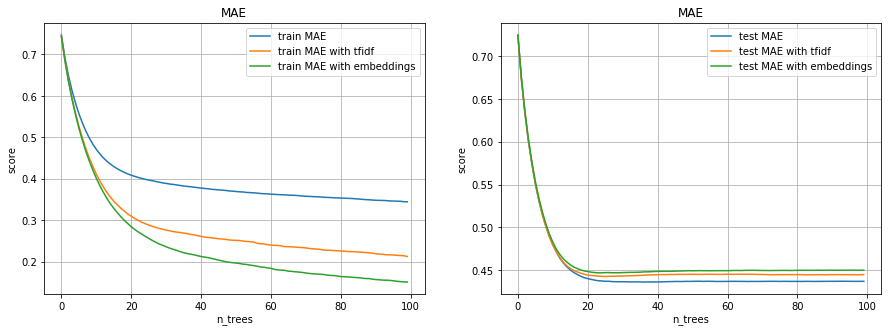

In [389]:
train_rmse_embed, train_mae_embed, test_rmse_embed, test_mae_embed = show_evals(evals_result_embed)
plot_compare(train_eval_mae, 'train MAE', train_mae_tf, 'train MAE with tfidf', test_eval_mae, 'test MAE', 
             test_mae_tf, 'test MAE with tfidf', train_mae_embed, 'train MAE with embeddings', 
             data7=test_mae_embed, label7='test MAE with embeddings')

## XGBoost с учетом SVD и tfidf

In [390]:
X_train, X_test, y_train, y_test = make_X_y(nltk=1)

X_train['user_bias'] = pd.Series(bu_upd, index=X_train.index)
X_train['wine_bias'] = pd.Series(bi_upd, index=X_train.index)
X_test['user_bias'] = pd.Series(bu_upd_test, index=X_test.index)
X_test['wine_bias'] = pd.Series(bi_upd_test, index=X_test.index)

for i in range(len(idx)):
    name = 'tfidf_' + str(i)
    X_train[name] = pd.Series([x[0] for x in tfidf_features[:,i].todense().tolist()], index=X_train.index)
    X_test[name] = pd.Series([x[0] for x in tfidf_feat_test[:,i].todense().tolist()], index=X_test.index)

imp_columns = X_train.columns

In [391]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)
print('Обучение: ', X_train.shape, '\t\tТест: ', X_test.shape)

Обучение:  (81927, 89) 		Тест:  (15300, 89)


In [392]:
evals_result_tf_svd, importances_tf_svd = xgb_reg(X_train, y_train, X_test, y_test, imp_columns)

/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/maria/anaconda3/lib/python3.7/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:46:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04851	validation_0-mae:0.743376	validation_1-rmse:1.01391	validation_1-mae:0.724696
[1]	validation_0-rmse:0.979105	validation_0-mae:0.685338	validation_1-rmse:0.959898	validation_1-mae:0.675329
[2]	validation_0-rmse:0.916996	validation_0-mae:0.635281	validation_1-rmse:0.913999	validation_1-mae:0.636606
[3]	validation_0-rmse:0.861597	validation_0-mae:0.592025	validation_1-rmse:0.874905	validation_1-mae:0.605163
[4]	validation_0-rmse:0.811846	validation_0-mae:0.553163	validation_1-rmse:0.841169	validation_1-mae:0.577797
[16:46:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04851	validation_0-mae:0.743376	validation_1-rmse:1.01391	validation_1-mae:0.724696
[1]	validation_0-rmse:0.979105	validation_0-mae:0.685338	validation_1-rmse:0.959898	valida

[19]	validation_0-rmse:0.466551	validation_0-mae:0.287555	validation_1-rmse:0.685531	validation_1-mae:0.445207
[20]	validation_0-rmse:0.457124	validation_0-mae:0.28036	validation_1-rmse:0.684217	validation_1-mae:0.444208
[21]	validation_0-rmse:0.448956	validation_0-mae:0.274039	validation_1-rmse:0.682724	validation_1-mae:0.44322
[22]	validation_0-rmse:0.440887	validation_0-mae:0.268179	validation_1-rmse:0.681727	validation_1-mae:0.442753
[23]	validation_0-rmse:0.432743	validation_0-mae:0.262084	validation_1-rmse:0.680832	validation_1-mae:0.442118
[24]	validation_0-rmse:0.425652	validation_0-mae:0.256878	validation_1-rmse:0.679946	validation_1-mae:0.44151
[16:46:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1.04851	validation_0-mae:0.743376	validation_1-rmse:1.01391	validation_1-mae:0.724696
[1]	validation_0-rmse:0.979105	validation_0-mae:0.685338	validation_1-rmse:0.959898	validation_1-mae:0

[0]	validation_0-rmse:1.04851	validation_0-mae:0.743376	validation_1-rmse:1.01391	validation_1-mae:0.724696
[1]	validation_0-rmse:0.979105	validation_0-mae:0.685338	validation_1-rmse:0.959898	validation_1-mae:0.675329
[2]	validation_0-rmse:0.916996	validation_0-mae:0.635281	validation_1-rmse:0.913999	validation_1-mae:0.636606
[3]	validation_0-rmse:0.861597	validation_0-mae:0.592025	validation_1-rmse:0.874905	validation_1-mae:0.605163
[4]	validation_0-rmse:0.811846	validation_0-mae:0.553163	validation_1-rmse:0.841169	validation_1-mae:0.577797
[5]	validation_0-rmse:0.767649	validation_0-mae:0.519049	validation_1-rmse:0.813082	validation_1-mae:0.555069
[6]	validation_0-rmse:0.728124	validation_0-mae:0.488836	validation_1-rmse:0.789469	validation_1-mae:0.535896
[7]	validation_0-rmse:0.6929	validation_0-mae:0.46168	validation_1-rmse:0.769943	validation_1-mae:0.519541
[8]	validation_0-rmse:0.661429	validation_0-mae:0.43752	validation_1-rmse:0.753721	validation_1-mae:0.505495
[9]	validation_0

[34]	validation_0-rmse:0.375096	validation_0-mae:0.220568	validation_1-rmse:0.677015	validation_1-mae:0.441179
[35]	validation_0-rmse:0.37204	validation_0-mae:0.218449	validation_1-rmse:0.676908	validation_1-mae:0.44123
[36]	validation_0-rmse:0.368627	validation_0-mae:0.216219	validation_1-rmse:0.676787	validation_1-mae:0.441339
[37]	validation_0-rmse:0.36576	validation_0-mae:0.214256	validation_1-rmse:0.67679	validation_1-mae:0.441542
[38]	validation_0-rmse:0.361978	validation_0-mae:0.211914	validation_1-rmse:0.677057	validation_1-mae:0.441871
[39]	validation_0-rmse:0.360106	validation_0-mae:0.210507	validation_1-rmse:0.676951	validation_1-mae:0.441999
[40]	validation_0-rmse:0.357873	validation_0-mae:0.20895	validation_1-rmse:0.6771	validation_1-mae:0.44212
[41]	validation_0-rmse:0.356251	validation_0-mae:0.207597	validation_1-rmse:0.677045	validation_1-mae:0.442197
[42]	validation_0-rmse:0.352627	validation_0-mae:0.205321	validation_1-rmse:0.677145	validation_1-mae:0.442379
[43]	vali

[12]	validation_0-rmse:0.56371	validation_0-mae:0.362615	validation_1-rmse:0.711758	validation_1-mae:0.468435
[13]	validation_0-rmse:0.545766	validation_0-mae:0.348605	validation_1-rmse:0.705488	validation_1-mae:0.462673
[14]	validation_0-rmse:0.529447	validation_0-mae:0.335786	validation_1-rmse:0.70061	validation_1-mae:0.457919
[15]	validation_0-rmse:0.514937	validation_0-mae:0.324589	validation_1-rmse:0.696509	validation_1-mae:0.454211
[16]	validation_0-rmse:0.500979	validation_0-mae:0.313968	validation_1-rmse:0.693063	validation_1-mae:0.451272
[17]	validation_0-rmse:0.48891	validation_0-mae:0.304521	validation_1-rmse:0.69031	validation_1-mae:0.448778
[18]	validation_0-rmse:0.477375	validation_0-mae:0.295713	validation_1-rmse:0.687826	validation_1-mae:0.44684
[19]	validation_0-rmse:0.466551	validation_0-mae:0.287555	validation_1-rmse:0.685531	validation_1-mae:0.445207
[20]	validation_0-rmse:0.457124	validation_0-mae:0.28036	validation_1-rmse:0.684217	validation_1-mae:0.444208
[21]	va

[31]	validation_0-rmse:0.386268	validation_0-mae:0.228599	validation_1-rmse:0.677305	validation_1-mae:0.440875
[32]	validation_0-rmse:0.382223	validation_0-mae:0.225652	validation_1-rmse:0.677338	validation_1-mae:0.441084
[33]	validation_0-rmse:0.379017	validation_0-mae:0.223202	validation_1-rmse:0.677018	validation_1-mae:0.440977
[34]	validation_0-rmse:0.375096	validation_0-mae:0.220568	validation_1-rmse:0.677015	validation_1-mae:0.441179
[35]	validation_0-rmse:0.37204	validation_0-mae:0.218449	validation_1-rmse:0.676908	validation_1-mae:0.44123
[36]	validation_0-rmse:0.368627	validation_0-mae:0.216219	validation_1-rmse:0.676787	validation_1-mae:0.441339
[37]	validation_0-rmse:0.36576	validation_0-mae:0.214256	validation_1-rmse:0.67679	validation_1-mae:0.441542
[38]	validation_0-rmse:0.361978	validation_0-mae:0.211914	validation_1-rmse:0.677057	validation_1-mae:0.441871
[39]	validation_0-rmse:0.360106	validation_0-mae:0.210507	validation_1-rmse:0.676951	validation_1-mae:0.441999
[40]	

[45]	validation_0-rmse:0.34288	validation_0-mae:0.199195	validation_1-rmse:0.677064	validation_1-mae:0.442649
[46]	validation_0-rmse:0.339828	validation_0-mae:0.197428	validation_1-rmse:0.677055	validation_1-mae:0.442766
[47]	validation_0-rmse:0.336815	validation_0-mae:0.195634	validation_1-rmse:0.677007	validation_1-mae:0.442867
[48]	validation_0-rmse:0.335014	validation_0-mae:0.194567	validation_1-rmse:0.677117	validation_1-mae:0.44302
[49]	validation_0-rmse:0.331326	validation_0-mae:0.192518	validation_1-rmse:0.677199	validation_1-mae:0.443191
[50]	validation_0-rmse:0.329596	validation_0-mae:0.191346	validation_1-rmse:0.677197	validation_1-mae:0.443186
[51]	validation_0-rmse:0.327897	validation_0-mae:0.190389	validation_1-rmse:0.67711	validation_1-mae:0.443241
[52]	validation_0-rmse:0.325046	validation_0-mae:0.188827	validation_1-rmse:0.677173	validation_1-mae:0.443413
[53]	validation_0-rmse:0.320566	validation_0-mae:0.186503	validation_1-rmse:0.677049	validation_1-mae:0.443416
[54]

[54]	validation_0-rmse:0.318931	validation_0-mae:0.185578	validation_1-rmse:0.677041	validation_1-mae:0.443431
[55]	validation_0-rmse:0.317259	validation_0-mae:0.184624	validation_1-rmse:0.677122	validation_1-mae:0.443464
[56]	validation_0-rmse:0.315691	validation_0-mae:0.18379	validation_1-rmse:0.677086	validation_1-mae:0.443524
[57]	validation_0-rmse:0.314033	validation_0-mae:0.182872	validation_1-rmse:0.677053	validation_1-mae:0.443627
[58]	validation_0-rmse:0.31003	validation_0-mae:0.180916	validation_1-rmse:0.677243	validation_1-mae:0.443832
[59]	validation_0-rmse:0.307478	validation_0-mae:0.179367	validation_1-rmse:0.677251	validation_1-mae:0.444044
[60]	validation_0-rmse:0.305504	validation_0-mae:0.178356	validation_1-rmse:0.677283	validation_1-mae:0.444186
[61]	validation_0-rmse:0.303594	validation_0-mae:0.177239	validation_1-rmse:0.677341	validation_1-mae:0.444265
[62]	validation_0-rmse:0.302245	validation_0-mae:0.176453	validation_1-rmse:0.677298	validation_1-mae:0.444246
[63

[58]	validation_0-rmse:0.31003	validation_0-mae:0.180916	validation_1-rmse:0.677243	validation_1-mae:0.443832
[59]	validation_0-rmse:0.307478	validation_0-mae:0.179367	validation_1-rmse:0.677251	validation_1-mae:0.444044
[60]	validation_0-rmse:0.305504	validation_0-mae:0.178356	validation_1-rmse:0.677283	validation_1-mae:0.444186
[61]	validation_0-rmse:0.303594	validation_0-mae:0.177239	validation_1-rmse:0.677341	validation_1-mae:0.444265
[62]	validation_0-rmse:0.302245	validation_0-mae:0.176453	validation_1-rmse:0.677298	validation_1-mae:0.444246
[63]	validation_0-rmse:0.301742	validation_0-mae:0.176079	validation_1-rmse:0.677304	validation_1-mae:0.44427
[64]	validation_0-rmse:0.301269	validation_0-mae:0.175715	validation_1-rmse:0.677324	validation_1-mae:0.444304
[65]	validation_0-rmse:0.300276	validation_0-mae:0.1751	validation_1-rmse:0.677314	validation_1-mae:0.444286
[66]	validation_0-rmse:0.29886	validation_0-mae:0.174322	validation_1-rmse:0.677315	validation_1-mae:0.444297
[67]	v

[57]	validation_0-rmse:0.314033	validation_0-mae:0.182872	validation_1-rmse:0.677053	validation_1-mae:0.443627
[58]	validation_0-rmse:0.31003	validation_0-mae:0.180916	validation_1-rmse:0.677243	validation_1-mae:0.443832
[59]	validation_0-rmse:0.307478	validation_0-mae:0.179367	validation_1-rmse:0.677251	validation_1-mae:0.444044
[60]	validation_0-rmse:0.305504	validation_0-mae:0.178356	validation_1-rmse:0.677283	validation_1-mae:0.444186
[61]	validation_0-rmse:0.303594	validation_0-mae:0.177239	validation_1-rmse:0.677341	validation_1-mae:0.444265
[62]	validation_0-rmse:0.302245	validation_0-mae:0.176453	validation_1-rmse:0.677298	validation_1-mae:0.444246
[63]	validation_0-rmse:0.301742	validation_0-mae:0.176079	validation_1-rmse:0.677304	validation_1-mae:0.44427
[64]	validation_0-rmse:0.301269	validation_0-mae:0.175715	validation_1-rmse:0.677324	validation_1-mae:0.444304
[65]	validation_0-rmse:0.300276	validation_0-mae:0.1751	validation_1-rmse:0.677314	validation_1-mae:0.444286
[66]	

[51]	validation_0-rmse:0.327897	validation_0-mae:0.190389	validation_1-rmse:0.67711	validation_1-mae:0.443241
[52]	validation_0-rmse:0.325046	validation_0-mae:0.188827	validation_1-rmse:0.677173	validation_1-mae:0.443413
[53]	validation_0-rmse:0.320566	validation_0-mae:0.186503	validation_1-rmse:0.677049	validation_1-mae:0.443416
[54]	validation_0-rmse:0.318931	validation_0-mae:0.185578	validation_1-rmse:0.677041	validation_1-mae:0.443431
[55]	validation_0-rmse:0.317259	validation_0-mae:0.184624	validation_1-rmse:0.677122	validation_1-mae:0.443464
[56]	validation_0-rmse:0.315691	validation_0-mae:0.18379	validation_1-rmse:0.677086	validation_1-mae:0.443524
[57]	validation_0-rmse:0.314033	validation_0-mae:0.182872	validation_1-rmse:0.677053	validation_1-mae:0.443627
[58]	validation_0-rmse:0.31003	validation_0-mae:0.180916	validation_1-rmse:0.677243	validation_1-mae:0.443832
[59]	validation_0-rmse:0.307478	validation_0-mae:0.179367	validation_1-rmse:0.677251	validation_1-mae:0.444044
[60]

[40]	validation_0-rmse:0.357873	validation_0-mae:0.20895	validation_1-rmse:0.6771	validation_1-mae:0.44212
[41]	validation_0-rmse:0.356251	validation_0-mae:0.207597	validation_1-rmse:0.677045	validation_1-mae:0.442197
[42]	validation_0-rmse:0.352627	validation_0-mae:0.205321	validation_1-rmse:0.677145	validation_1-mae:0.442379
[43]	validation_0-rmse:0.34825	validation_0-mae:0.202688	validation_1-rmse:0.677127	validation_1-mae:0.442595
[44]	validation_0-rmse:0.345839	validation_0-mae:0.201011	validation_1-rmse:0.677171	validation_1-mae:0.442652
[45]	validation_0-rmse:0.34288	validation_0-mae:0.199195	validation_1-rmse:0.677064	validation_1-mae:0.442649
[46]	validation_0-rmse:0.339828	validation_0-mae:0.197428	validation_1-rmse:0.677055	validation_1-mae:0.442766
[47]	validation_0-rmse:0.336815	validation_0-mae:0.195634	validation_1-rmse:0.677007	validation_1-mae:0.442867
[48]	validation_0-rmse:0.335014	validation_0-mae:0.194567	validation_1-rmse:0.677117	validation_1-mae:0.44302
[49]	val

[24]	validation_0-rmse:0.425652	validation_0-mae:0.256878	validation_1-rmse:0.679946	validation_1-mae:0.44151
[25]	validation_0-rmse:0.419256	validation_0-mae:0.25197	validation_1-rmse:0.67919	validation_1-mae:0.441041
[26]	validation_0-rmse:0.412434	validation_0-mae:0.247323	validation_1-rmse:0.678773	validation_1-mae:0.440967
[27]	validation_0-rmse:0.406137	validation_0-mae:0.242852	validation_1-rmse:0.678526	validation_1-mae:0.440917
[28]	validation_0-rmse:0.400684	validation_0-mae:0.23898	validation_1-rmse:0.678117	validation_1-mae:0.440836
[29]	validation_0-rmse:0.396288	validation_0-mae:0.235555	validation_1-rmse:0.677796	validation_1-mae:0.440777
[30]	validation_0-rmse:0.390858	validation_0-mae:0.231896	validation_1-rmse:0.677546	validation_1-mae:0.440797
[31]	validation_0-rmse:0.386268	validation_0-mae:0.228599	validation_1-rmse:0.677305	validation_1-mae:0.440875
[32]	validation_0-rmse:0.382223	validation_0-mae:0.225652	validation_1-rmse:0.677338	validation_1-mae:0.441084
[33]	

[2]	validation_0-rmse:0.916996	validation_0-mae:0.635281	validation_1-rmse:0.913999	validation_1-mae:0.636606
[3]	validation_0-rmse:0.861597	validation_0-mae:0.592025	validation_1-rmse:0.874905	validation_1-mae:0.605163
[4]	validation_0-rmse:0.811846	validation_0-mae:0.553163	validation_1-rmse:0.841169	validation_1-mae:0.577797
[5]	validation_0-rmse:0.767649	validation_0-mae:0.519049	validation_1-rmse:0.813082	validation_1-mae:0.555069
[6]	validation_0-rmse:0.728124	validation_0-mae:0.488836	validation_1-rmse:0.789469	validation_1-mae:0.535896
[7]	validation_0-rmse:0.6929	validation_0-mae:0.46168	validation_1-rmse:0.769943	validation_1-mae:0.519541
[8]	validation_0-rmse:0.661429	validation_0-mae:0.43752	validation_1-rmse:0.753721	validation_1-mae:0.505495
[9]	validation_0-rmse:0.632939	validation_0-mae:0.415788	validation_1-rmse:0.740304	validation_1-mae:0.493833
[10]	validation_0-rmse:0.607534	validation_0-mae:0.396346	validation_1-rmse:0.728976	validation_1-mae:0.483985
[11]	validati

[77]	validation_0-rmse:0.286327	validation_0-mae:0.166532	validation_1-rmse:0.677504	validation_1-mae:0.444775
[78]	validation_0-rmse:0.283693	validation_0-mae:0.165205	validation_1-rmse:0.677495	validation_1-mae:0.444791
[79]	validation_0-rmse:0.28314	validation_0-mae:0.164721	validation_1-rmse:0.677526	validation_1-mae:0.444816
[80]	validation_0-rmse:0.282866	validation_0-mae:0.164483	validation_1-rmse:0.677543	validation_1-mae:0.444828
[81]	validation_0-rmse:0.280554	validation_0-mae:0.16332	validation_1-rmse:0.677583	validation_1-mae:0.444884
[82]	validation_0-rmse:0.279368	validation_0-mae:0.162667	validation_1-rmse:0.677587	validation_1-mae:0.444932
[83]	validation_0-rmse:0.278453	validation_0-mae:0.16219	validation_1-rmse:0.677615	validation_1-mae:0.444987
[84]	validation_0-rmse:0.277147	validation_0-mae:0.161578	validation_1-rmse:0.677655	validation_1-mae:0.44503
[85]	validation_0-rmse:0.275245	validation_0-mae:0.160618	validation_1-rmse:0.677627	validation_1-mae:0.445079
[86]	

[0.724696, 0.675329, 0.636606, 0.605163, 0.577797, 0.555069, 0.535896, 0.519541, 0.505495, 0.493833]


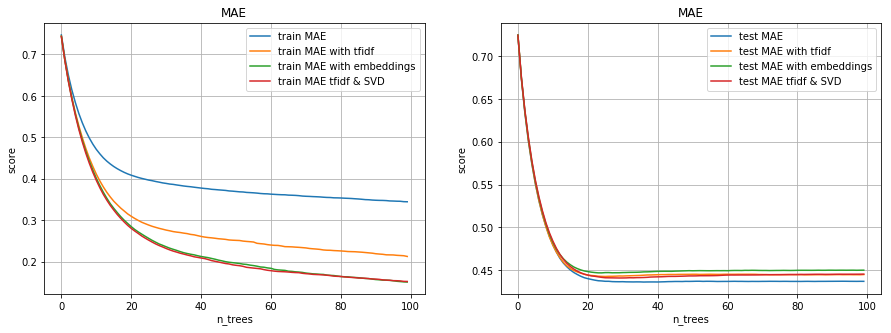

In [393]:
train_rmse_tf_svd, train_mae_tf_svd, test_rmse_tf_svd, test_mae_tf_svd = show_evals(evals_result_tf_svd)
plot_compare(train_eval_mae, 'train MAE', train_mae_tf, 'train MAE with tfidf', test_eval_mae, 'test MAE', 
             test_mae_tf, 'test MAE with tfidf', train_mae_embed, 'train MAE with embeddings', train_mae_tf_svd,
             'train MAE tfidf & SVD', test_mae_embed, 'test MAE with embeddings', test_mae_tf_svd, 
             'test MAE tfidf & SVD')

Пока вот такой интересный эффект переобучения почти сразу. В планах потюнить гиперпараметры xgboost-а (сейчас по графикам видно, что обучение больше 30 деревьев не имеет смысла). Кроме того, раз SVD сразу не вкладывает пользы в предсказания, стоит пересмотреть разбиение на датасета train на test честнее, с кросс-валидацией и плюшками. Посмотреть, что на новом куда более рандомизированном разбиении покажут те же эмбеддинги. 

В следующих сериях:

Обучение на датасете нейросетей, глубоких нейросетей с эмбеддингами, etc.
Косинусная мера для измерения похожести вин: https://www.kaggle.com/rounakbanik/movie-recommender-systems (Может круто рекомендовать продукты одной винодельни/одного купажа, но, скорее всего, на обобщении кислотности, алкоголя и прочих хим.параметрах, влияющих на вкус, обломается).
